In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from collections import defaultdict

In [16]:
# Load the Excel file
# file_path = '/data_disk/lichx/NeurIPS2023-One-Fits-All/Long-term_Forecasting/Output/汇总-画图用.xlsx'
file_path = '/data_disk/lichx/NeurIPS2023-One-Fits-All/Long-term_Forecasting/Output/11月13日画图.xlsx'
data1 = pd.read_excel(file_path, sheet_name=0)
data2 = pd.read_excel(file_path, sheet_name=1)
data3 = pd.read_excel(file_path, sheet_name=2)

## Train
dt1 = data1.iloc[1:8, 1:] # diff
dt2 = data1.iloc[13:-1, 1:] # inverse

## No Train
dt3 = data2.iloc[1:8, 1:] # diff
dt4 = data2.iloc[13:-1, 1:] # inverse

dt_8 = data3.iloc[13:-1, 1:]

In [7]:
def extract_models(columns):
    """
    提取模型名称

    参数:
    columns (list): 包含列名的列表。

    返回:
    list: 包含模型名称的排序列表。
    """
    chinese_to_english = {
        '（': '(',
        '）': ')'
    }
    unique_models = []
    models = set()

    for col in columns:
        if col.startswith('Methods'):
            continue
        
        col = ''.join(chinese_to_english.get(char, char) for char in col)
        match = re.match(r'^[^\.]+', col)
        if match:
            model = match.group(0)
            if model not in models:
                unique_models.append(model)
                models.add(model)

    return unique_models

def generate_color_list(methods):
    """
    根据给定列表的长度生成一个颜色列表，用于绘图。

    参数:
    methods (list): 需要生成颜色列表的参考列表。

    返回:
    list: 包含颜色代码的列表。
    """

    num_colors = len(methods)
    
    # 使用matplotlib的colormap来生成颜色列表
    cmap = plt.get_cmap('tab20')  # 选择一个colormap，这里使用'tab20'
    
    # 生成颜色列表
    color_list = [cmap(i) for i in range(num_colors)]
    
    return color_list

In [8]:
# 参数设置    
metrics = data1.iloc[0, 1:7].values
methods1 = extract_models(data1.columns)
methods2 = extract_models(data2.columns)
datasets = ['+%_sChina', '+%_nChina', '+%_usa', '+%_cq', 'ili_sChina', 'ili_nChina', 'ili_cq']
n_datasets = len(datasets) # 数据集
n_methods1 = len(methods1) # 方法
n_methods2 = len(methods2)
n_metrics = len(metrics) # 指标
width1 = 1  # 每个柱子的宽度
width2 = 0.5  
gap = 0.1
colors1 = generate_color_list(methods1)
colors2 = generate_color_list(methods2)

# 表格展示

In [9]:
def Rank(dt, methods=methods1):
    results = {}
    n_methods = len(methods)
    
    for i in range(n_metrics):
        data = [dt.iloc[:, i + (j*n_metrics)] for j in range(n_methods)]
        df = pd.DataFrame(data).T
        # df.index = pd.Index(datasets)
        df.columns = methods

        if i <= 1:
            top2_indices = df.apply(lambda x: x.argsort()[-2:][::-1], axis=1)
        else:
            top2_indices = df.apply(lambda x: x.argsort()[:2], axis=1)

        top2_methods = top2_indices.apply(lambda x: [methods[i] for i in x], axis=1)
        top2_methods = pd.DataFrame(top2_methods.tolist(), index=top2_methods.index, columns=[1, 2])
        results[f'{metrics[i]}_Top2_Models'] = top2_methods

    return results

def counts_all(r):
    """
    汇总结果
    """
    ranking_counts = defaultdict(lambda: {'1': 0, '2': 0})

    for df_key, df in r.items():
        for rank, col in enumerate(df.columns, start=1):
            for model in df[col]:
                ranking_counts[model][f'{rank}'] += 1

    ranking_df = pd.DataFrame.from_dict(ranking_counts, orient='index')
    ranking_df = ranking_df.sort_index()

    ranking_df['Sum'] = ranking_df[['1', '2']].sum(axis=1)
    ranking_df = ranking_df.sort_values(by='Sum', ascending=False)

    return ranking_df

def counts(r):
    """
    单个指标结果
    """
    ranking_counts_dict = {}

    for key, df in r.items():
        ranking_counts = defaultdict(lambda: {'1': 0, '2': 0})
        
        for rank, col in enumerate(df.columns, start=1):
            for model in df[col]:
                ranking_counts[model][f'{rank}'] += 1
        
        ranking_df = pd.DataFrame.from_dict(ranking_counts, orient='index')
        ranking_df['Sum'] = ranking_df[['1', '2']].sum(axis=1)
        ranking_df = ranking_df.sort_values(by='Sum', ascending=False)
        
        ranking_counts_dict[key] = ranking_df

    return ranking_counts_dict
  
def show(r):
    for key, ranking_df in r.items():
        print(f"Results for {key}:\n")
        print(ranking_df)
        print("\n" + "="*50 + "\n")

def rmNaN(df):
    df_cleaned = df.dropna(axis=1, how='all')
    return df_cleaned

def show_ranks(df):
    print(counts_all(Rank(df, extract_models(df.columns))))


In [6]:
dt1, dt2, dt3, dt4 = [rmNaN(dt) for dt in [dt1, dt2, dt3, dt4] ]


# 合并结果部分

In [7]:
## 合并全部结果
columns_to_drop = ['GPT4', 'GPT4.1', 'GPT4.2', 'GPT4.3', 'GPT4.4', 'GPT4.5',
                    'transformer', 'transformer.1', 'transformer.2', 'transformer.3', 'transformer.4', 'transformer.5']
dt1, dt2 = [dt.drop(columns=columns_to_drop) for dt in [dt1, dt2]]


KeyError: "['GPT4', 'GPT4.1', 'GPT4.2', 'GPT4.3', 'GPT4.4', 'GPT4.5', 'transformer', 'transformer.1', 'transformer.2', 'transformer.3', 'transformer.4', 'transformer.5'] not found in axis"

In [ ]:
dt1.columns = ['t_' + col for col in dt1.columns] # trained diff
dt2.columns = ['t_' + col for col in dt2.columns] # trained inverse
dt3.columns = ['u_' + col for col in dt3.columns] # untrained diff
dt4.columns = ['u_' + col for col in dt4.columns] # untrained inverse
dt3.columns = [col.replace('u_SARIMA', 't_SARIMA') if 'u_SARIMA' in col else col for col in dt3.columns]
dt4.columns = [col.replace('u_SARIMA', 't_SARIMA') if 'u_SARIMA' in col else col for col in dt4.columns]

df1 = pd.concat([dt1, dt3], axis=1) # diff
df2 = pd.concat([dt2, dt4], axis=1) # inverse
df1.columns = df1.columns.str.replace('leaky_relu', 'relu')
df2.columns = df2.columns.str.replace('leaky_relu', 'relu')

In [11]:
df_cleaned1 = dt1.drop(columns=[col for col in dt1.columns if 't_Llama2(leaky_relu)' in col])
df_cleaned2 = dt2.drop(columns=[col for col in dt2.columns if 't_Llama2(leaky_relu)' in col])
df_cleaned3 = dt1.drop(columns=[col for col in dt1.columns if 'Llama2' in col and 'relu_new' not in col])
df_cleaned4 = dt2.drop(columns=[col for col in dt2.columns if 'Llama2' in col and 'relu_new' not in col])
df_cleaned5 = df_cleaned3.drop(columns=[col for col in dt1.columns if 'embedding' in col and 'time' not in col])
df_cleaned6 = df_cleaned4.drop(columns=[col for col in dt2.columns if 'embedding' in col and 'time' not in col])
df_cleaned7 = df_cleaned3.drop(columns=[col for col in dt1.columns if 'LSTM' in col and '13' not in col])
df_cleaned8 = df_cleaned4.drop(columns=[col for col in dt2.columns if 'LSTM' in col and '13' not in col])

selected_models = ['Llama2(relu_new)', 'GPT2（6）', 'SARIMA', 'LSTM_13', 'PatchTST']
df_select = dt2[[col for col in dt2.columns if any(model in col for model in selected_models)]]

In [53]:
for i in range(dt2.shape[0]):
    df = dt2.iloc[i:i+1, :]
    df.index = pd.Index([datasets[i]])
    print(f'{datasets[i]}:')
    print(counts_all(Rank(df, extract_models(df.columns))))
    print()

+%_sChina:
             1  2  Sum
LSTM         2  2    4
GPT2(6)      2  0    2
Llama2(new)  0  2    2
SARIMA       2  0    2
llama3       0  2    2

+%_nChina:
             1  2  Sum
Llama2(new)  2  4    6
GPT2(6)      2  1    3
SARIMA       2  0    2
PatchTST     0  1    1

+%_usa:
             1  2  Sum
Llama2(new)  3  3    6
LSTM         0  2    2
PatchTST     1  1    2
SARIMA       2  0    2

+%_cq:
             1  2  Sum
Llama2(new)  2  2    4
SARIMA       4  0    4
PatchTST     0  2    2
GPT4         0  1    1
LSTM         0  1    1

ili_sChina:
          1  2  Sum
GPT2(6)   3  1    4
LSTM      0  4    4
SARIMA    2  0    2
GPT4      1  0    1
PatchTST  0  1    1

ili_nChina:
             1  2  Sum
GPT2(6)      0  4    4
Llama2(new)  2  1    3
LSTM         1  1    2
GPT4         1  0    1
PatchTST     1  0    1
SARIMA       1  0    1

ili_cq:
                  1  2  Sum
SARIMA            4  0    4
GPT2(6)           0  3    3
LSTM              2  1    3
GPT2(leaky_relu)  0  2    

In [14]:
counts_all(Rank(df_select, extract_models(df_select.columns)))

1   2  Sum
Llama2(relu_new)   9  16   25
SARIMA            17   1   18
GPT2(6)            9   8   17
LSTM_13            5  11   16
PatchTST           2   6    8

In [18]:
counts_all(Rank(dt_8, extract_models(dt_8.columns)))

1   2  Sum
GPT2(8)       5  16   21
LSTM(8)      16   3   19
Llama2(8)     6  10   16
SARIMA(8)    13   2   15
PatchTST(8)   2  11   13

In [52]:
print('CN')
idx = [0, 1, 2, 4, 5]
df = dt2.iloc[idx, :]
df.index = pd.Index([datasets[i] for i in idx])
print(counts_all(Rank(df, extract_models(df.columns))))
print()

print('PR')
idx = [0, 1, 2]
df = dt2.iloc[idx, :]
df.index = pd.Index([datasets[i] for i in idx])
print(counts_all(Rank(df, extract_models(df.columns))))
print()

print('ILI')
idx = [4, 5]
df = dt2.iloc[idx, :]
df.index = pd.Index([datasets[i] for i in idx])
print(counts_all(Rank(df, extract_models(df.columns))))
print()

CN
             1   2  Sum
Llama2(new)  7  10   17
GPT2(6)      7   6   13
LSTM         3   9   12
SARIMA       9   0    9
PatchTST     2   3    5
GPT4         2   0    2
llama3       0   2    2

PR
             1  2  Sum
Llama2(new)  5  9   14
LSTM         2  4    6
SARIMA       6  0    6
GPT2(6)      4  1    5
PatchTST     1  2    3
llama3       0  2    2

ILI
             1  2  Sum
GPT2(6)      3  5    8
LSTM         1  5    6
Llama2(new)  2  1    3
SARIMA       3  0    3
GPT4         2  0    2
PatchTST     1  1    2



In [11]:
## 全部
print(counts_all(Rank(dt1, extract_models(dt1.columns))))
print('\n', counts_all(Rank(dt2, extract_models(dt2.columns))))

                  1   2  Sum
PatchTST          7  13   20
Llama2(new)       8   9   17
GPT2(6)           5   7   12
LSTM              5   4    9
llama3            4   4    8
SARIMA            5   2    7
GPT4              6   0    6
GPT2(leaky_relu)  0   3    3
Llama2(6)         2   0    2

                    1   2  Sum
Llama2(new)        9  12   21
SARIMA            17   0   17
GPT2(6)            7   9   16
LSTM               5  11   16
PatchTST           2   5    7
GPT4               2   1    3
GPT2(leaky_relu)   0   2    2
llama3             0   2    2


In [43]:
## 去掉原先的Llama2 relu结果
print(counts_all(Rank(df_cleaned1, extract_models(df_cleaned1.columns))))
print('\n', counts_all(Rank(df_cleaned2, extract_models(df_cleaned2.columns))))

                                  1  2  Sum
t_LSTM                           10  5   15
t_Llama2(relu_new)                6  7   13
t_Llama2(relu_half)               3  7   10
t_PatchTST                        6  4   10
t_embedding                       3  5    8
t_LSTM_13                         4  2    6
t_llama3                          2  4    6
t_GPT2(6)                         2  3    5
t_GPT4(diff)                      2  3    5
t_embedding(序列间加time embedding)   3  0    3
t_Llama2(6)                       1  1    2
t_Llama2(32)                      0  1    1

                                   1   2  Sum
t_LSTM                           20   2   22
t_Llama2(relu_new)                7   9   16
t_Llama2(relu_half)               1  10   11
t_GPT2(6)                         5   4    9
t_LSTM_13                         1   8    9
t_embedding                       2   3    5
t_embedding(序列间加time embedding)   4   0    4
t_GPT4(nrom)                      2   1    3
t_PatchTST           

In [44]:
## 所有Llama2结果中只保留新的Llama2 relu结果
print(counts_all(Rank(df_cleaned3, extract_models(df_cleaned3.columns))))
print('\n', counts_all(Rank(df_cleaned4, extract_models(df_cleaned4.columns))))

                                  1   2  Sum
t_Llama2(relu_new)                8   9   17
t_PatchTST                        7  10   17
t_LSTM                           11   5   16
t_embedding                       3   6    9
t_LSTM_13                         4   2    6
t_GPT2(6)                         2   3    5
t_GPT4(diff)                      2   3    5
t_llama3                          2   3    5
t_embedding(序列间加time embedding)   3   0    3
t_GPT2(leaky_relu)                0   1    1

                                   1   2  Sum
t_LSTM                           20   2   22
t_Llama2(relu_new)                8  12   20
t_LSTM_13                         1  11   12
t_GPT2(6)                         5   6   11
t_PatchTST                        0   6    6
t_embedding                       2   4    6
t_embedding(序列间加time embedding)   4   0    4
t_GPT4(nrom)                      2   1    3


In [45]:
## 13步lstm
print(counts_all(Rank(df_cleaned7, extract_models(df_cleaned7.columns))))
print('\n', counts_all(Rank(df_cleaned8, extract_models(df_cleaned8.columns))))

                                  1   2  Sum
t_PatchTST                        8  13   21
t_Llama2(relu_new)               13   6   19
t_embedding                       3   7   10
t_GPT2(6)                         2   5    7
t_LSTM_13                         6   0    6
t_llama3                          2   4    6
t_GPT4(diff)                      4   1    5
t_embedding(序列间加time embedding)   3   1    4
t_GPT2(leaky_relu)                1   2    3
t_Gemma2(leaky_relu)              0   3    3

                                   1   2  Sum
t_Llama2(relu_new)               17   6   23
t_GPT2(6)                         7  11   18
t_LSTM_13                         8   8   16
t_PatchTST                        1   8    9
t_embedding                       2   4    6
t_embedding(序列间加time embedding)   4   0    4
t_GPT4(nrom)                      3   0    3
t_GPT2(leaky_relu)                0   2    2
t_Gemma2(leaky_relu)              0   2    2
t_GPT4(diff)                      0   1    1


In [ ]:
df_cleaned9 = df_cleaned7.drop(columns=[col for col in dt1.columns if 'embedding' in col and '13' not in col])
df_cleaned10 = df_cleaned8.drop(columns=[col for col in dt2.columns if 'embedding' in col and '13' not in col])


In [32]:
show_ranks(df_cleaned5)
show_ranks(df_cleaned6)

                                  1   2  Sum
t_LSTM                           15   5   20
t_PatchTST                        7  10   17
t_Llama2(relu_new)                8   8   16
t_GPT2(6)                         5   5   10
t_embedding(序列间加time embedding)   2   5    7
t_GPT4(diff)                      3   3    6
t_llama3                          2   3    5
t_GPT2(leaky_relu)                0   3    3
                                  1   2  Sum
t_LSTM                           22   2   24
t_Llama2(relu_new)                9  12   21
t_GPT2(6)                         7  13   20
t_PatchTST                        0   8    8
t_embedding(序列间加time embedding)   2   2    4
t_GPT4(nrom)                      2   1    3
t_GPT2(leaky_relu)                0   2    2
t_GPT4(diff)                      0   2    2


## 各指标排名

In [18]:
rank1 = Rank(df1, extract_models(df1.columns))
rank2 = Rank(df2, extract_models(df2.columns))
count1 = counts(rank1)
count2 = counts(rank2)
tabel1 = counts_all(rank1)
tabel2 = counts_all(rank2)

In [20]:
count1 # diff

{'SpearmanR_Top2_Models':                     1  2  Sum
 t_Llama2(relu_new)  1  3    4
 t_LSTM              2  1    3
 t_PatchTST          1  1    2
 u_Gemma2(relu)      2  0    2
 t_SARIMA            1  0    1
 t_GPT4(diff)        0  1    1
 t_Llama2(relu)      0  1    1,
 'PearsonR_Top2_Models':                     1  2  Sum
 t_Llama2(relu_new)  1  3    4
 t_LSTM              2  0    2
 t_PatchTST          1  1    2
 t_SARIMA            1  0    1
 u_Gemma2(relu)      1  0    1
 u_GPT2(relu)        1  0    1
 t_GPT4(diff)        0  1    1
 t_Llama2(relu)      0  1    1
 t_Llama2(6)         0  1    1,
 'MAE_Top2_Models':                     1  2  Sum
 t_embedding         2  1    3
 t_Llama2(relu_new)  2  1    3
 t_LSTM              2  0    2
 t_Llama2(relu)      0  2    2
 u_GPT2(6)           1  0    1
 t_GPT2(6)           0  1    1
 t_GPT4(diff)        0  1    1
 t_GPT2(relu)        0  1    1,
 'MSE_Top2_Models':                     1  2  Sum
 t_embedding         1  2    3
 t_LSTM    

In [21]:
count2 # inverse

{'SpearmanR_Top2_Models':                     1  2  Sum
 t_LSTM              4  0    4
 t_SARIMA            1  3    4
 u_GPT2(6)           1  2    3
 u_Llama2(norm)      1  0    1
 u_GPT2(relu)        0  1    1
 t_Llama2(relu_new)  0  1    1,
 'PearsonR_Top2_Models':                 1  2  Sum
 t_SARIMA        2  1    3
 t_LSTM          2  1    3
 u_GPT2(6)       0  3    3
 u_Llama2(relu)  1  1    2
 u_Gemma2(relu)  1  0    1
 u_Llama2(norm)  1  0    1
 u_Llama2(32)    0  1    1,
 'MAE_Top2_Models':                     1  2  Sum
 t_embedding         2  1    3
 t_Llama2(relu_new)  2  1    3
 t_LSTM              2  0    2
 t_GPT2(6)           0  2    2
 t_Llama2(relu)      0  2    2
 t_GPT4(nrom)        1  0    1
 t_GPT2(relu)        0  1    1,
 'MSE_Top2_Models':                     1  2  Sum
 t_LSTM              2  1    3
 t_embedding         2  0    2
 t_Llama2(relu_new)  2  0    2
 t_Llama2(relu)      0  2    2
 t_PatchTST          0  2    2
 t_GPT4(nrom)        1  0    1
 t_GPT4(diff

In [11]:
print('diff:\n', tabel1)
print('\ninverse:\n', tabel2)


diff:
                      1  2   3  Sum
t_Llama2(relu_new)   6  9   7   22
t_PatchTST           5  4  12   21
t_LSTM              12  4   1   17
t_Llama2(relu)       1  7   8   16
t_GPT2(6)            1  7   3   11
u_GPT2(6)            4  3   2    9
t_GPT4(diff)         3  3   1    7
t_SARIMA             4  0   2    6
u_Gemma2(relu)       3  0   1    4
u_Llama2(relu)       2  1   1    4
t_GPT2(relu)         0  2   0    2
t_Llama2(6)          0  1   1    2
u_GPT2(relu)         1  0   1    2
t_Llama2(32)         0  1   0    1
u_GPT4(diff)         0  0   1    1
u_Llama2(6)          0  0   1    1

inverse:
                      1  2  3  Sum
t_Llama2(relu_new)   9  5  5   19
t_LSTM              11  2  4   17
t_GPT2(6)            7  6  3   16
u_GPT2(6)            1  8  5   14
t_SARIMA             7  4  3   14
t_PatchTST           0  5  5   10
u_Llama2(relu)       1  1  8   10
t_Llama2(relu)       0  6  3    9
t_GPT4(diff)         1  1  1    3
t_Llama2(6)          0  0  2    2
t_GPT2(relu) 

In [27]:
result1 = Rank(dt1, extract_models(dt1.columns))
result2 = Rank(dt2, extract_models(dt2.columns))
result3 = Rank(dt3, extract_models(dt3.columns))
result4 = Rank(dt4, extract_models(dt4.columns))

In [14]:
## 分指标汇总表
count1 = counts(result1)
count2 = counts(result2)
count3 = counts(result3)
count4 = counts(result4)
show(count1)


Results for SpearmanR_Top3_Models:

                    1  2  3  Sum
Llama2(leaky_relu)  2  2  1    5
PatchTST            2  2  1    5
LSTM                3  0  1    4
GPT4(diff)          0  1  2    3
Llama2(6)           0  2  0    2
Gemma2(leaky_relu)  0  0  1    1
GPT2(leaky_relu)    0  0  1    1


Results for PearsonR_Top3_Models:

                    1  2  3  Sum
Llama2(leaky_relu)  2  3  0    5
PatchTST            2  2  1    5
LSTM                2  1  1    4
Llama2(6)           1  0  1    2
GPT4(diff)          0  1  1    2
Gemma2(leaky_relu)  0  0  1    1
Llama2(32)          0  0  1    1
GPT2(leaky_relu)    0  0  1    1


Results for MAE_Top3_Models:

                    1  2  3  Sum
GPT2(6)             2  1  1    4
LSTM                2  2  0    4
PatchTST            0  3  1    4
Llama2(leaky_relu)  2  0  1    3
GPT4(diff)          1  0  1    2
GPT2(leaky_relu)    0  1  0    1
Llama2(6)           0  0  1    1
Llama2(32)          0  0  1    1
GPT4                0  0  1    1


Re

In [15]:
## 汇总表
tabel1 = counts_all(result1)
tabel2 = counts_all(result2)
tabel3 = counts_all(result3)
tabel4 = counts_all(result4)
print('Tuned:')
print('diff:\n', tabel1)
print('\ninverse:\n', tabel2)
print('\nNo Tuned:')
print('diff:\n', tabel3)
print('\ninverse:\n', tabel4)

Tuned:
diff:
                      1   2  3  Sum
LSTM                14   7  4   25
PatchTST             8  12  5   25
Llama2(leaky_relu)   9   8  6   23
GPT2(6)              6   8  2   16
GPT4(diff)           4   2  8   14
Llama2(6)            1   2  5    8
GPT2(leaky_relu)     0   2  2    4
GPT4                 0   0  4    4
Llama2(32)           0   1  3    4
Gemma2(leaky_relu)   0   0  3    3

inverse:
                      1   2   3  Sum
GPT2(6)             11  14   6   31
Llama2(leaky_relu)   6   9  14   29
LSTM                22   2   2   26
PatchTST             0  11   8   19
Llama2(6)            0   2   4    6
GPT4(diff)           1   1   2    4
GPT4                 0   0   3    3
GPT4(nrom)           2   1   0    3
GPT2(leaky_relu)     0   2   0    2
Gemma2(leaky_relu)   0   0   2    2
Llama2(32)           0   0   1    1

No Tuned:
diff:
                1   2   3  Sum
SARIMA         8  10   6   24
Llama2(relu)   3   6  12   21
GPT2(6)        8   9   3   20
GPT4(diff)    12   4

# 图片展示

In [10]:
def add_text(rects, ax):
    """
    根据值不同保留不同的小数位数：
    - 小于1保留3位小数
    - 小于100保留2位小数
    - 小于1000保留1位小数
    - 1000及以上保留整数
    """
    for rect in rects:
        height = rect.get_height()
        if height < 1:
            formatted_height = f'{height:.3f}'
        elif height < 100:
            formatted_height = f'{height:.2f}'
        elif height < 1000:
            formatted_height = f'{height:.1f}'
        else:
            formatted_height = f'{height:.0f}'
            
        ax.text(rect.get_x() + rect.get_width() / 2,
                height,
                formatted_height,
                ha='center', va='bottom', fontsize=9)

def normalize_path(path):
    # 确保路径以 / 结尾
    return os.path.join(path, '')

def visual1(dt, save_path='./Output/png/train/'):
    save_path = normalize_path(save_path)
    methods = extract_models(dt)
    n_methods = len(methods)

    for k in range(n_metrics): # 0-5
        ## 各数据集上mae, mse, mape量级不太一样，需要画子图
        if k in [2,3,4]:
            x = np.arange(n_methods) 

            fig, ax = plt.subplots(4, 2, figsize=(2*10, 2*11), dpi=100) ## 一行一张太长了，换个布局
            ax = ax.flatten()  # 将二维数组展平成一维数组

            for j in range(n_datasets):
                values = [dt.iloc[j, i*n_metrics+k] for i in range(n_methods)] # 
                bar = ax[j].bar(x, values, width2, label=datasets[j], color=colors1)
                add_text(bar, ax[j])
                ax[j].set_xticks(x)
                ax[j].tick_params(axis='both', which='major', labelsize=14)
                ax[j].set_xticklabels(methods, rotation=15, ha = 'center')
                ax[j].set_ylabel('Values', fontsize=16)
                ax[j].set_title(f'{metrics[k]}')
                ax[j].legend(loc='best')
                ax[j].margins(y=0.2)  # 自动扩展 y 轴范围, 增加 20% 的空间

            # 删除最后一个空白子图
            if len(ax) > n_datasets:
                fig.delaxes(ax[-1])
                
        else:  
            x = np.arange(n_datasets) * (n_methods + 1)
            # x = np.arange(n_datasets) * (n_methods * (width1 + gap))
            fig, ax = plt.subplots(figsize=(12, 8))
            for i in range(n_methods): # 0-3
                values = dt.iloc[:, i*n_metrics+k].values 
                bar = ax.bar(x + i*(width1 + gap), values, width1, label=methods[i], color=colors1[i])
                add_text(bar, ax)

            # 设置x轴刻度
            ax.set_xticks(x + (width1 + gap) * (n_methods - 1) / 2)
            ax.tick_params(axis='both', which='major', labelsize=14)
            ax.set_xticklabels(datasets)
            ax.set_xlabel('Datasets', fontsize=16)
            ax.set_ylabel('Values', fontsize=16)
            ax.set_title(f'{metrics[k]}')
            ax.legend(loc='best')

        fig.tight_layout()
        plt.savefig(f'{save_path}{metrics[k]}.png')
        plt.show()

def visual2(dt, save_path='./Output/png/no_train/'):
    save_path = normalize_path(save_path)
    methods = extract_models(dt)
    n_methods = len(methods)

    for k in range(n_metrics): # 0-5
        ## 各数据集上mae, mse, mape量级不太一样，需要画子图
        if k in [2,3,4]:
            x = np.arange(n_methods) 

            fig, ax = plt.subplots(4, 2, figsize=(2*10, 2*11), dpi=100) ## 一行一张太长了，换个布局
            ax = ax.flatten()  # 将二维数组展平成一维数组

            for j in range(n_datasets):
                values = [dt.iloc[j, i*n_metrics+k] for i in range(n_methods)]
                bar = ax[j].bar(x, values, width2, label=datasets[j], color=colors2)
                add_text(bar, ax[j])
                ax[j].set_xticks(x)
                ax[j].tick_params(axis='both', which='major', labelsize=14)
                ax[j].set_xticklabels(methods)
                ax[j].set_ylabel('Values', fontsize=16)
                ax[j].set_title(f'{metrics[k]}')
                ax[j].legend(loc='best')
                ax[j].margins(y=0.2)  # 自动扩展 y 轴范围, 增加 10% 的空间

            # 删除最后一个空白子图
            if len(ax) > n_datasets:
                fig.delaxes(ax[-1])
                
        else:  
            x = np.arange(n_datasets) * (n_methods + 1)
            fig, ax = plt.subplots(figsize=(12, 8))
            for i in range(n_methods): # 0-3
                values = dt.iloc[:, i*n_metrics+k].values 
                bar = ax.bar(x + i*(width1 + gap), values, width1, label=methods[i], color=colors2[i])
                add_text(bar, ax)

            # 设置x轴刻度
            ax.set_xticks(x + (width1 + gap) * (n_methods - 1) / 2)
            ax.tick_params(axis='both', which='major', labelsize=14)
            ax.set_xticklabels(datasets)
            ax.set_xlabel('Datasets', fontsize=16)
            ax.set_ylabel('Values', fontsize=16)
            ax.set_title(f'{metrics[k]}')
            ax.legend(loc='best')
            ax.margins(y=0.2)  # 自动扩展 y 轴范围, 增加 10% 的空间

        fig.tight_layout()
        plt.savefig(f'{save_path}{metrics[k]}.png')
        plt.show()

def visual(dt, save_path='./Output/png/train/'):
    save_path = normalize_path(save_path)
    methods = extract_models(dt)
    n_methods = len(methods)
    colors = generate_color_list(methods)
    width = 1 # 柱子宽度
    spacing = 0.2 # 柱子间距

    for k in range(n_metrics): # 0-5
        ## 各数据集上mae, mse, mape量级不太一样，需要画子图
        x = np.arange(n_methods)  * (1 + spacing)

        fig, ax = plt.subplots(1, n_datasets, figsize=(n_datasets * 8, 6), dpi=100)
        plt.subplots_adjust(wspace=0.1)
        ax = ax.flatten()  # 将二维数组展平成一维数组

        for j in range(n_datasets):
            values = [dt.iloc[j, i*n_metrics+k] for i in range(n_methods)] # 
            min_value = min(values) * 1.05
            max_value = max(values) * 1.05
            sum_pos = sum(value for value in values if value > 0)
            sum_neg = sum(value for value in values if value < 0)
            if max_value/sum_pos > 0.9:
                max_value = sorted(values, reverse=True)[1] * 1.2
            
            bar = ax[j].bar(x, values, width, label=datasets[j], color=colors)
            # add_text(bar, ax[j])
            # ax[j].set_xticks(x)
            ax[j].set_xticks([])
            ax[j].tick_params(axis='both', which='major', labelsize=12)
            # ax[j].set_xticklabels(methods, rotation=45, ha = 'center')
            ax[j].set_ylim([min_value, max_value])
            if j==0:
                ax[j].set_ylabel('Values', fontsize=16)
            else:
                # ax[j].set_yticklabels([])  # 移除y轴标签
                ax[j].set_ylabel('')  # 移除y轴名称
            ax[j].set_title(f'{metrics[k]}')
            ax[j].legend(loc='best')
            # ax[j].margins(y=0.2)  # 自动扩展 y 轴范围, 增加 20% 的空间

        fig.legend(handles=bar, labels=methods, loc='lower center', ncol=n_methods, fontsize=15)

        # fig.tight_layout()
        plt.savefig(f'{save_path}{metrics[k]}.png')
        plt.show()

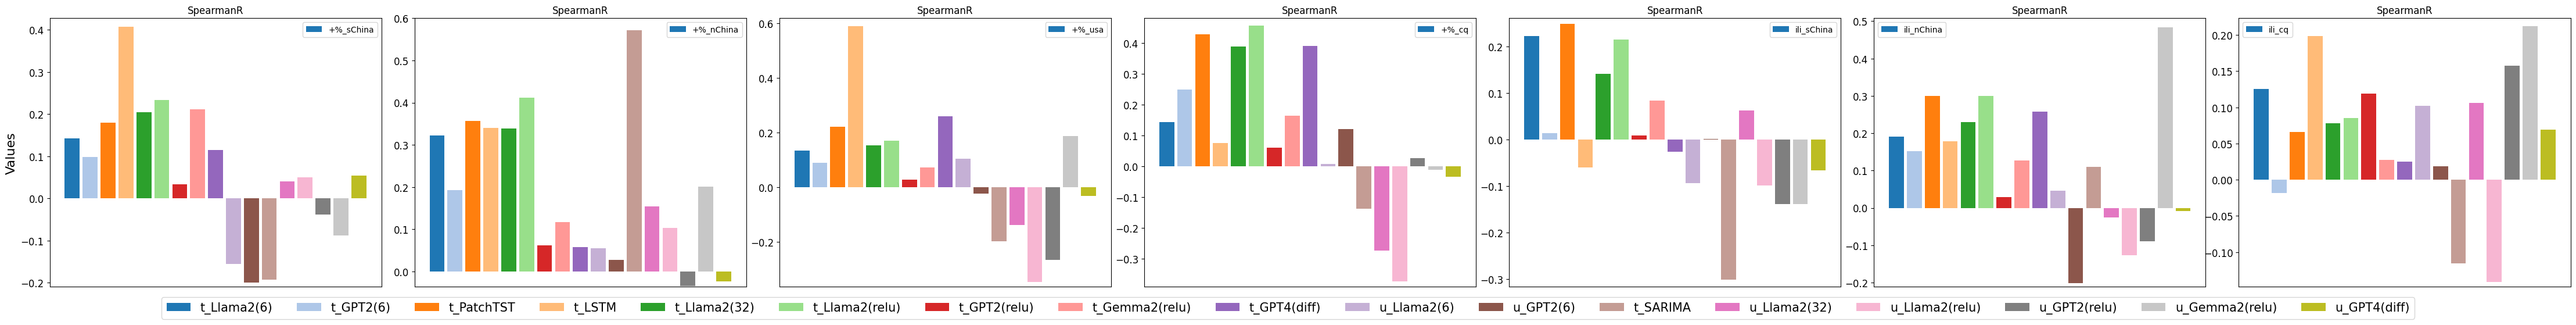

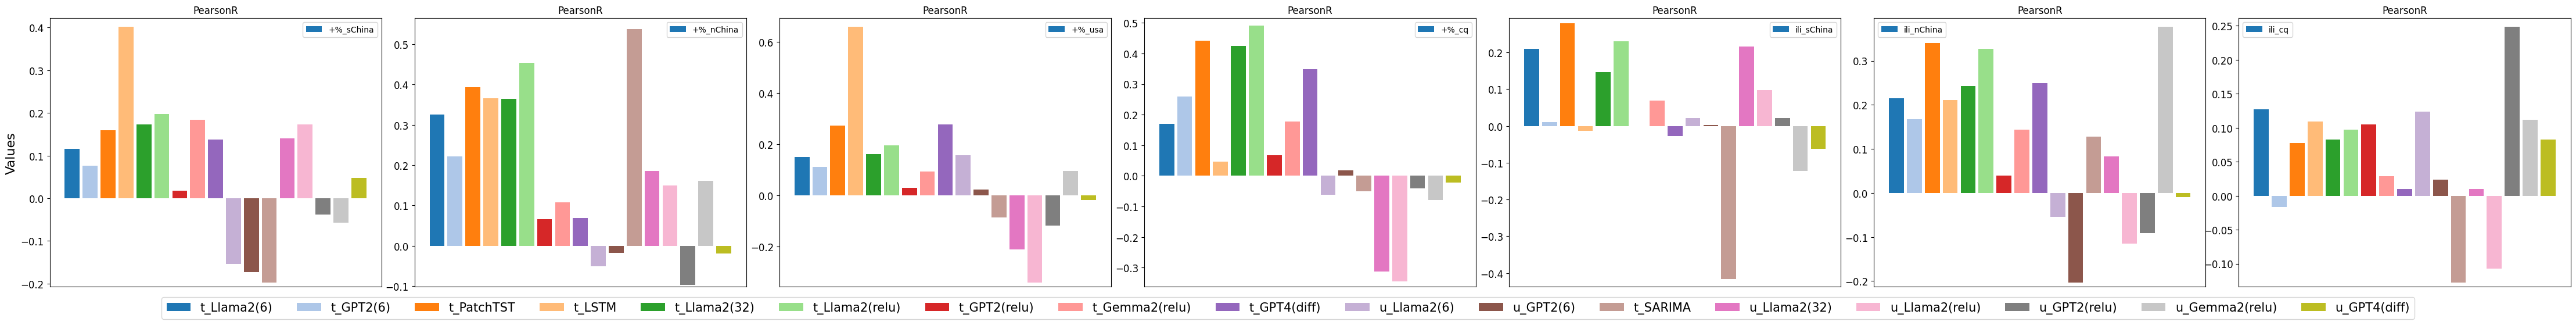

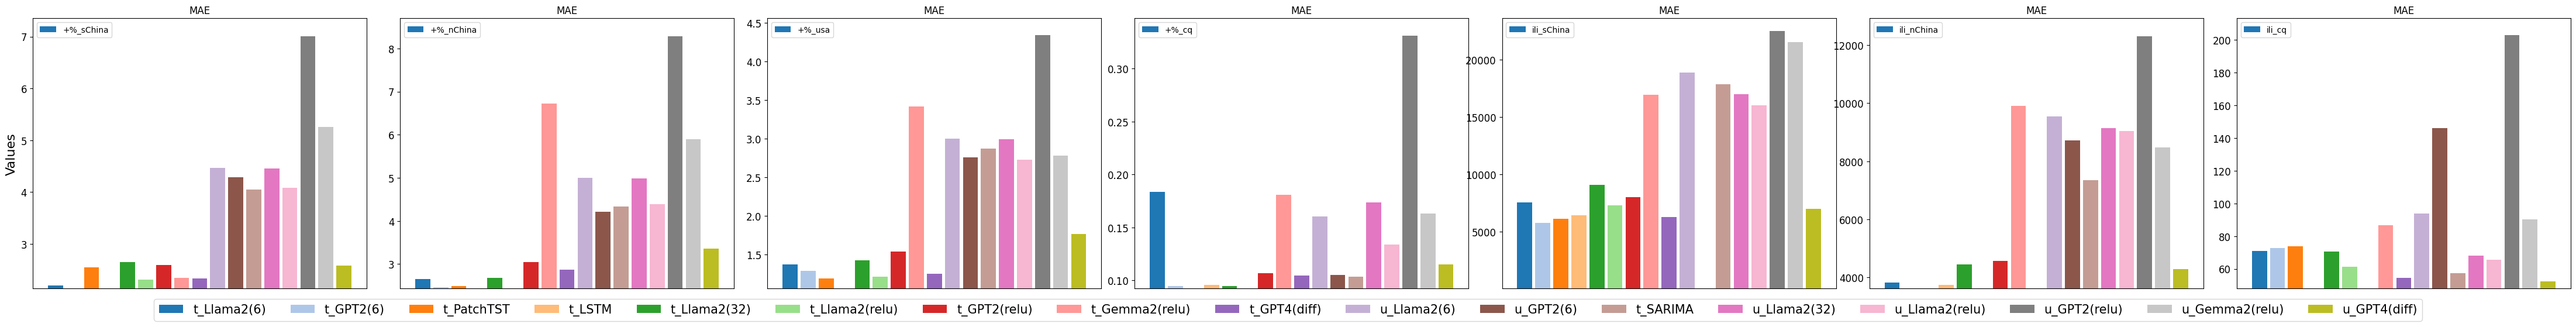

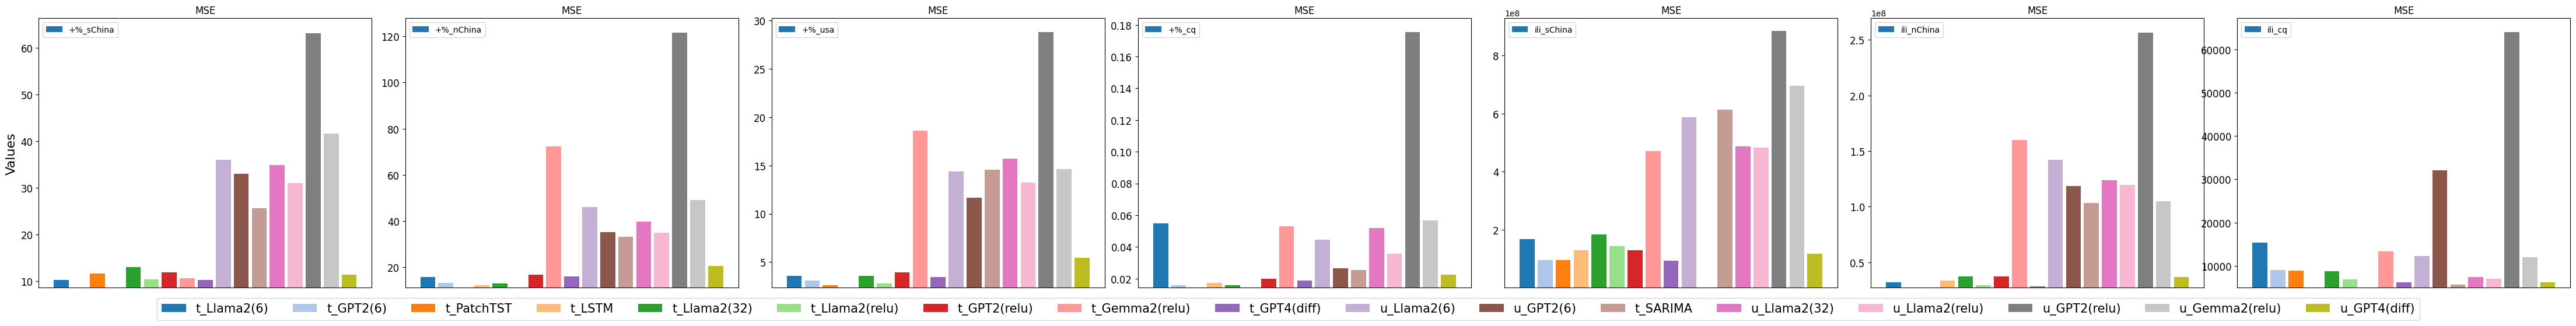

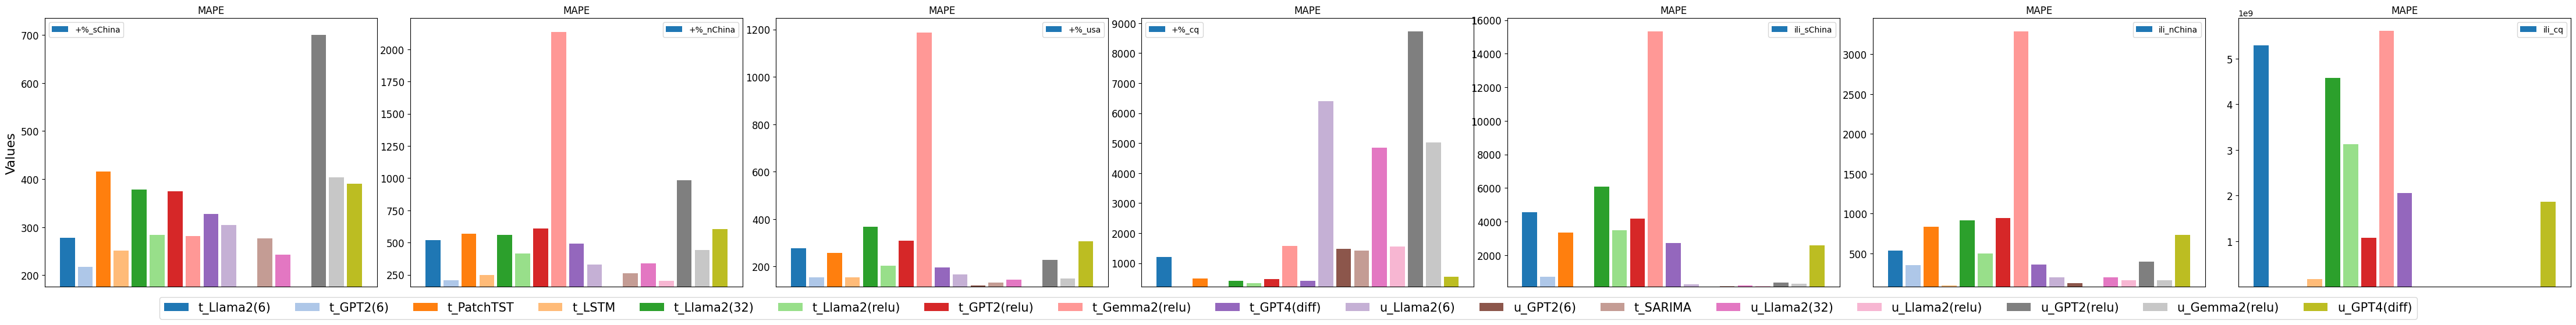

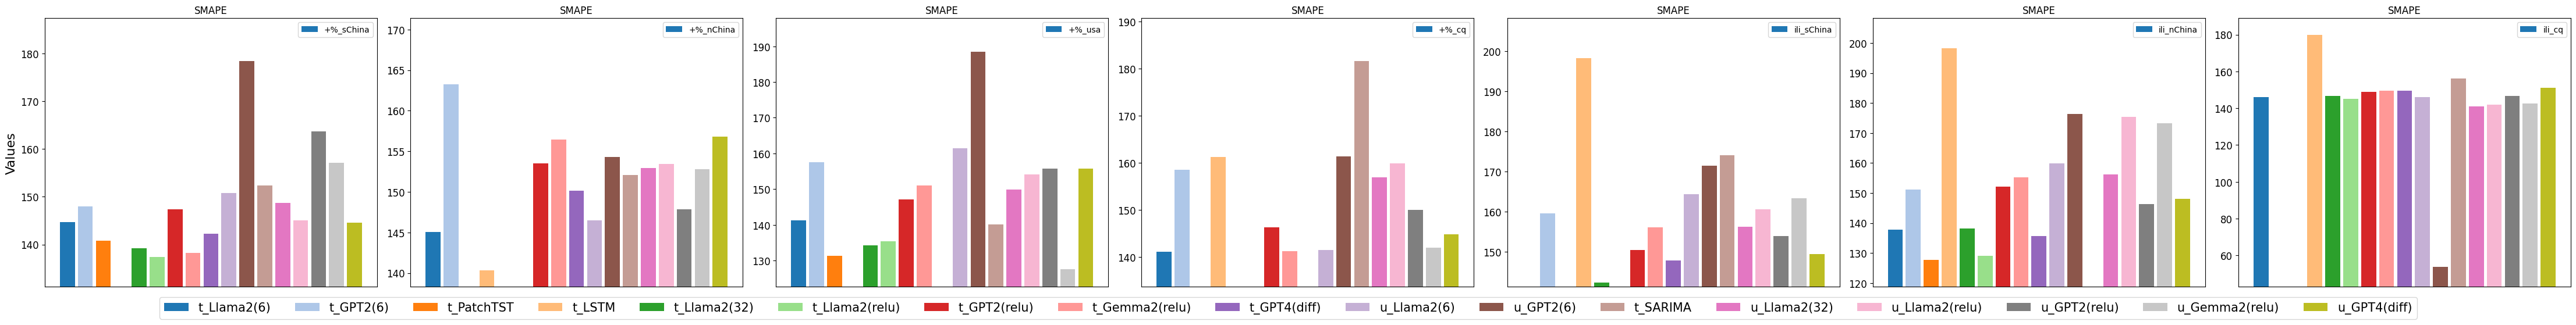

In [11]:
# diff
visual(df1, '/data_disk/lichx/GPT4/diff_with_space/visual')

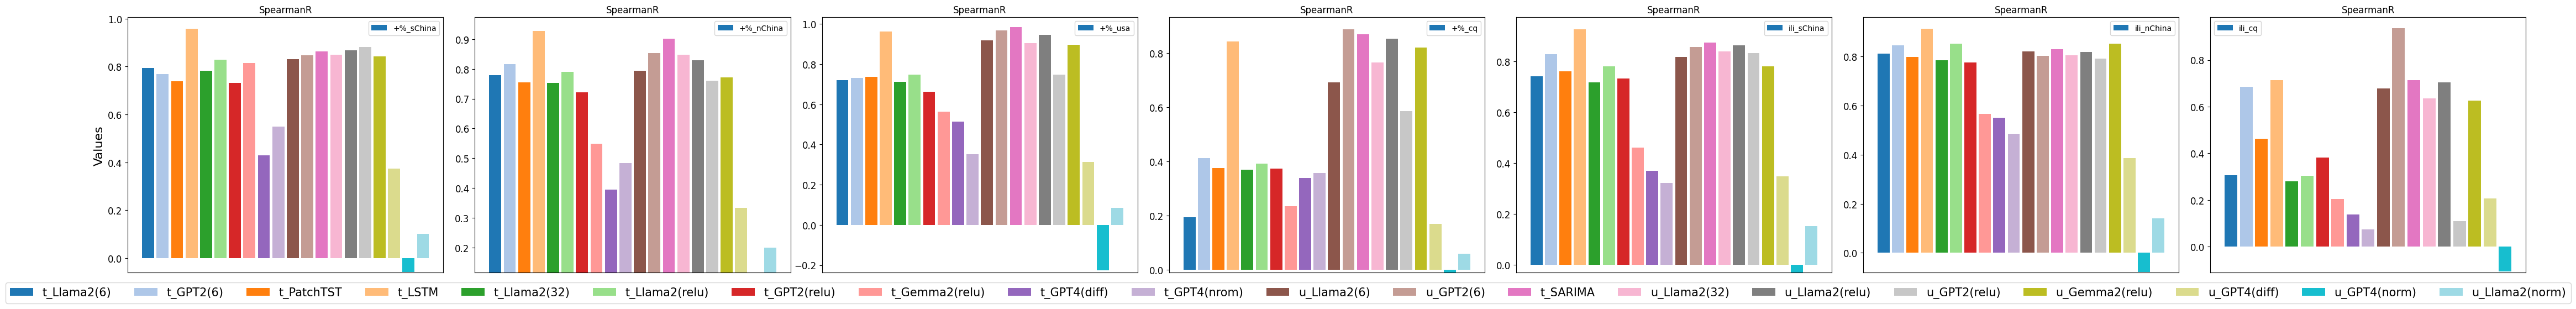

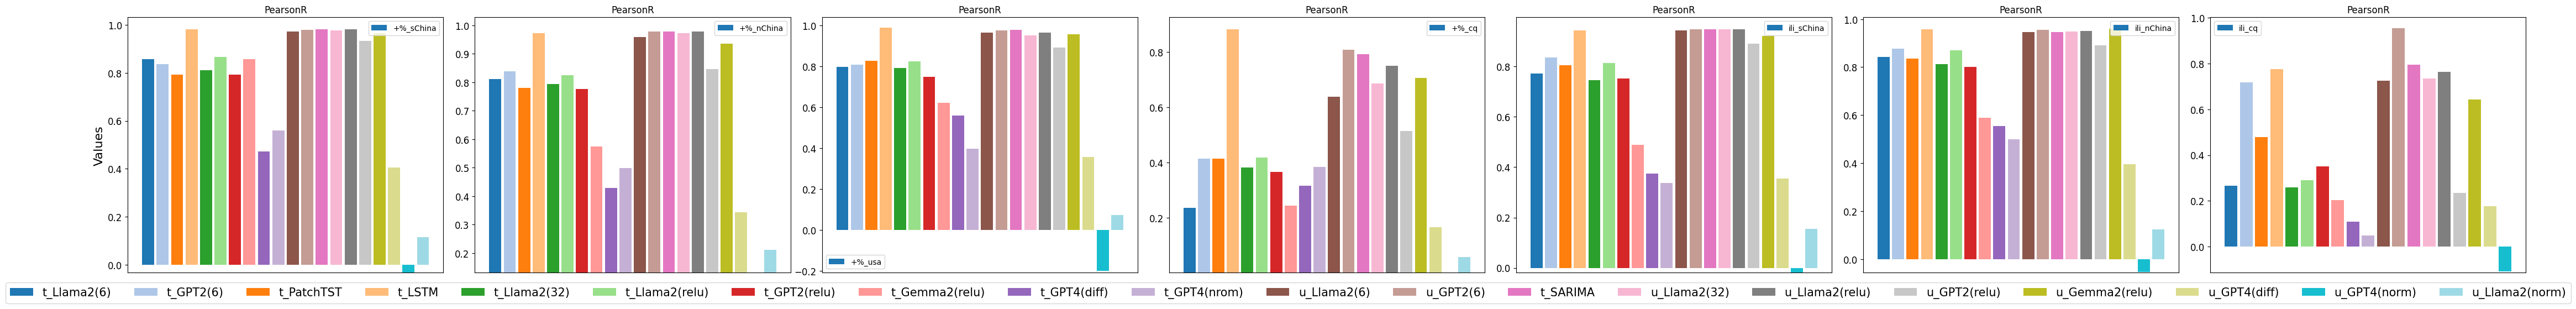

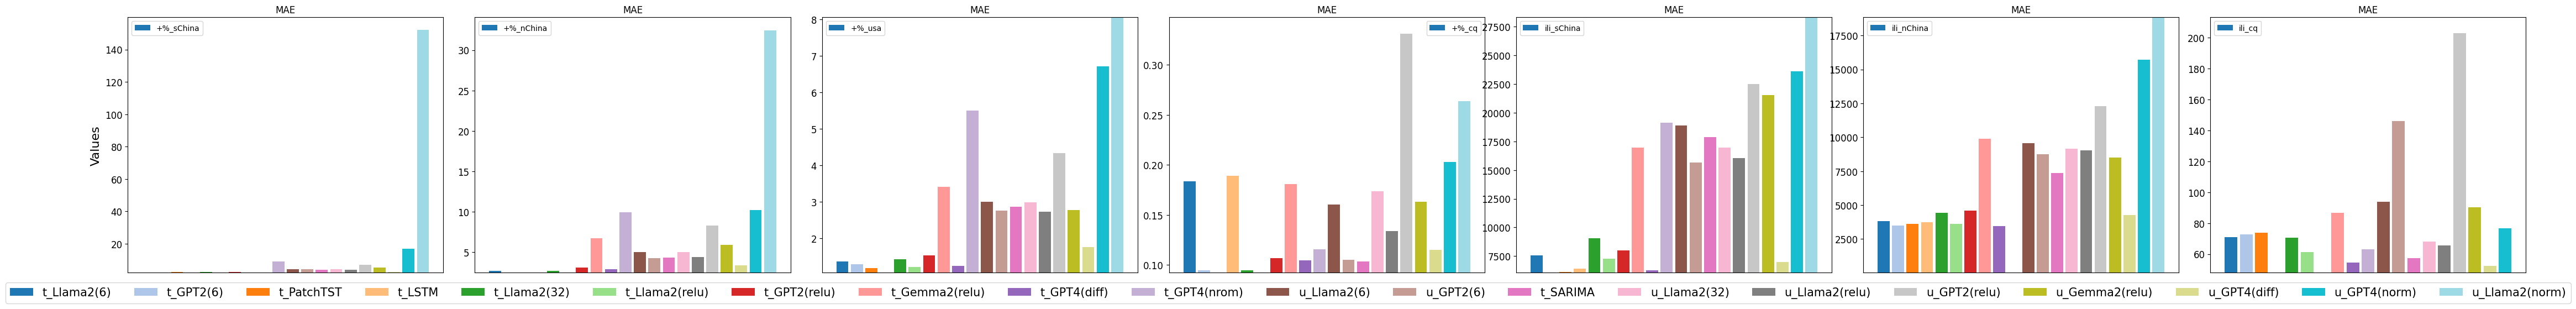

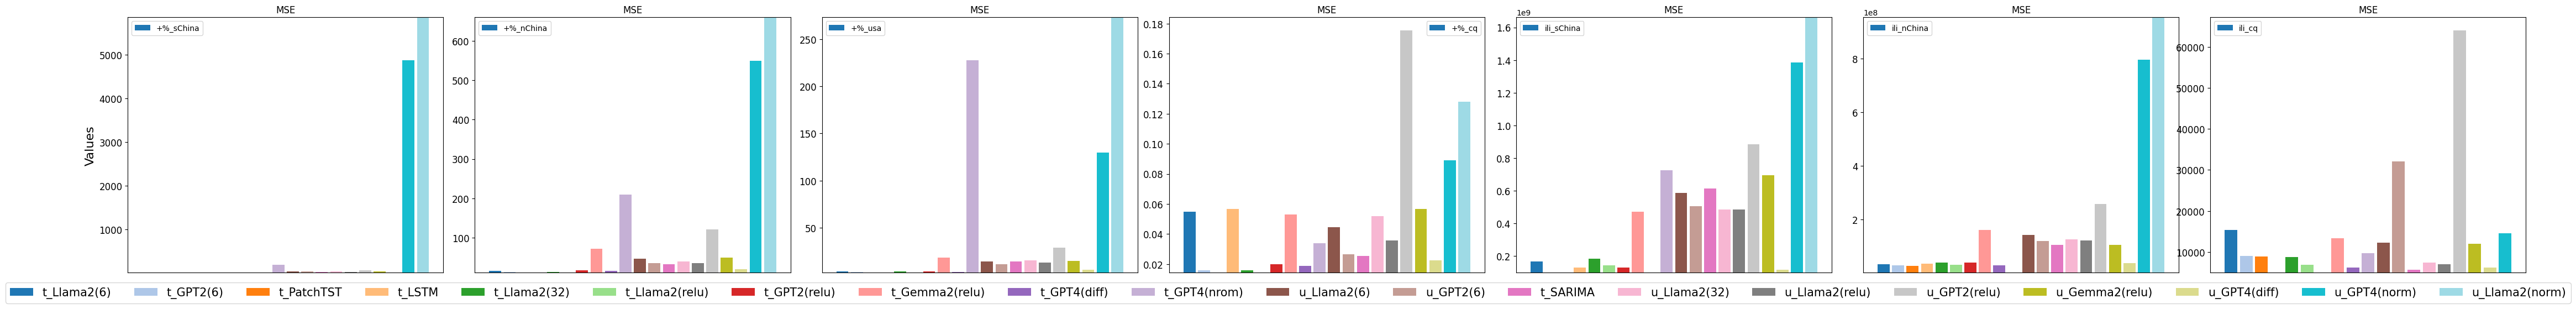

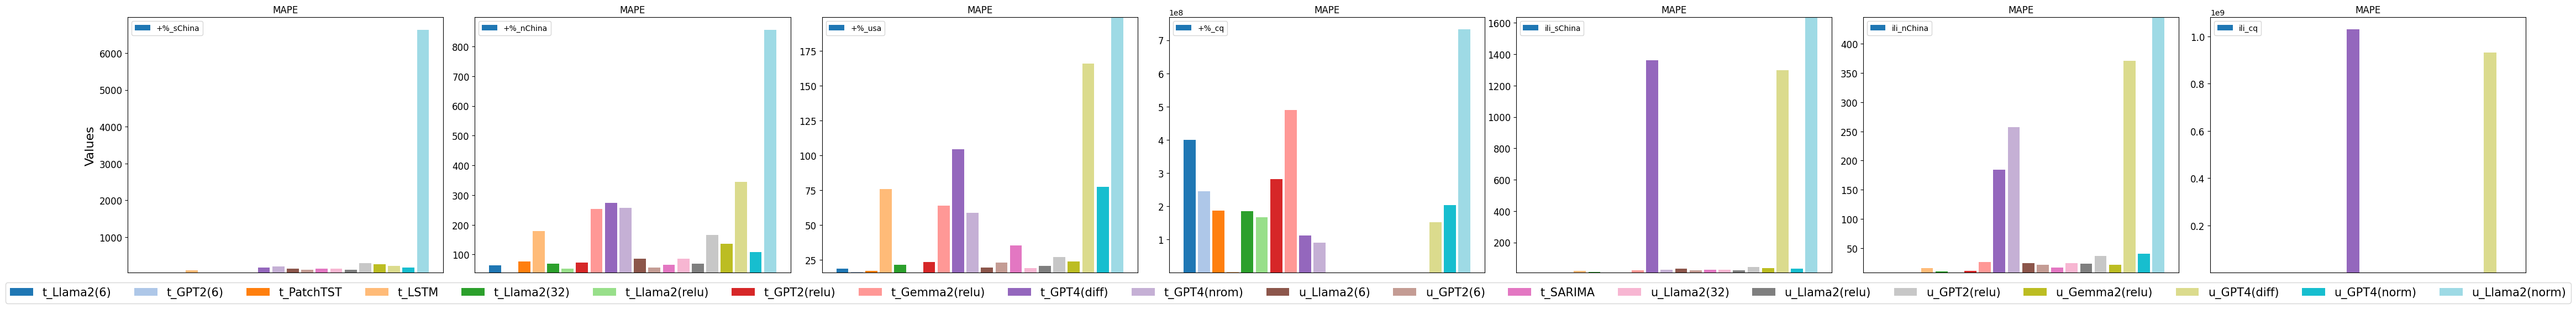

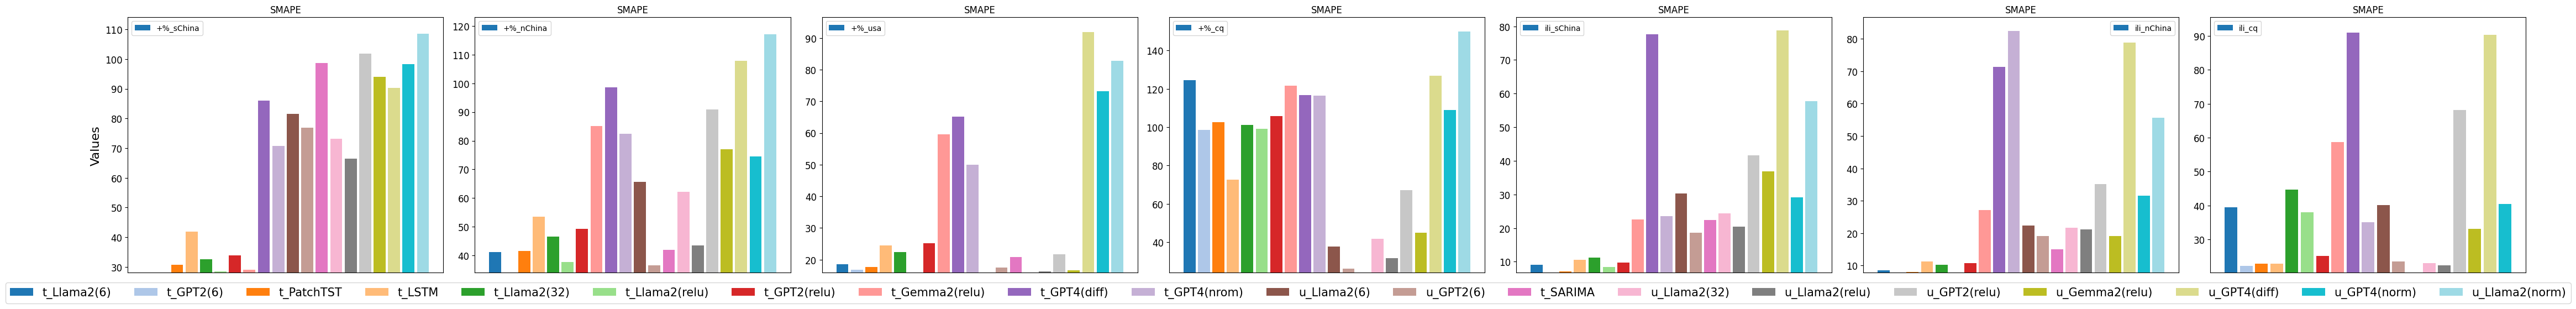

In [12]:
# inverse
visual(df2, '/data_disk/lichx/GPT4/norm_with_space/visual')

## Tuned

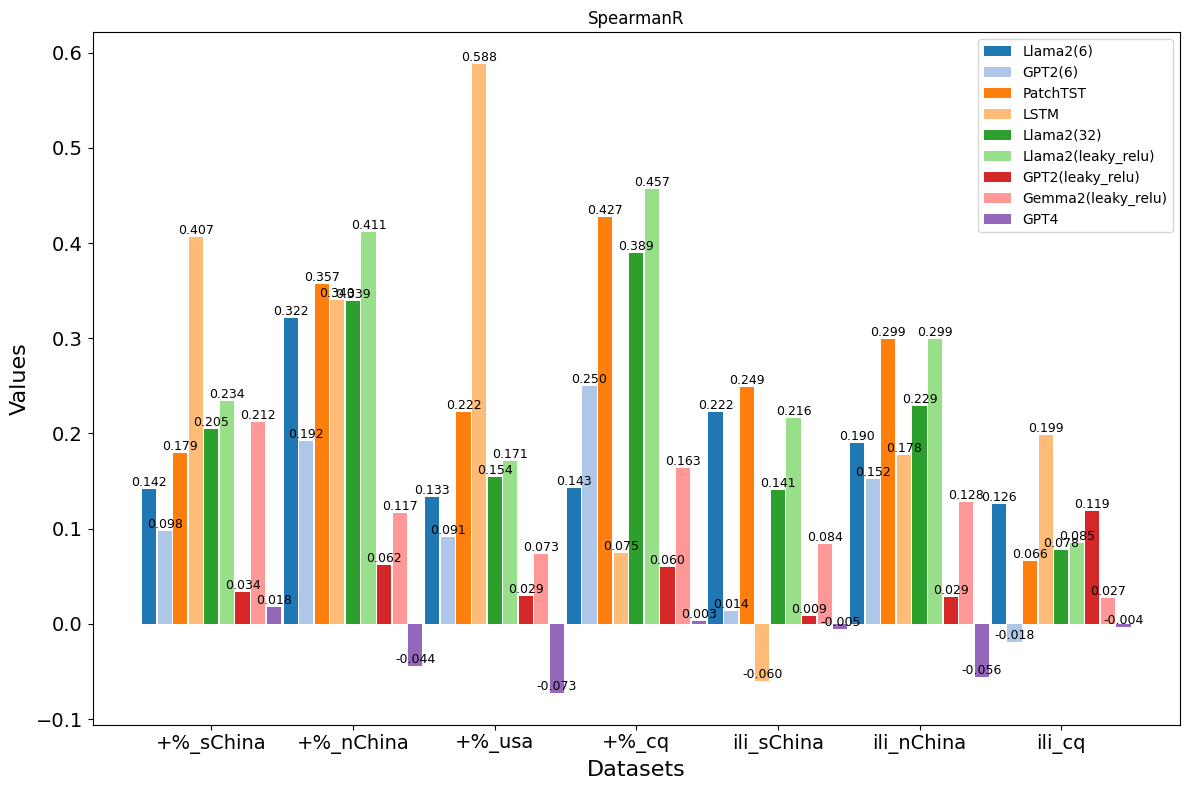

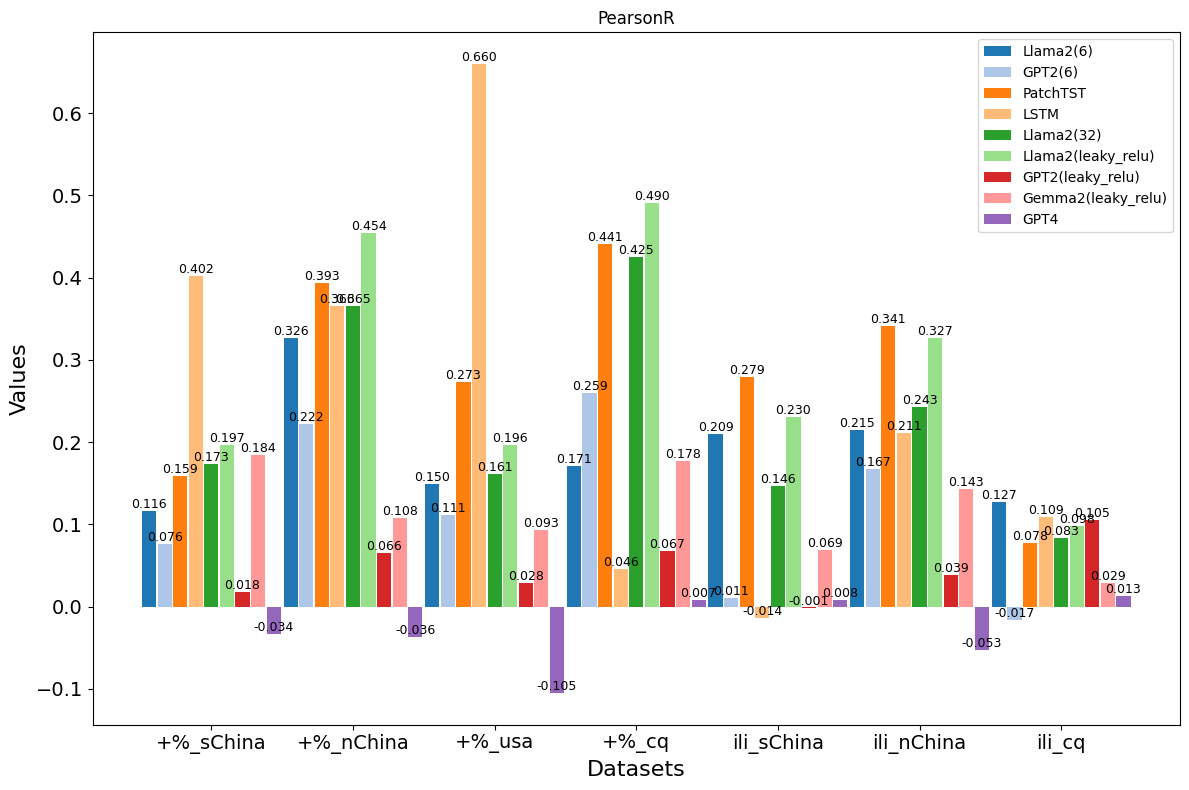

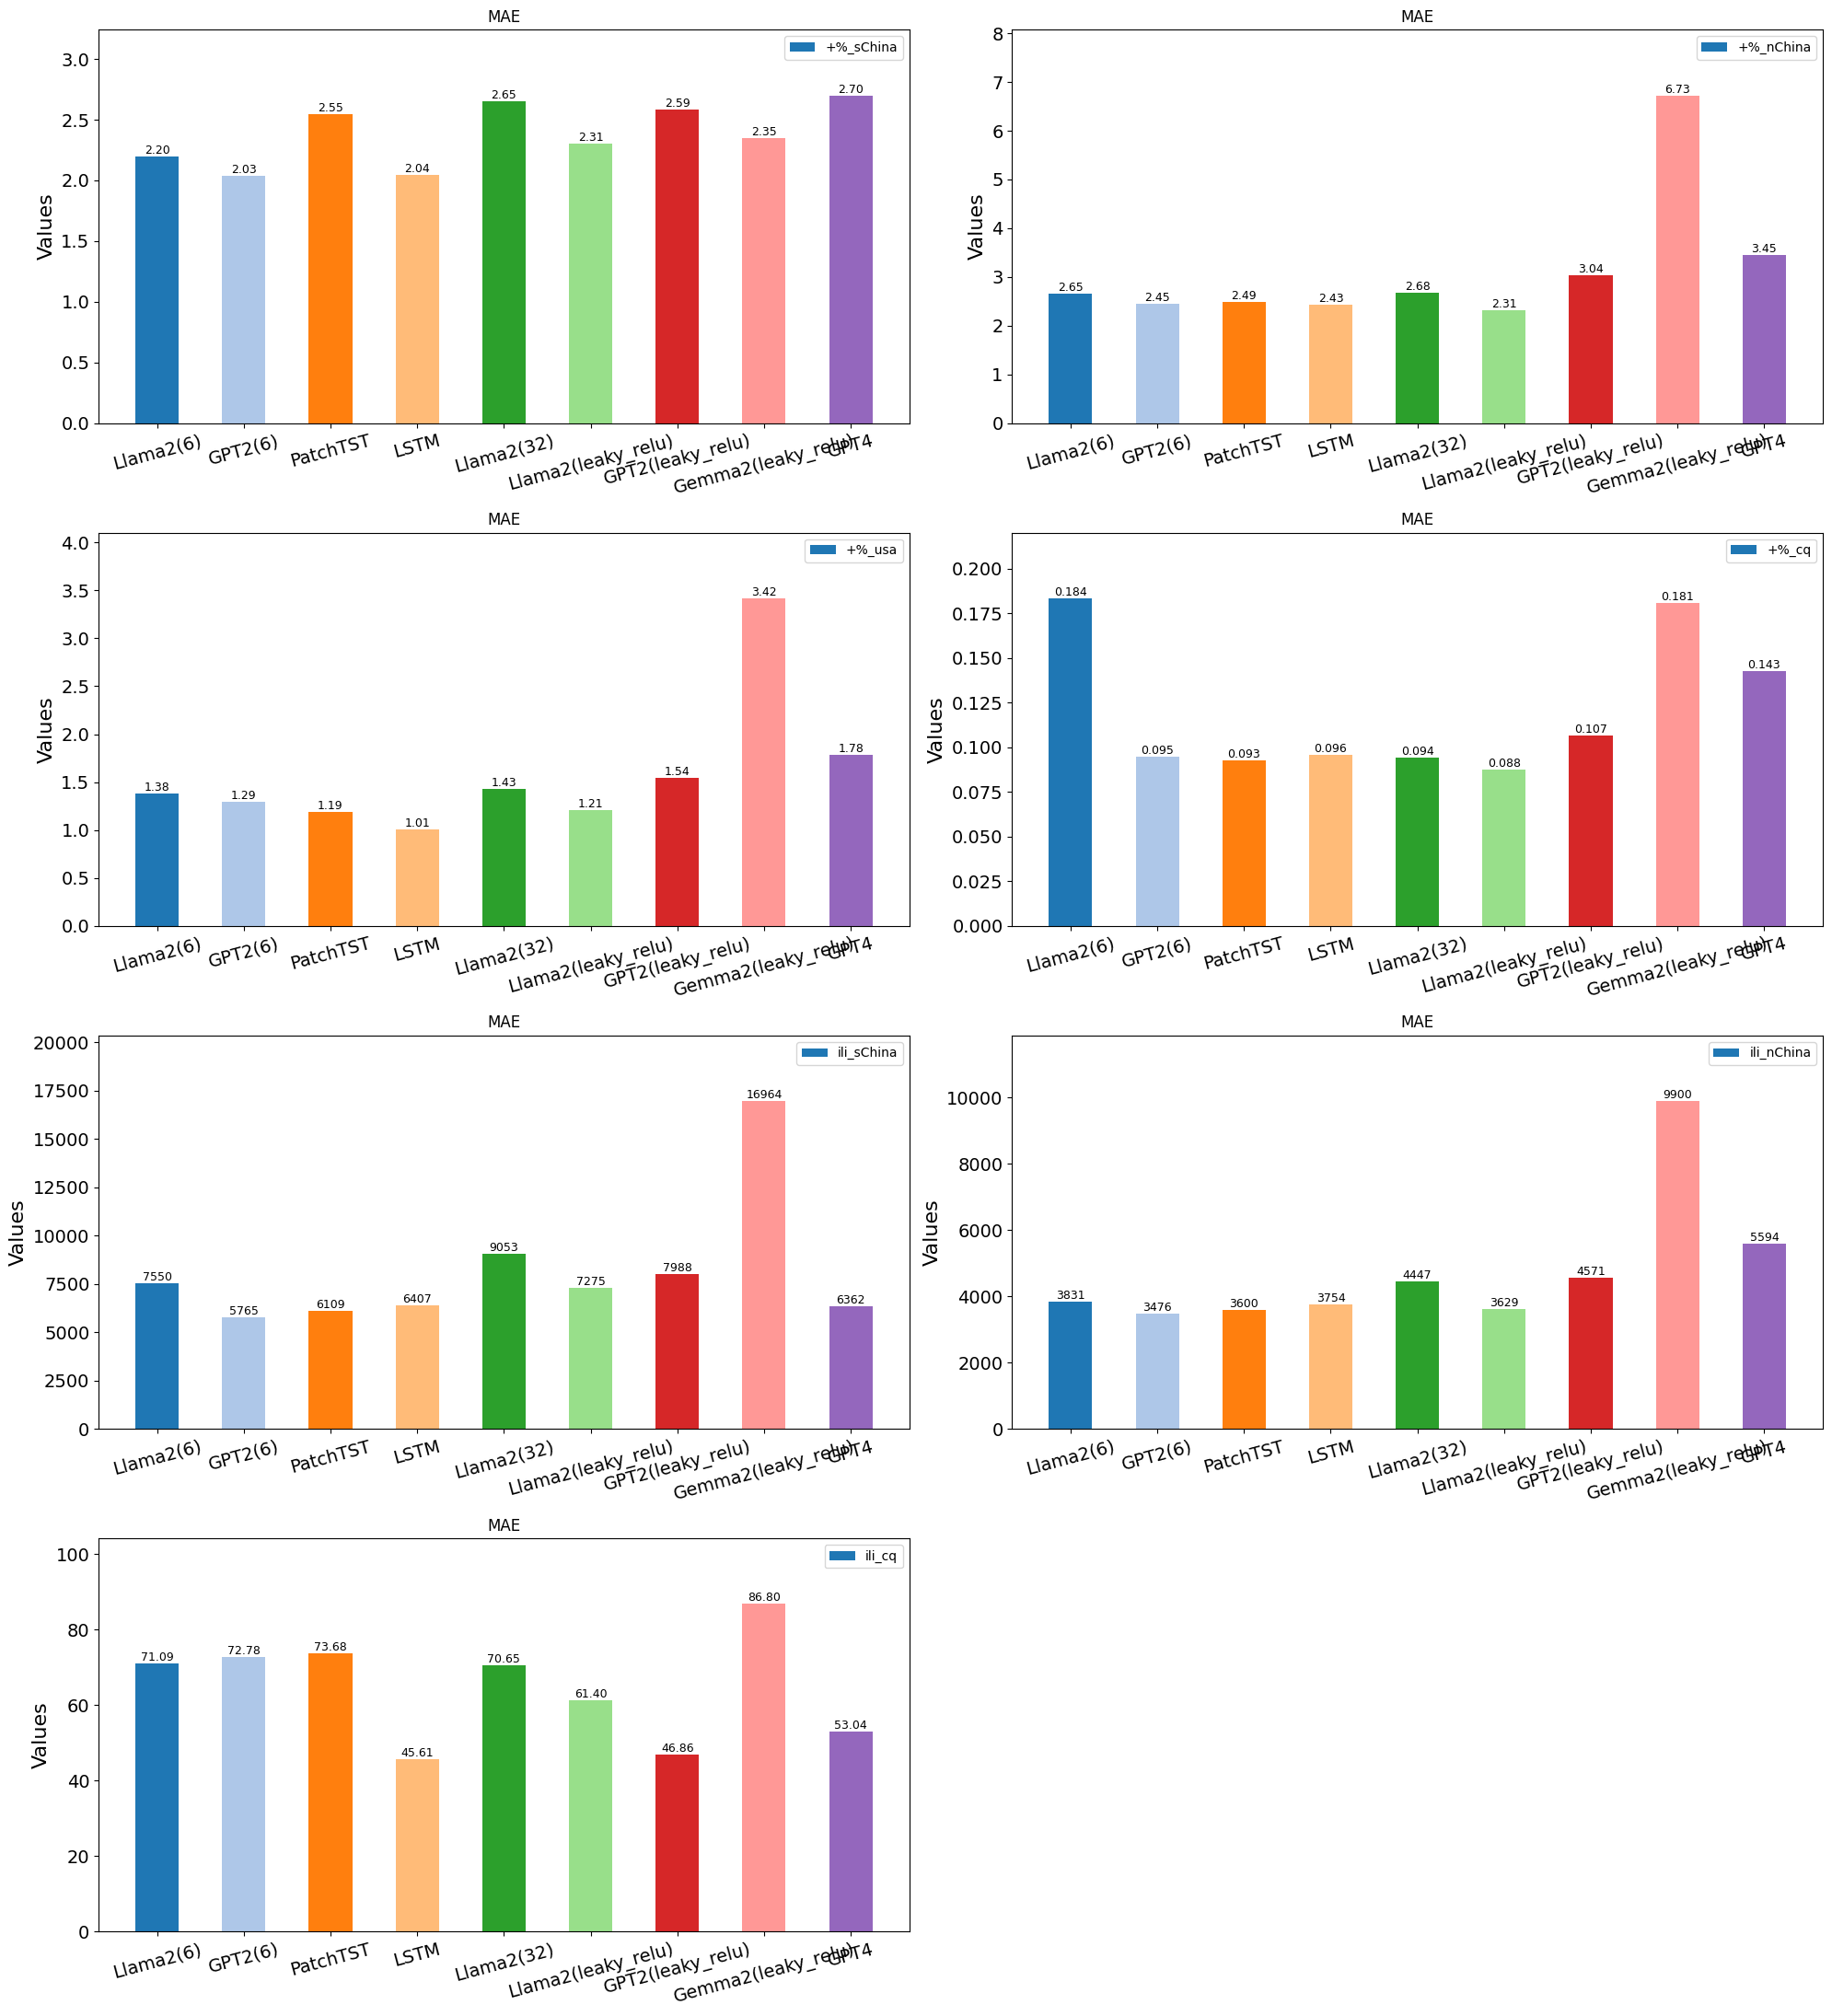

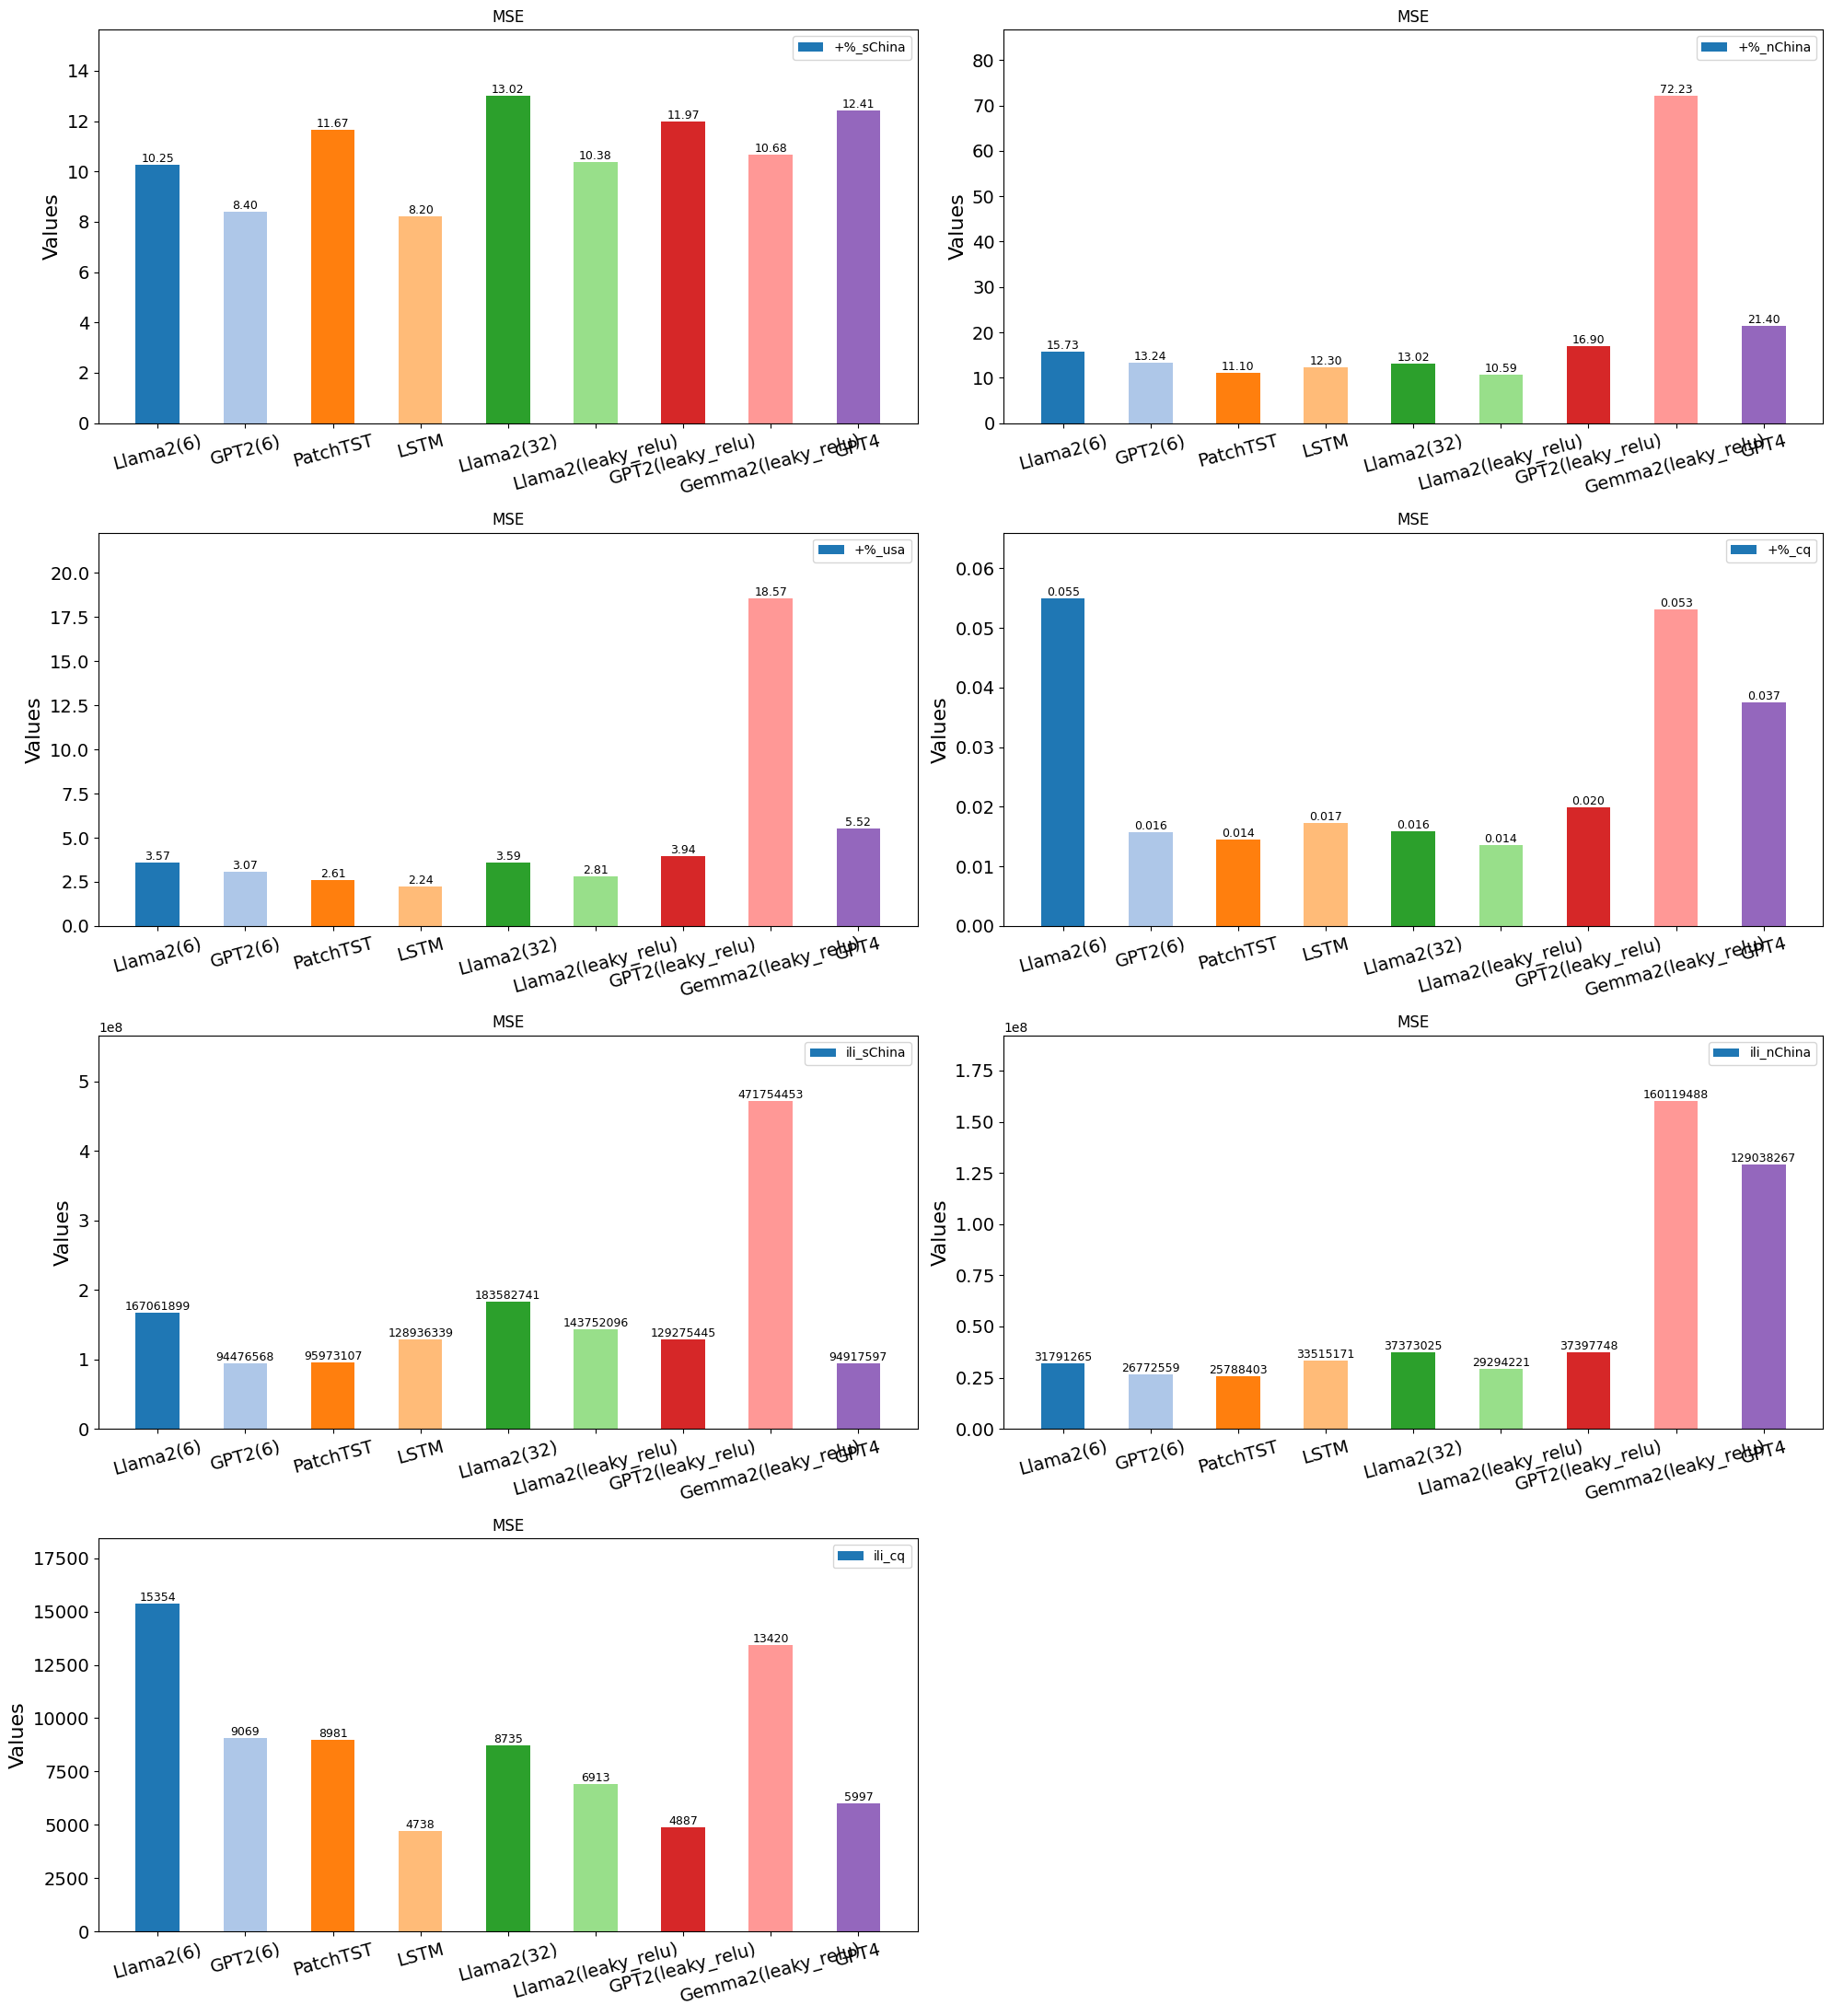

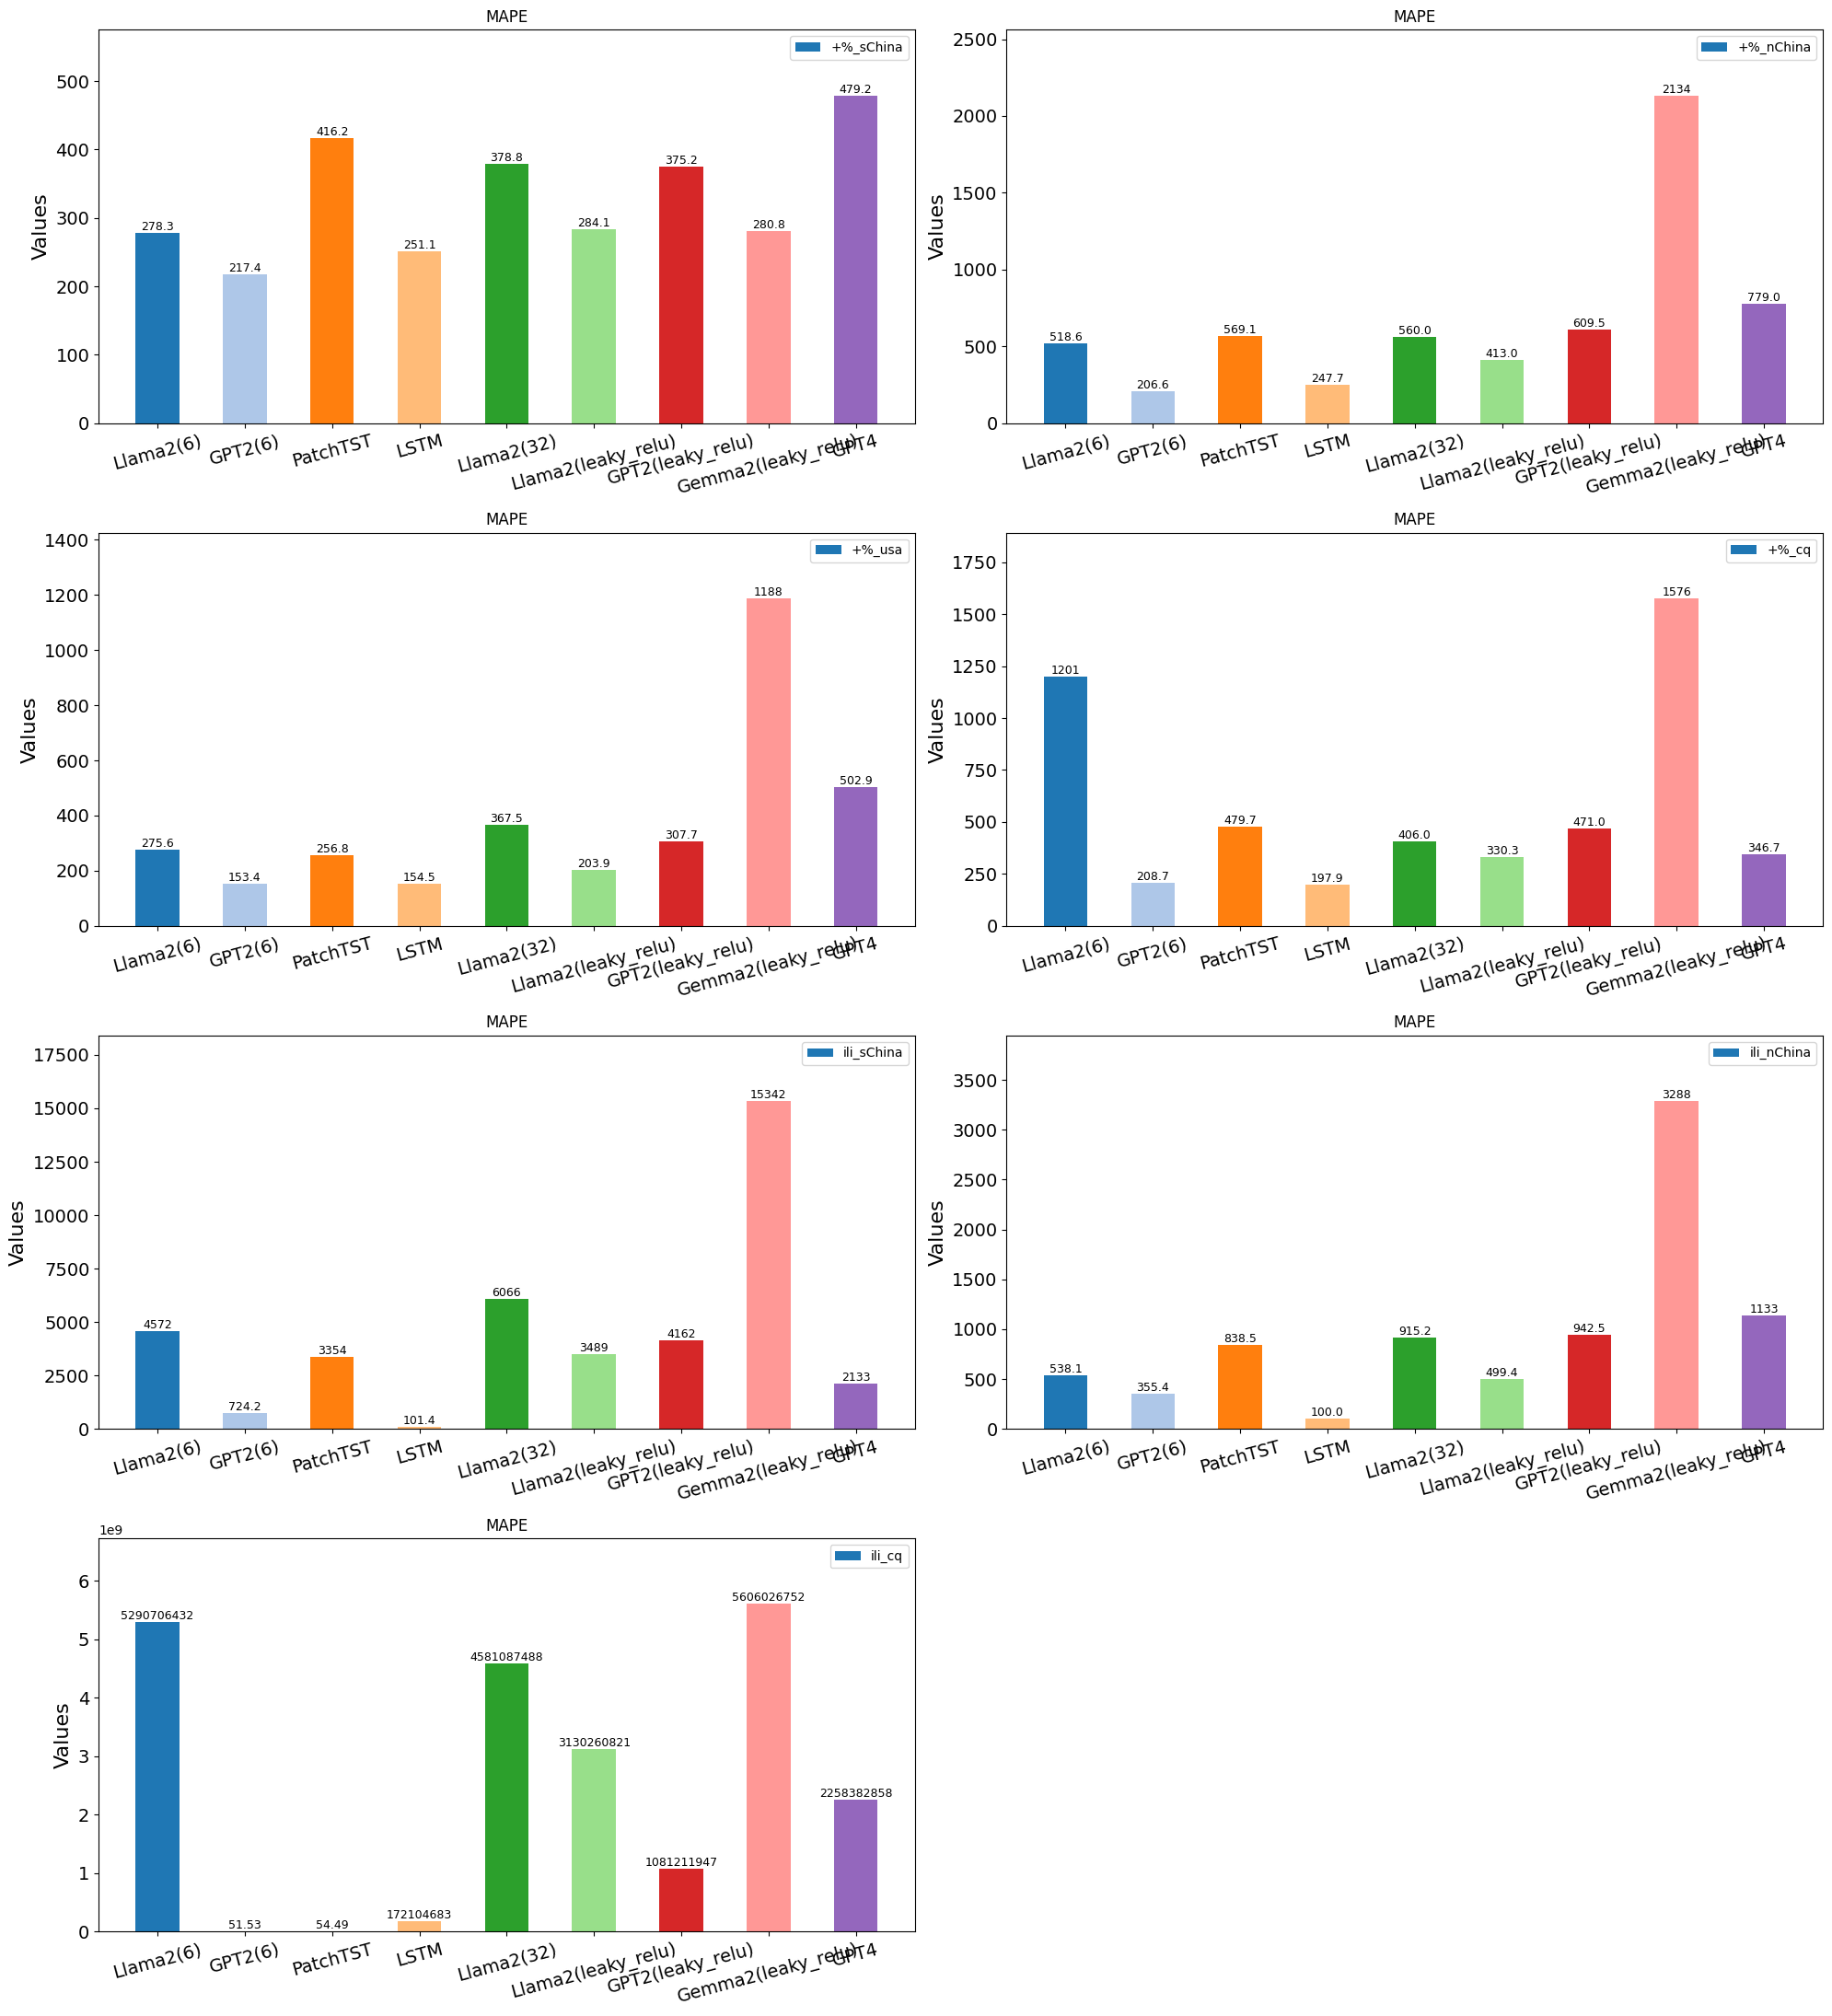

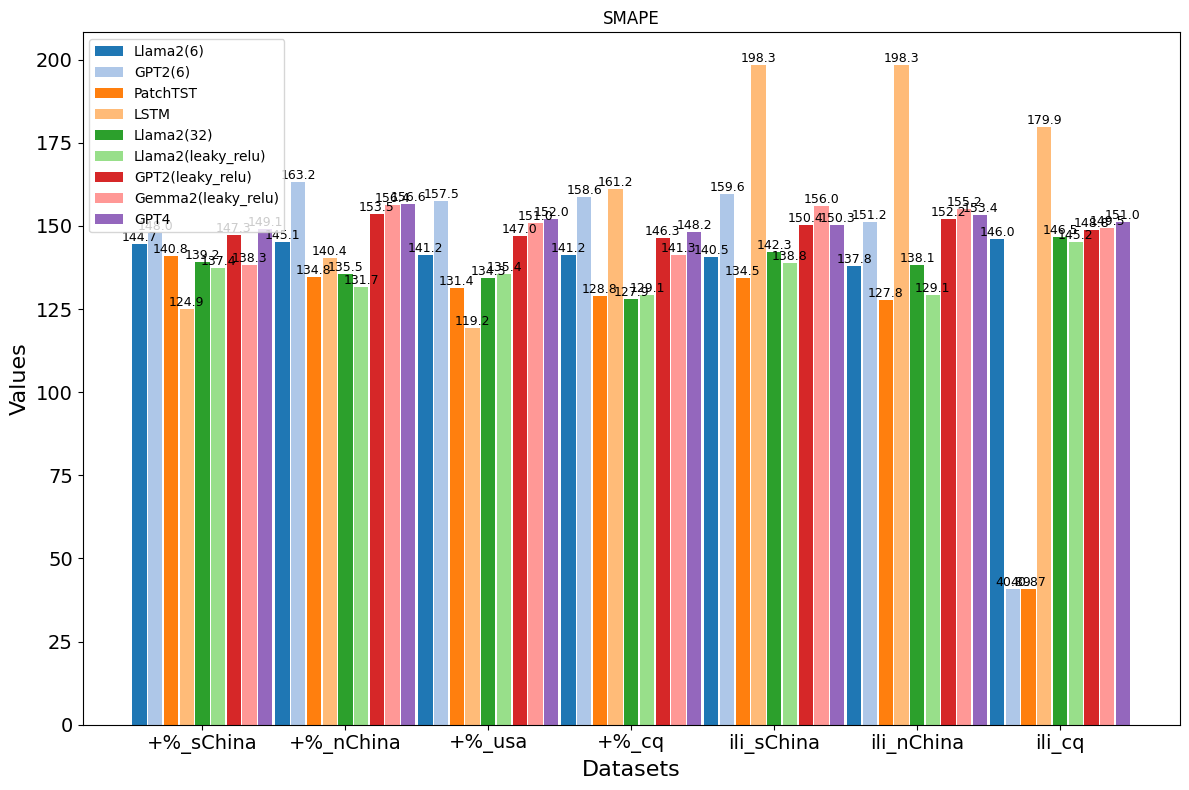

In [10]:
## diff
visual1(dt1, '/data_disk/lichx/NeurIPS2023-One-Fits-All/Long-term_Forecasting/Output/png/train/diff/')

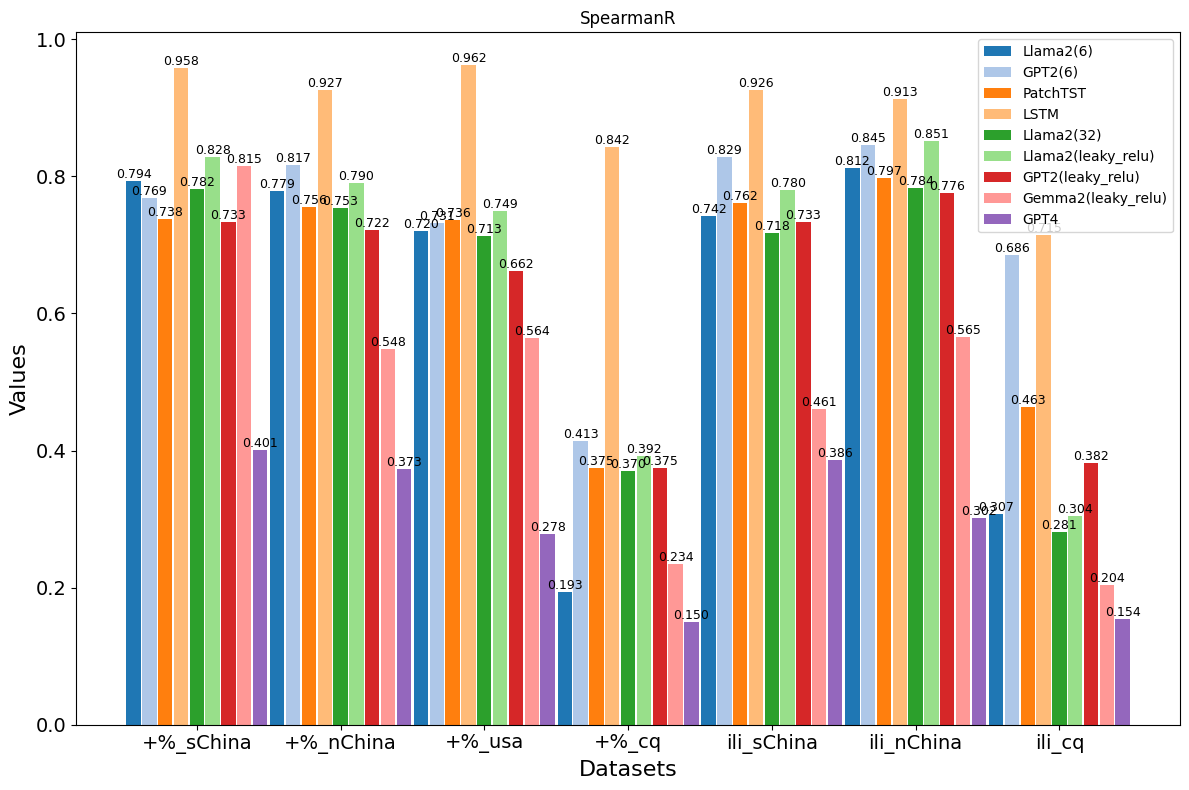

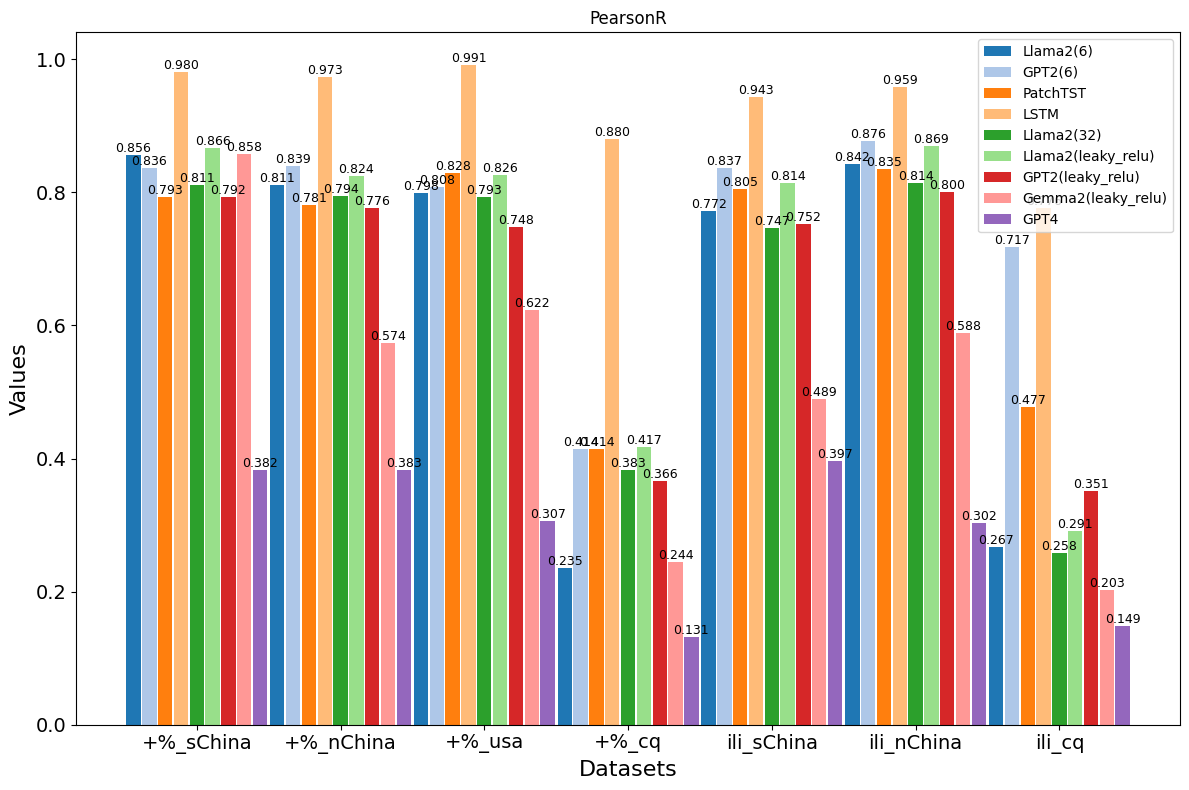

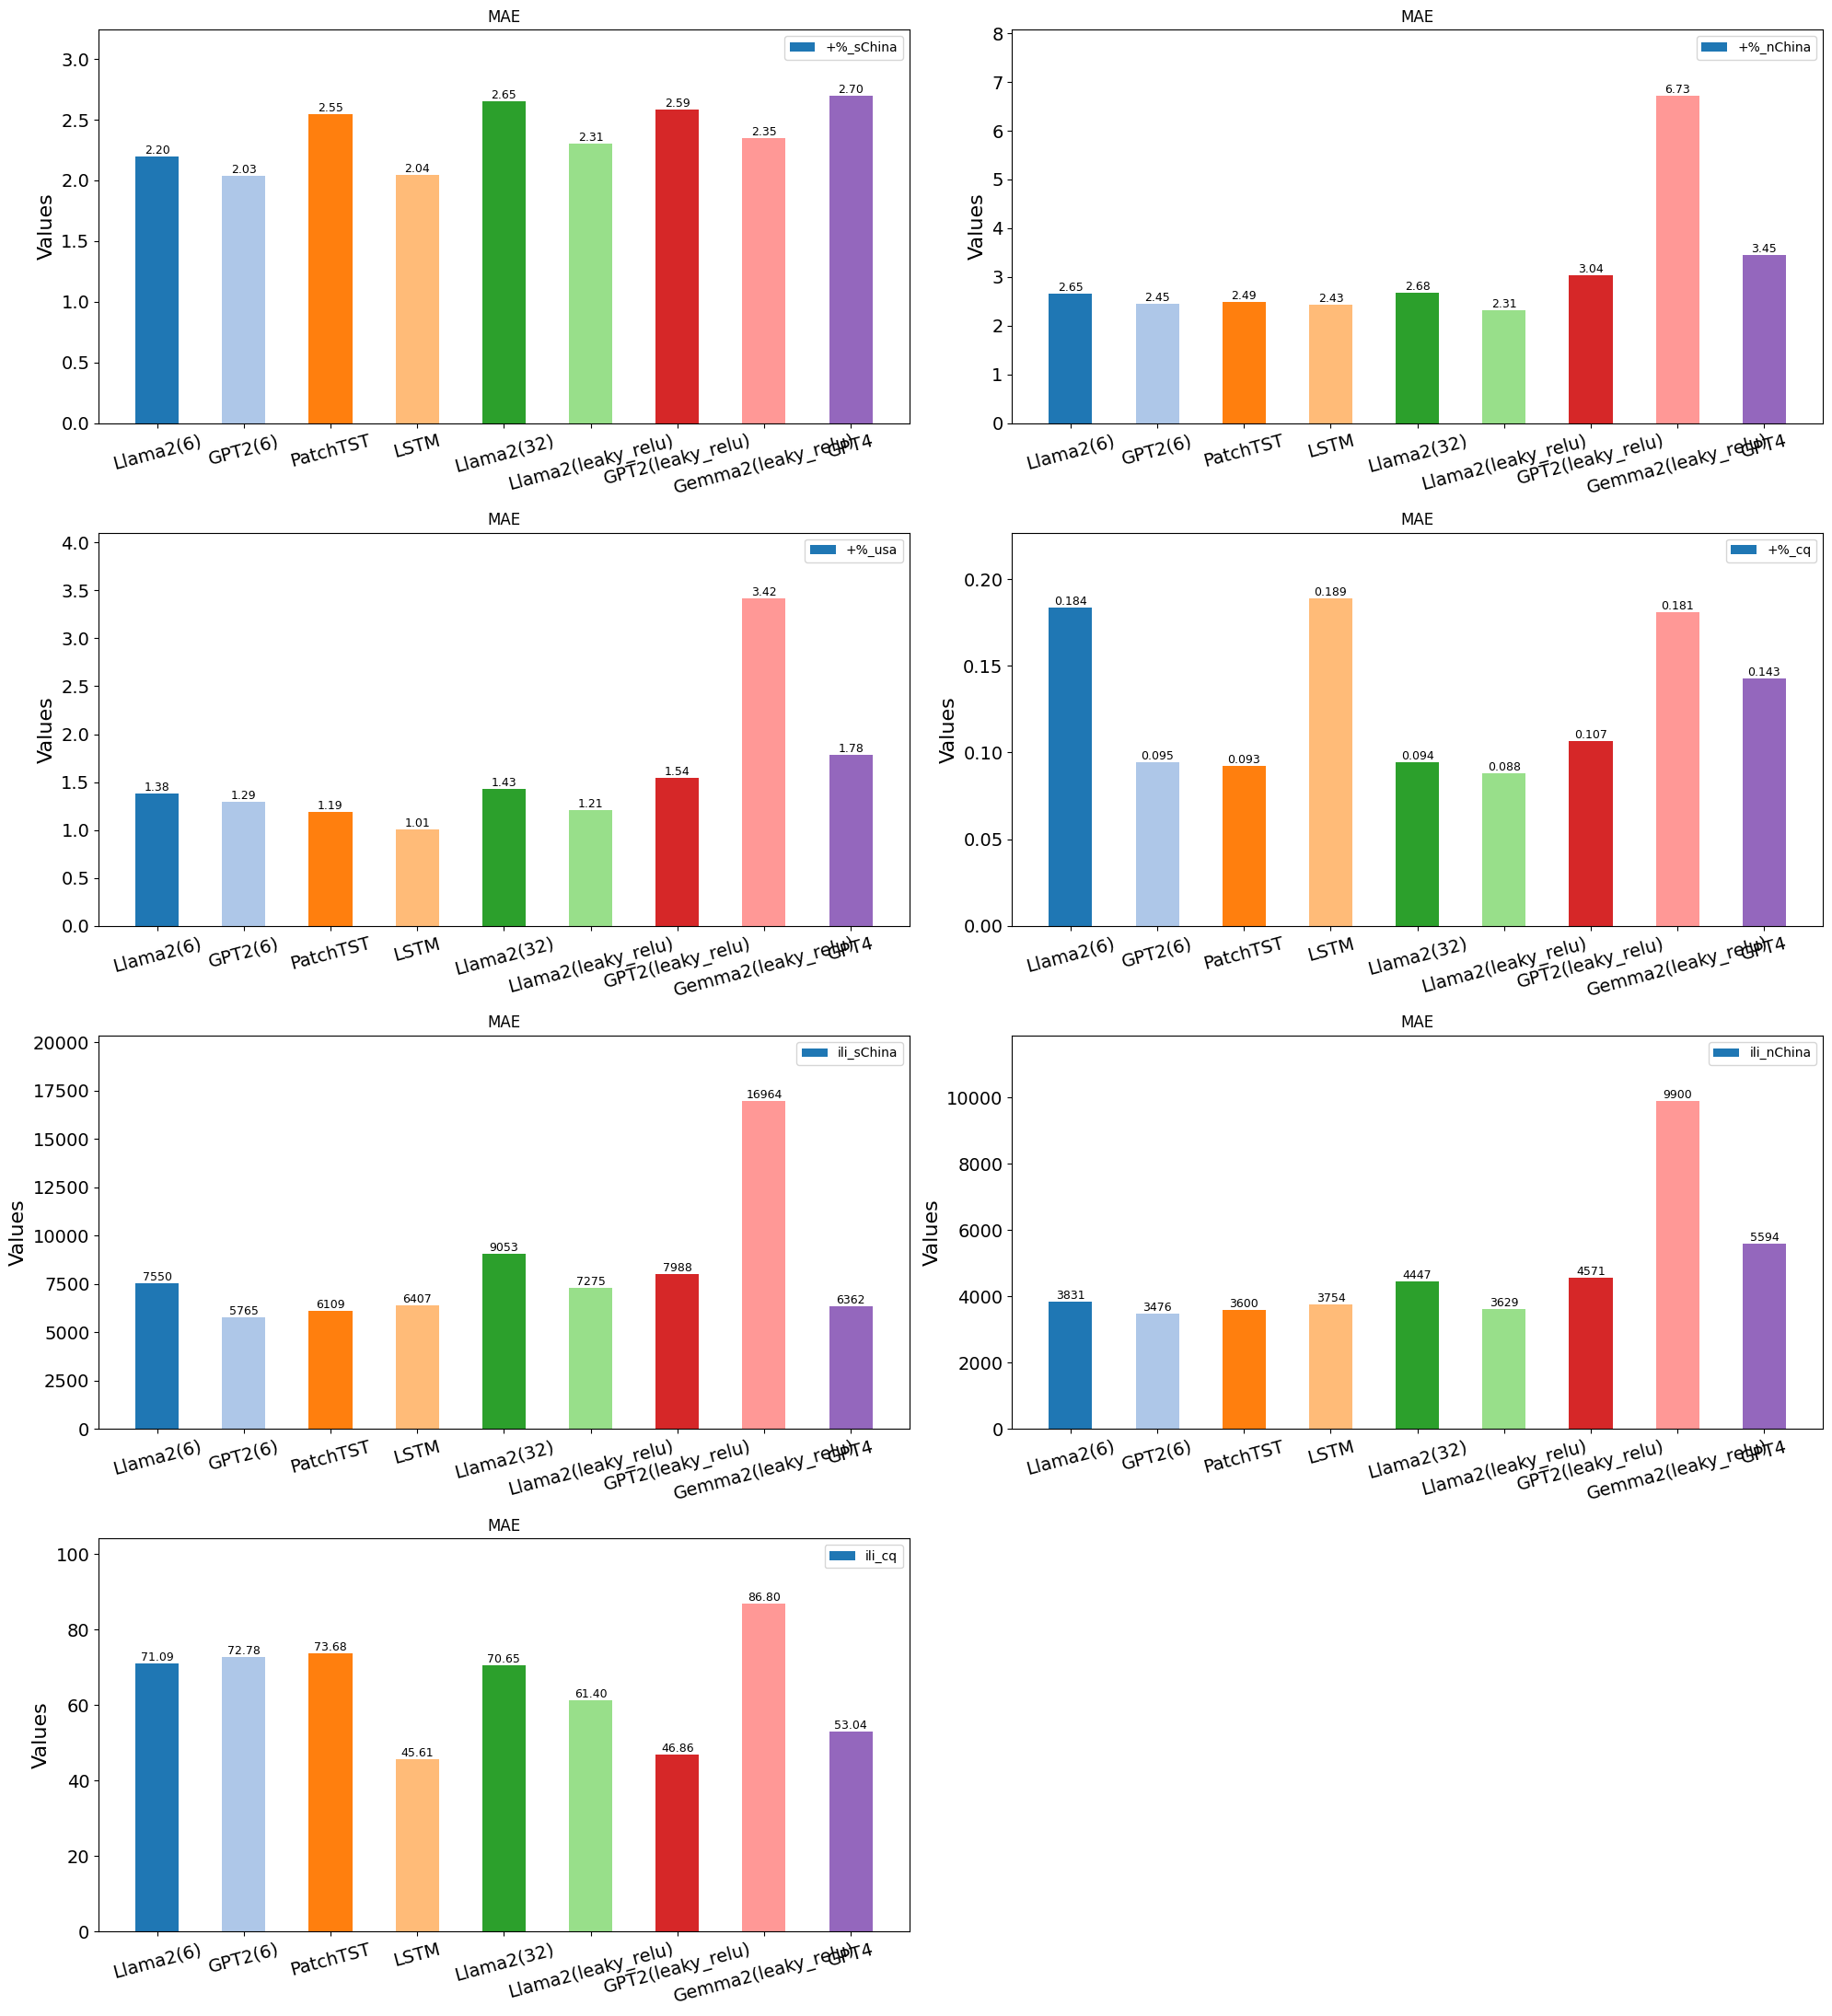

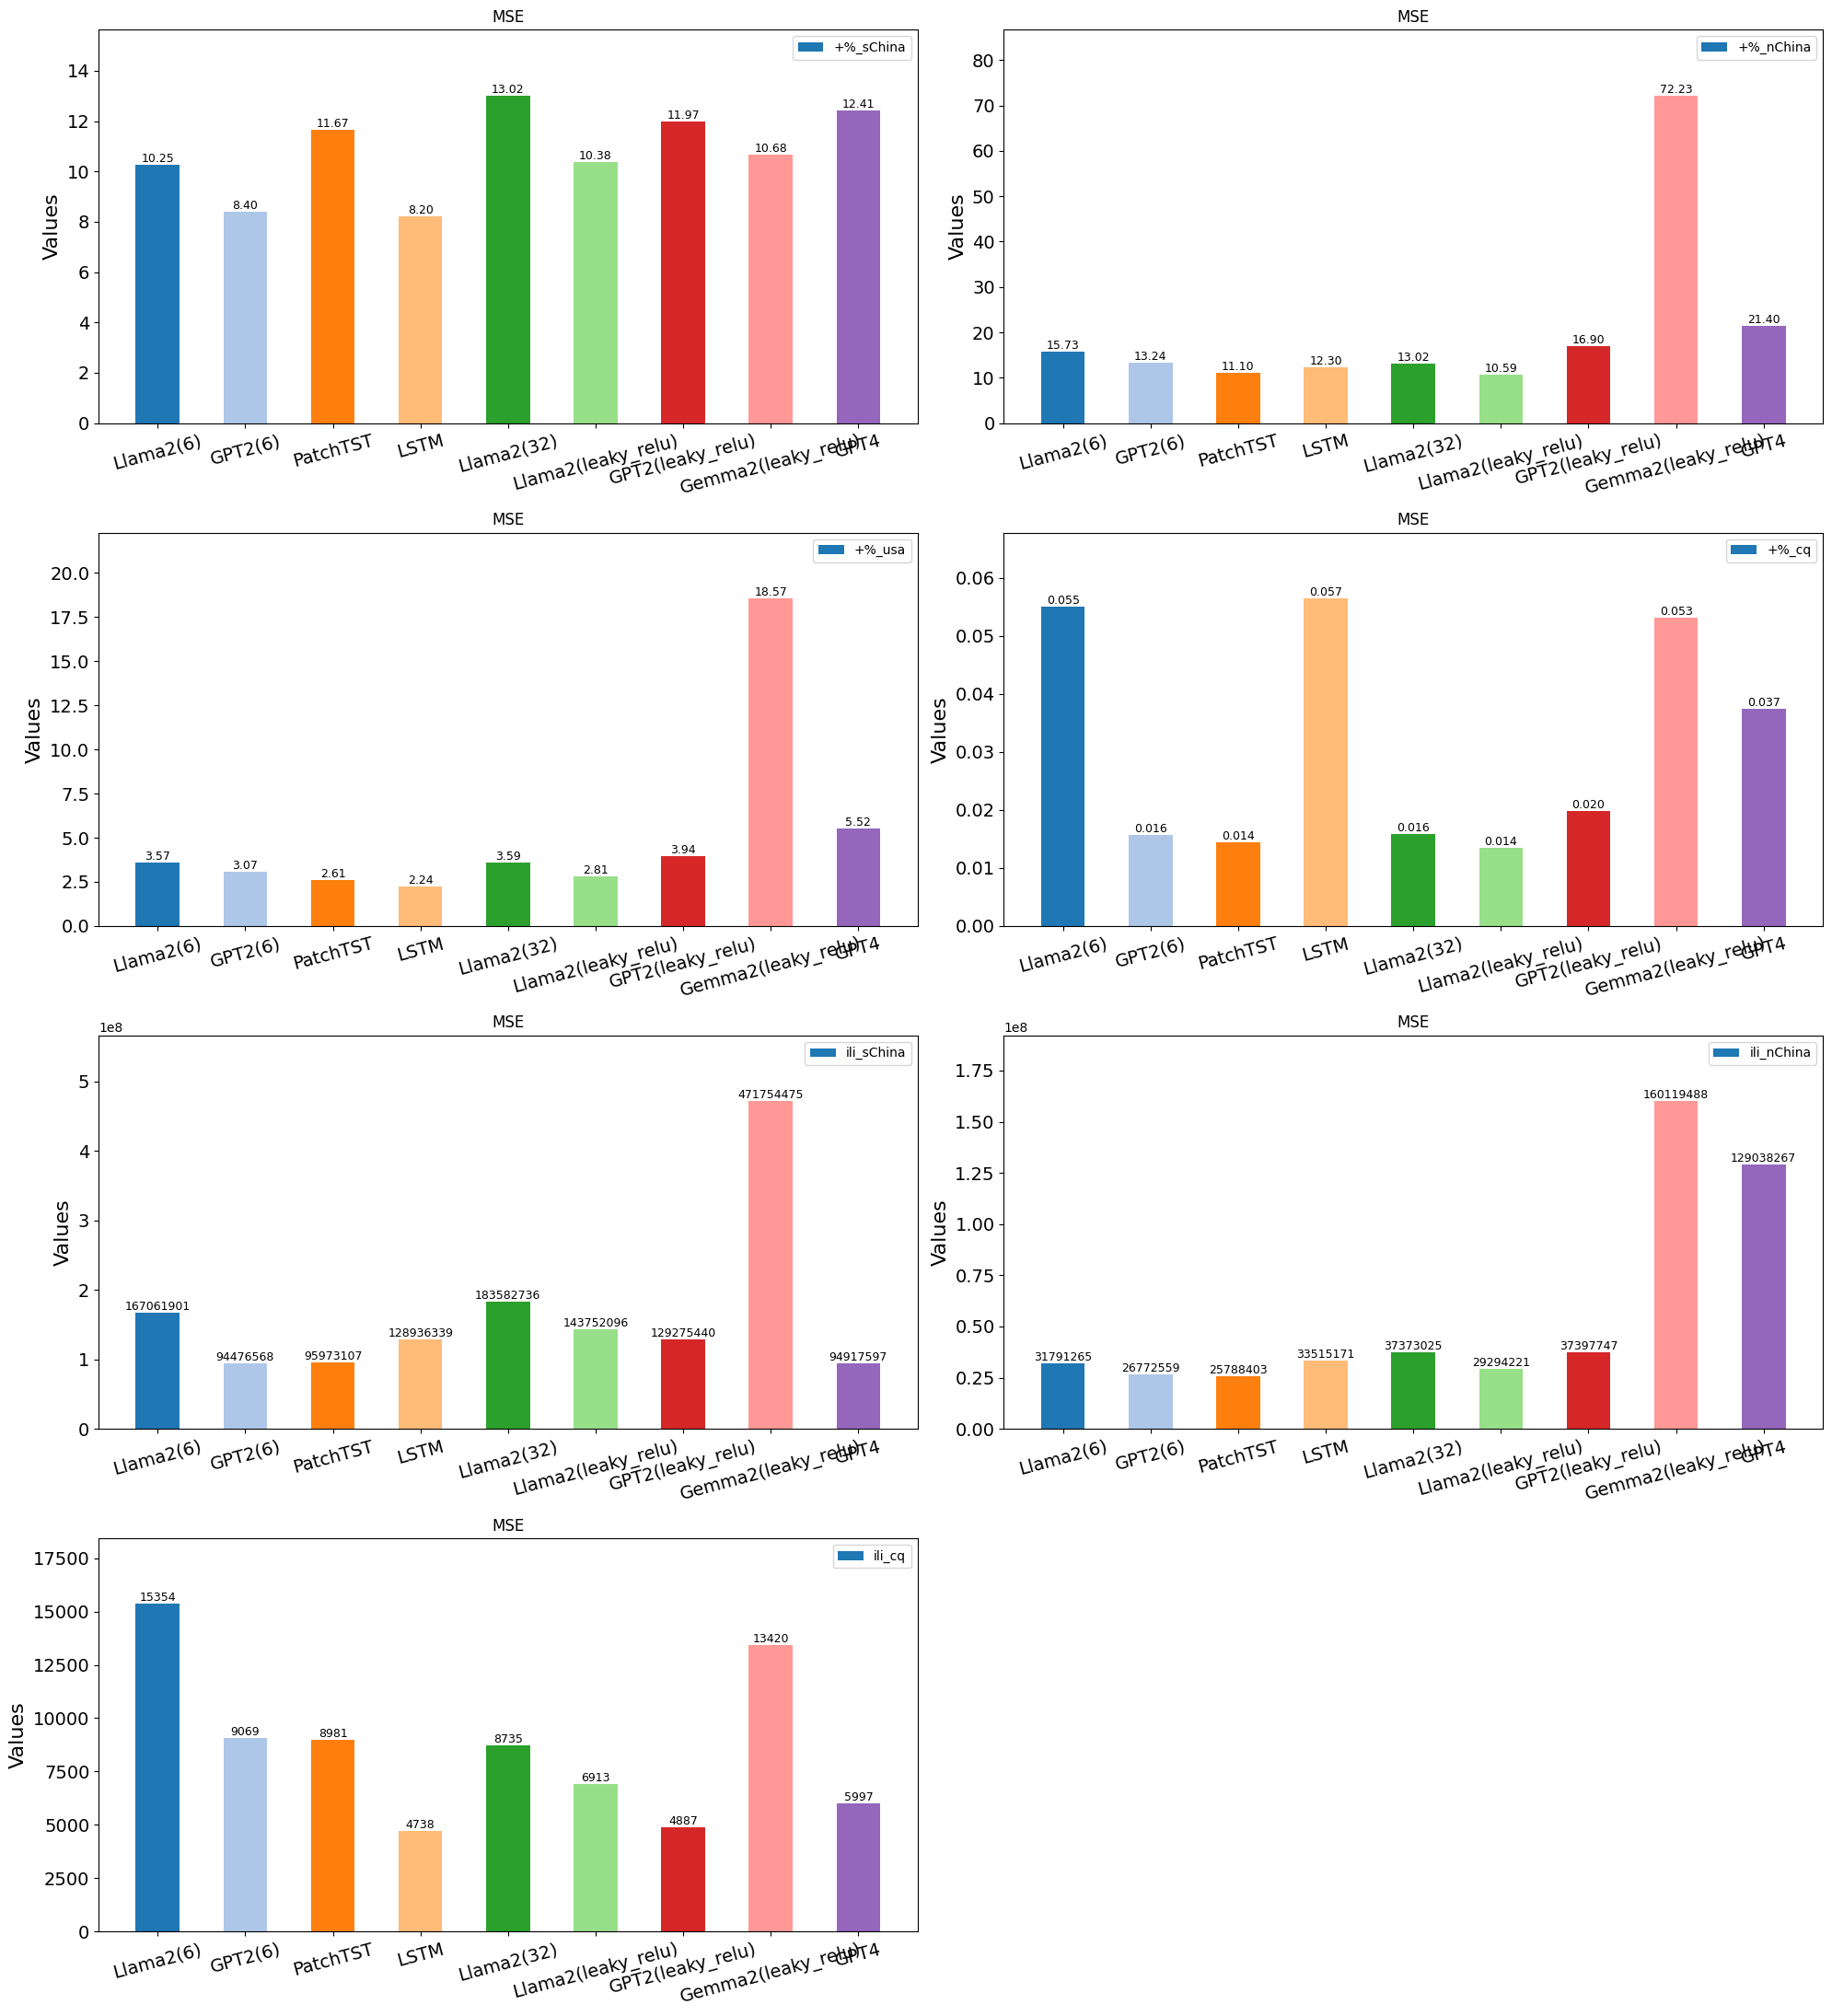

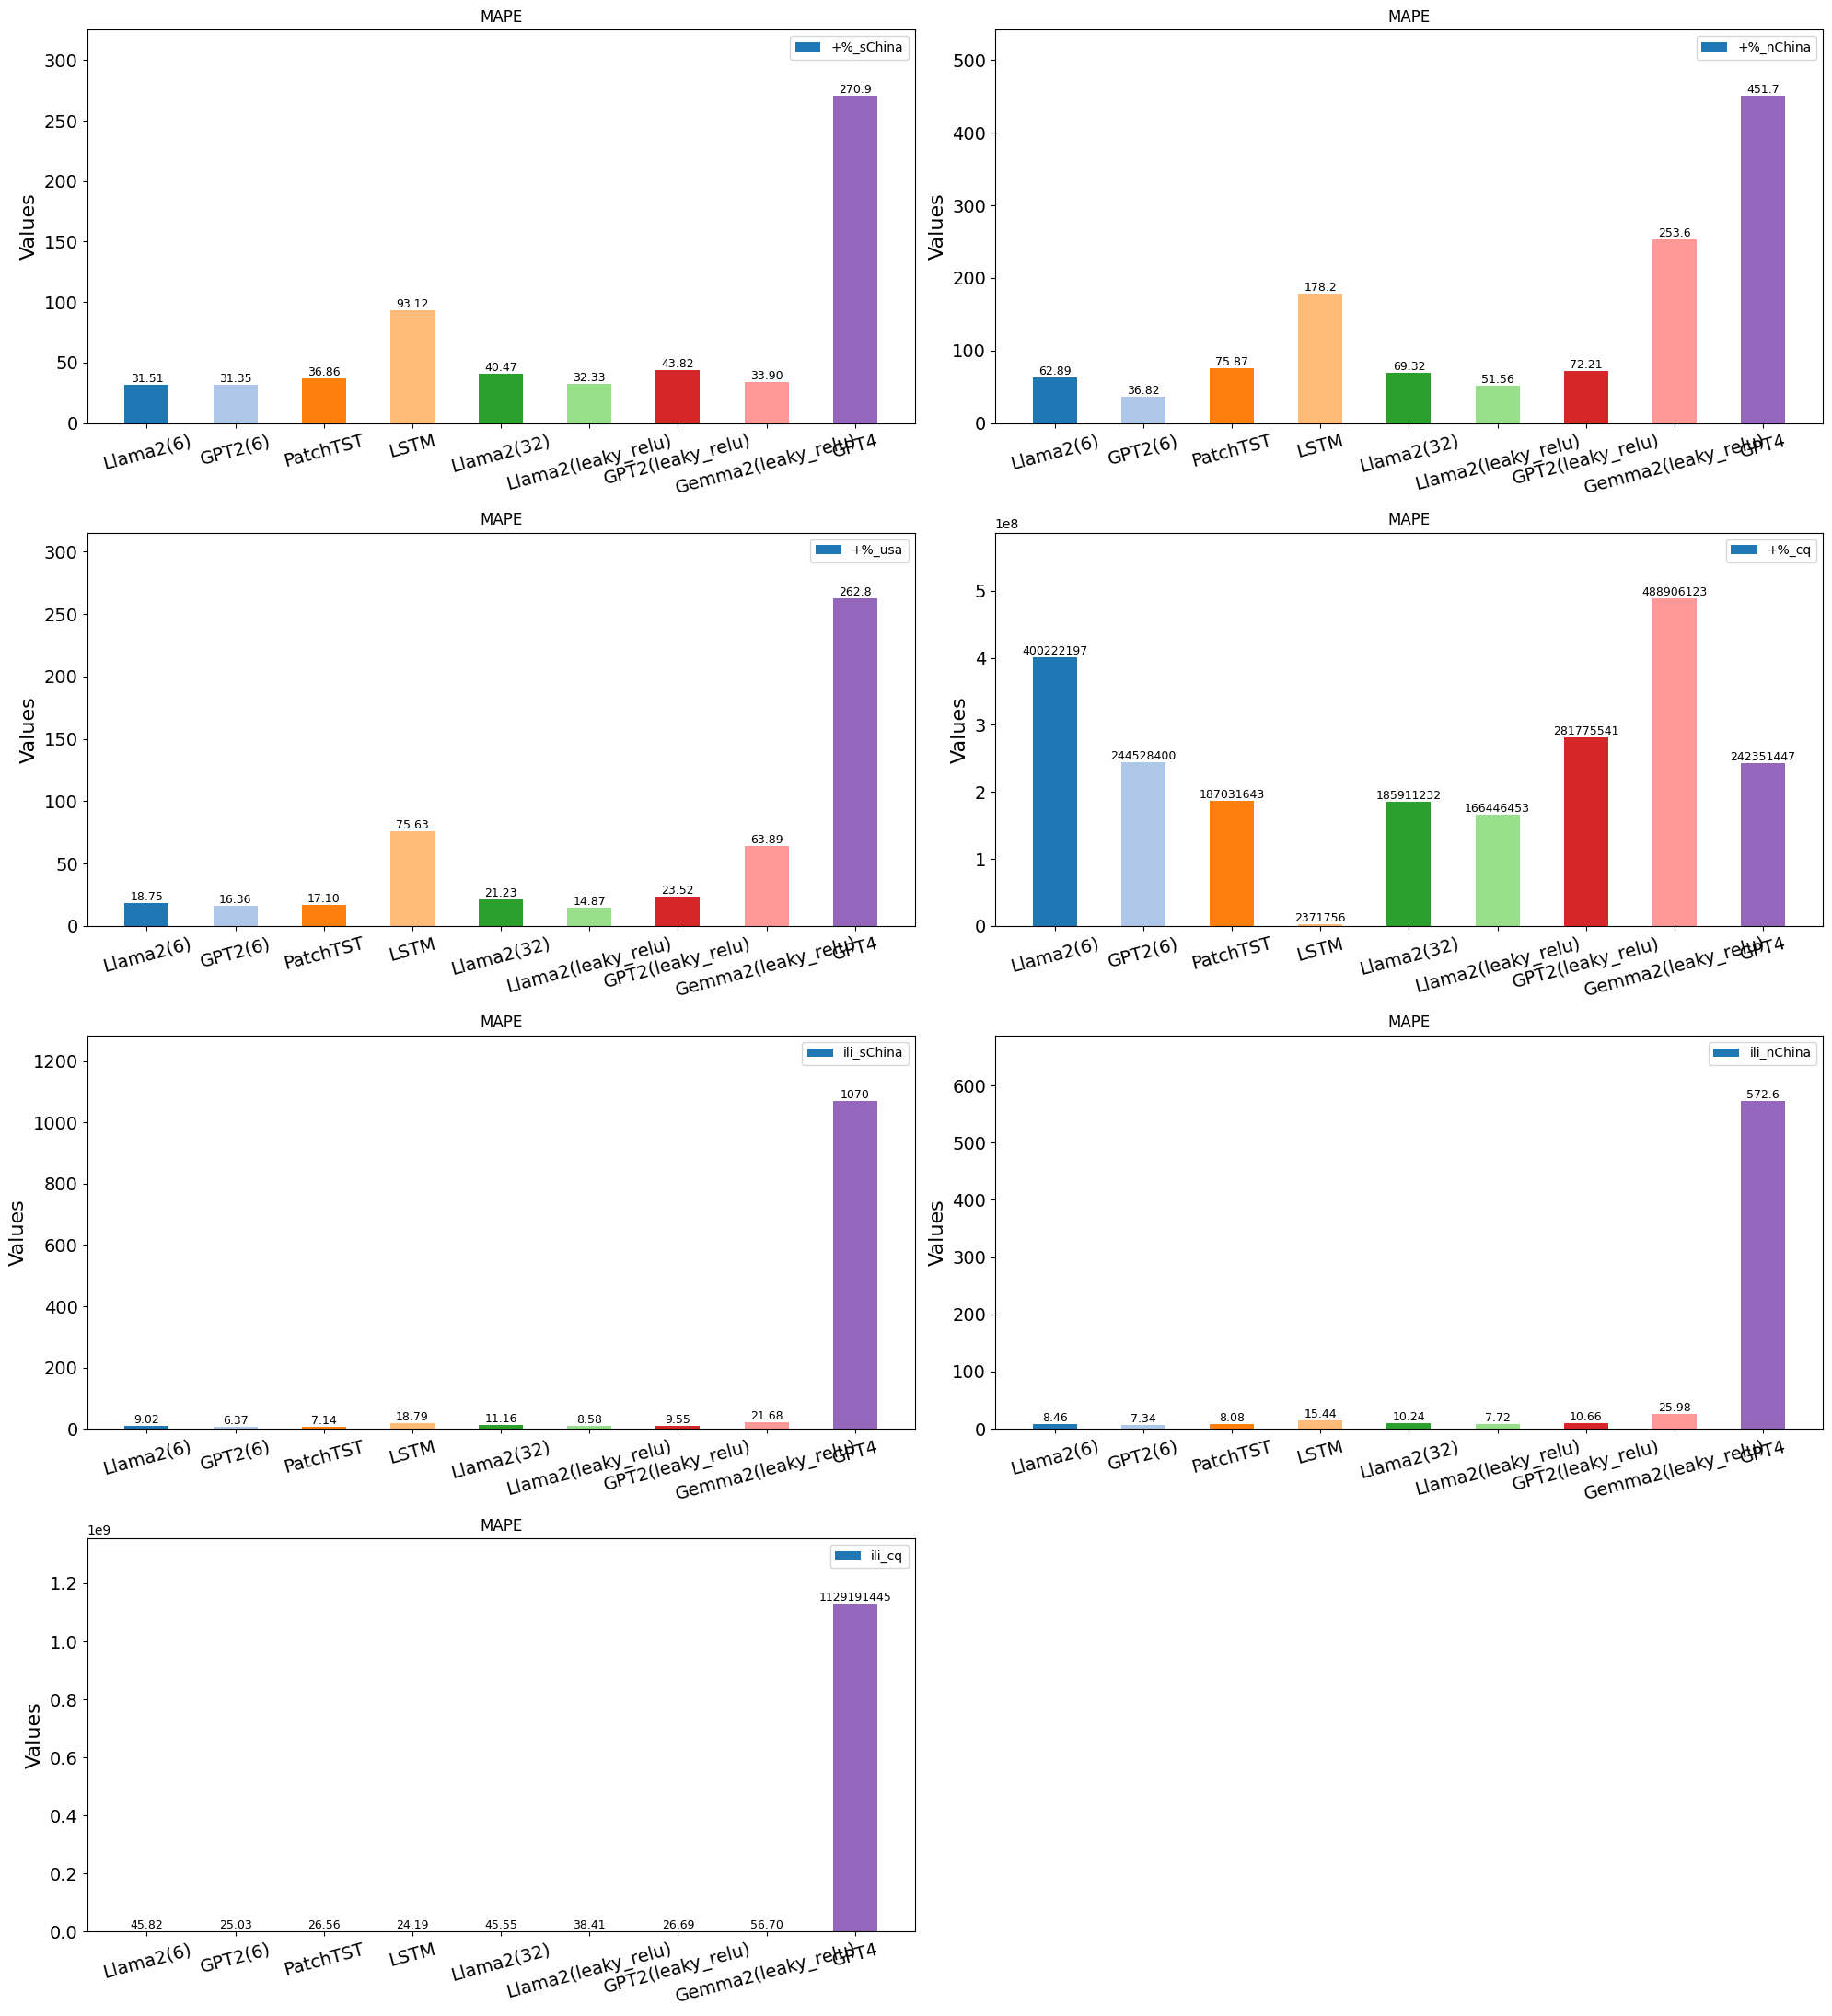

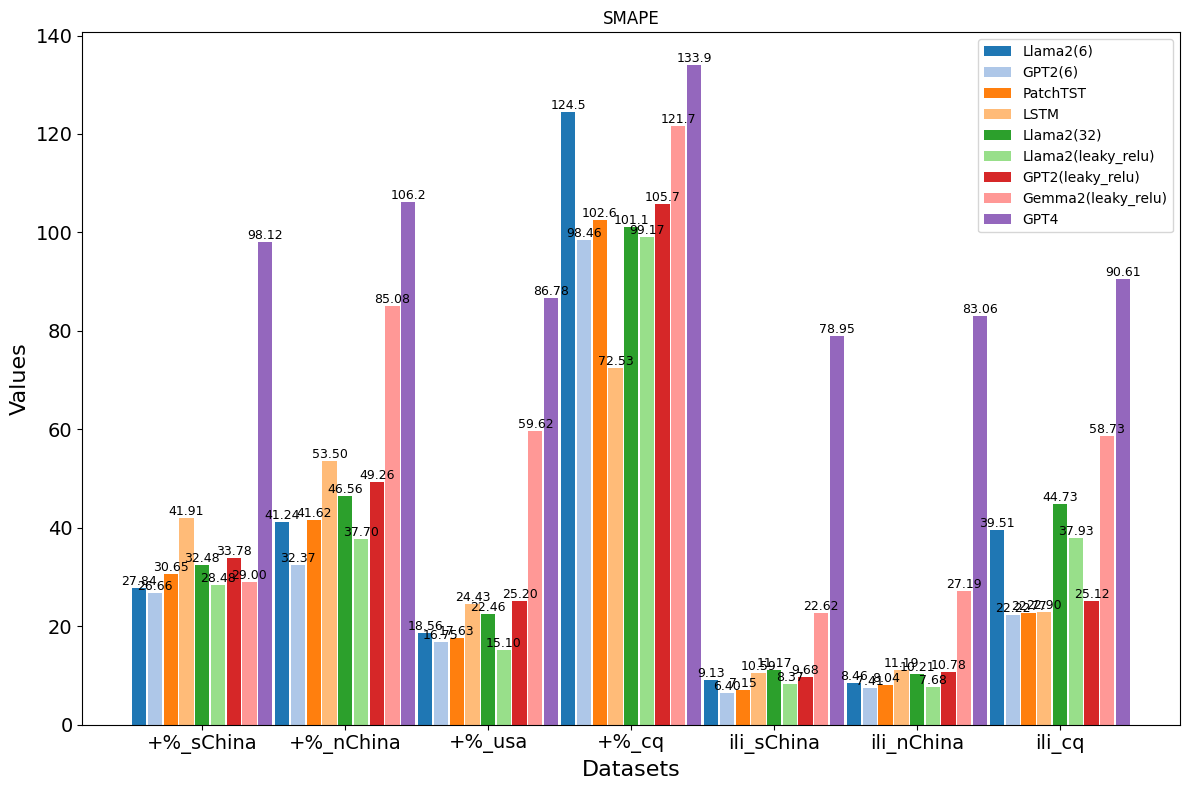

In [11]:
## inverse
visual1(dt2, '/data_disk/lichx/NeurIPS2023-One-Fits-All/Long-term_Forecasting/Output/png/train/inverse/') 

## No Tuned

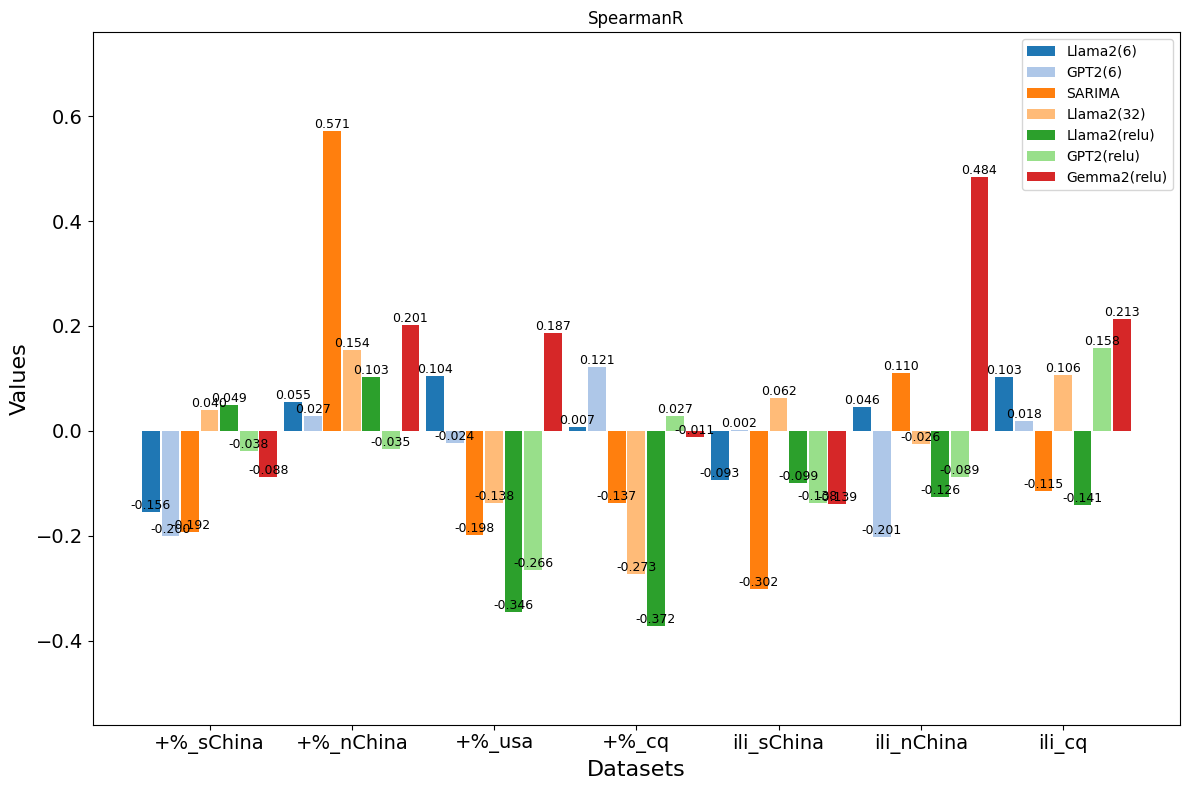

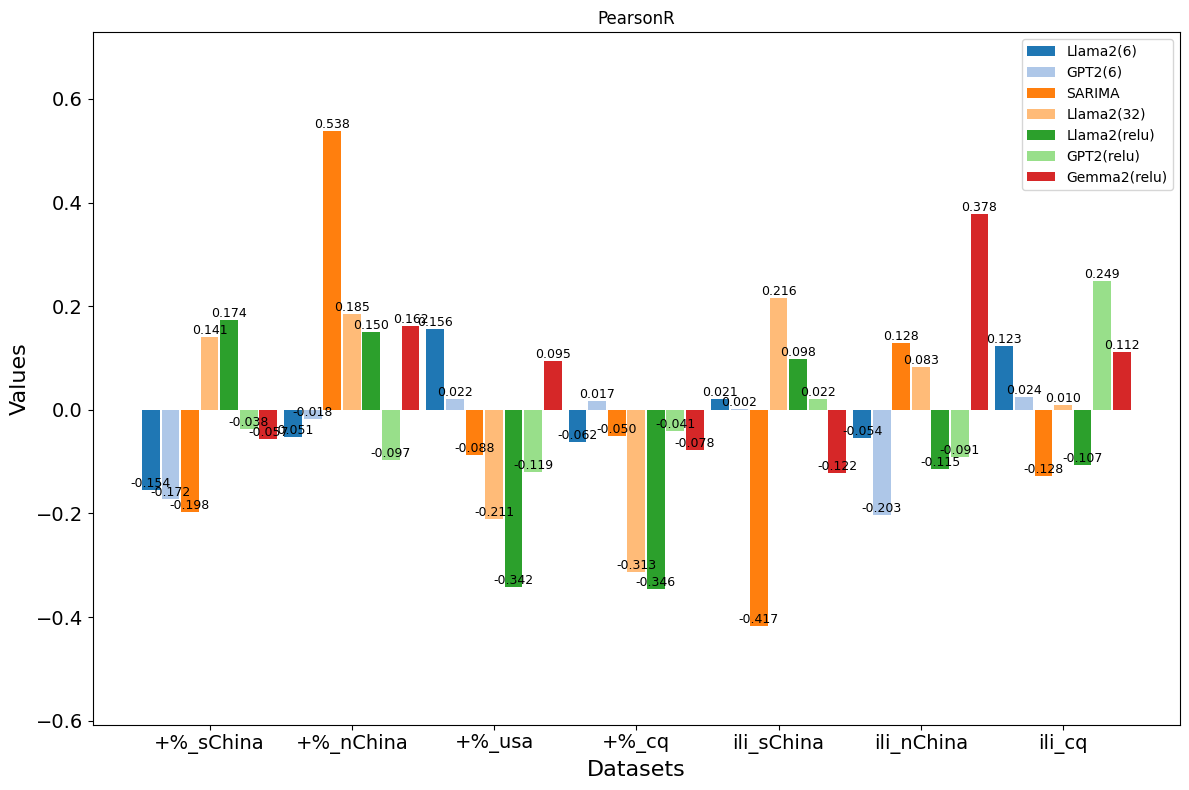

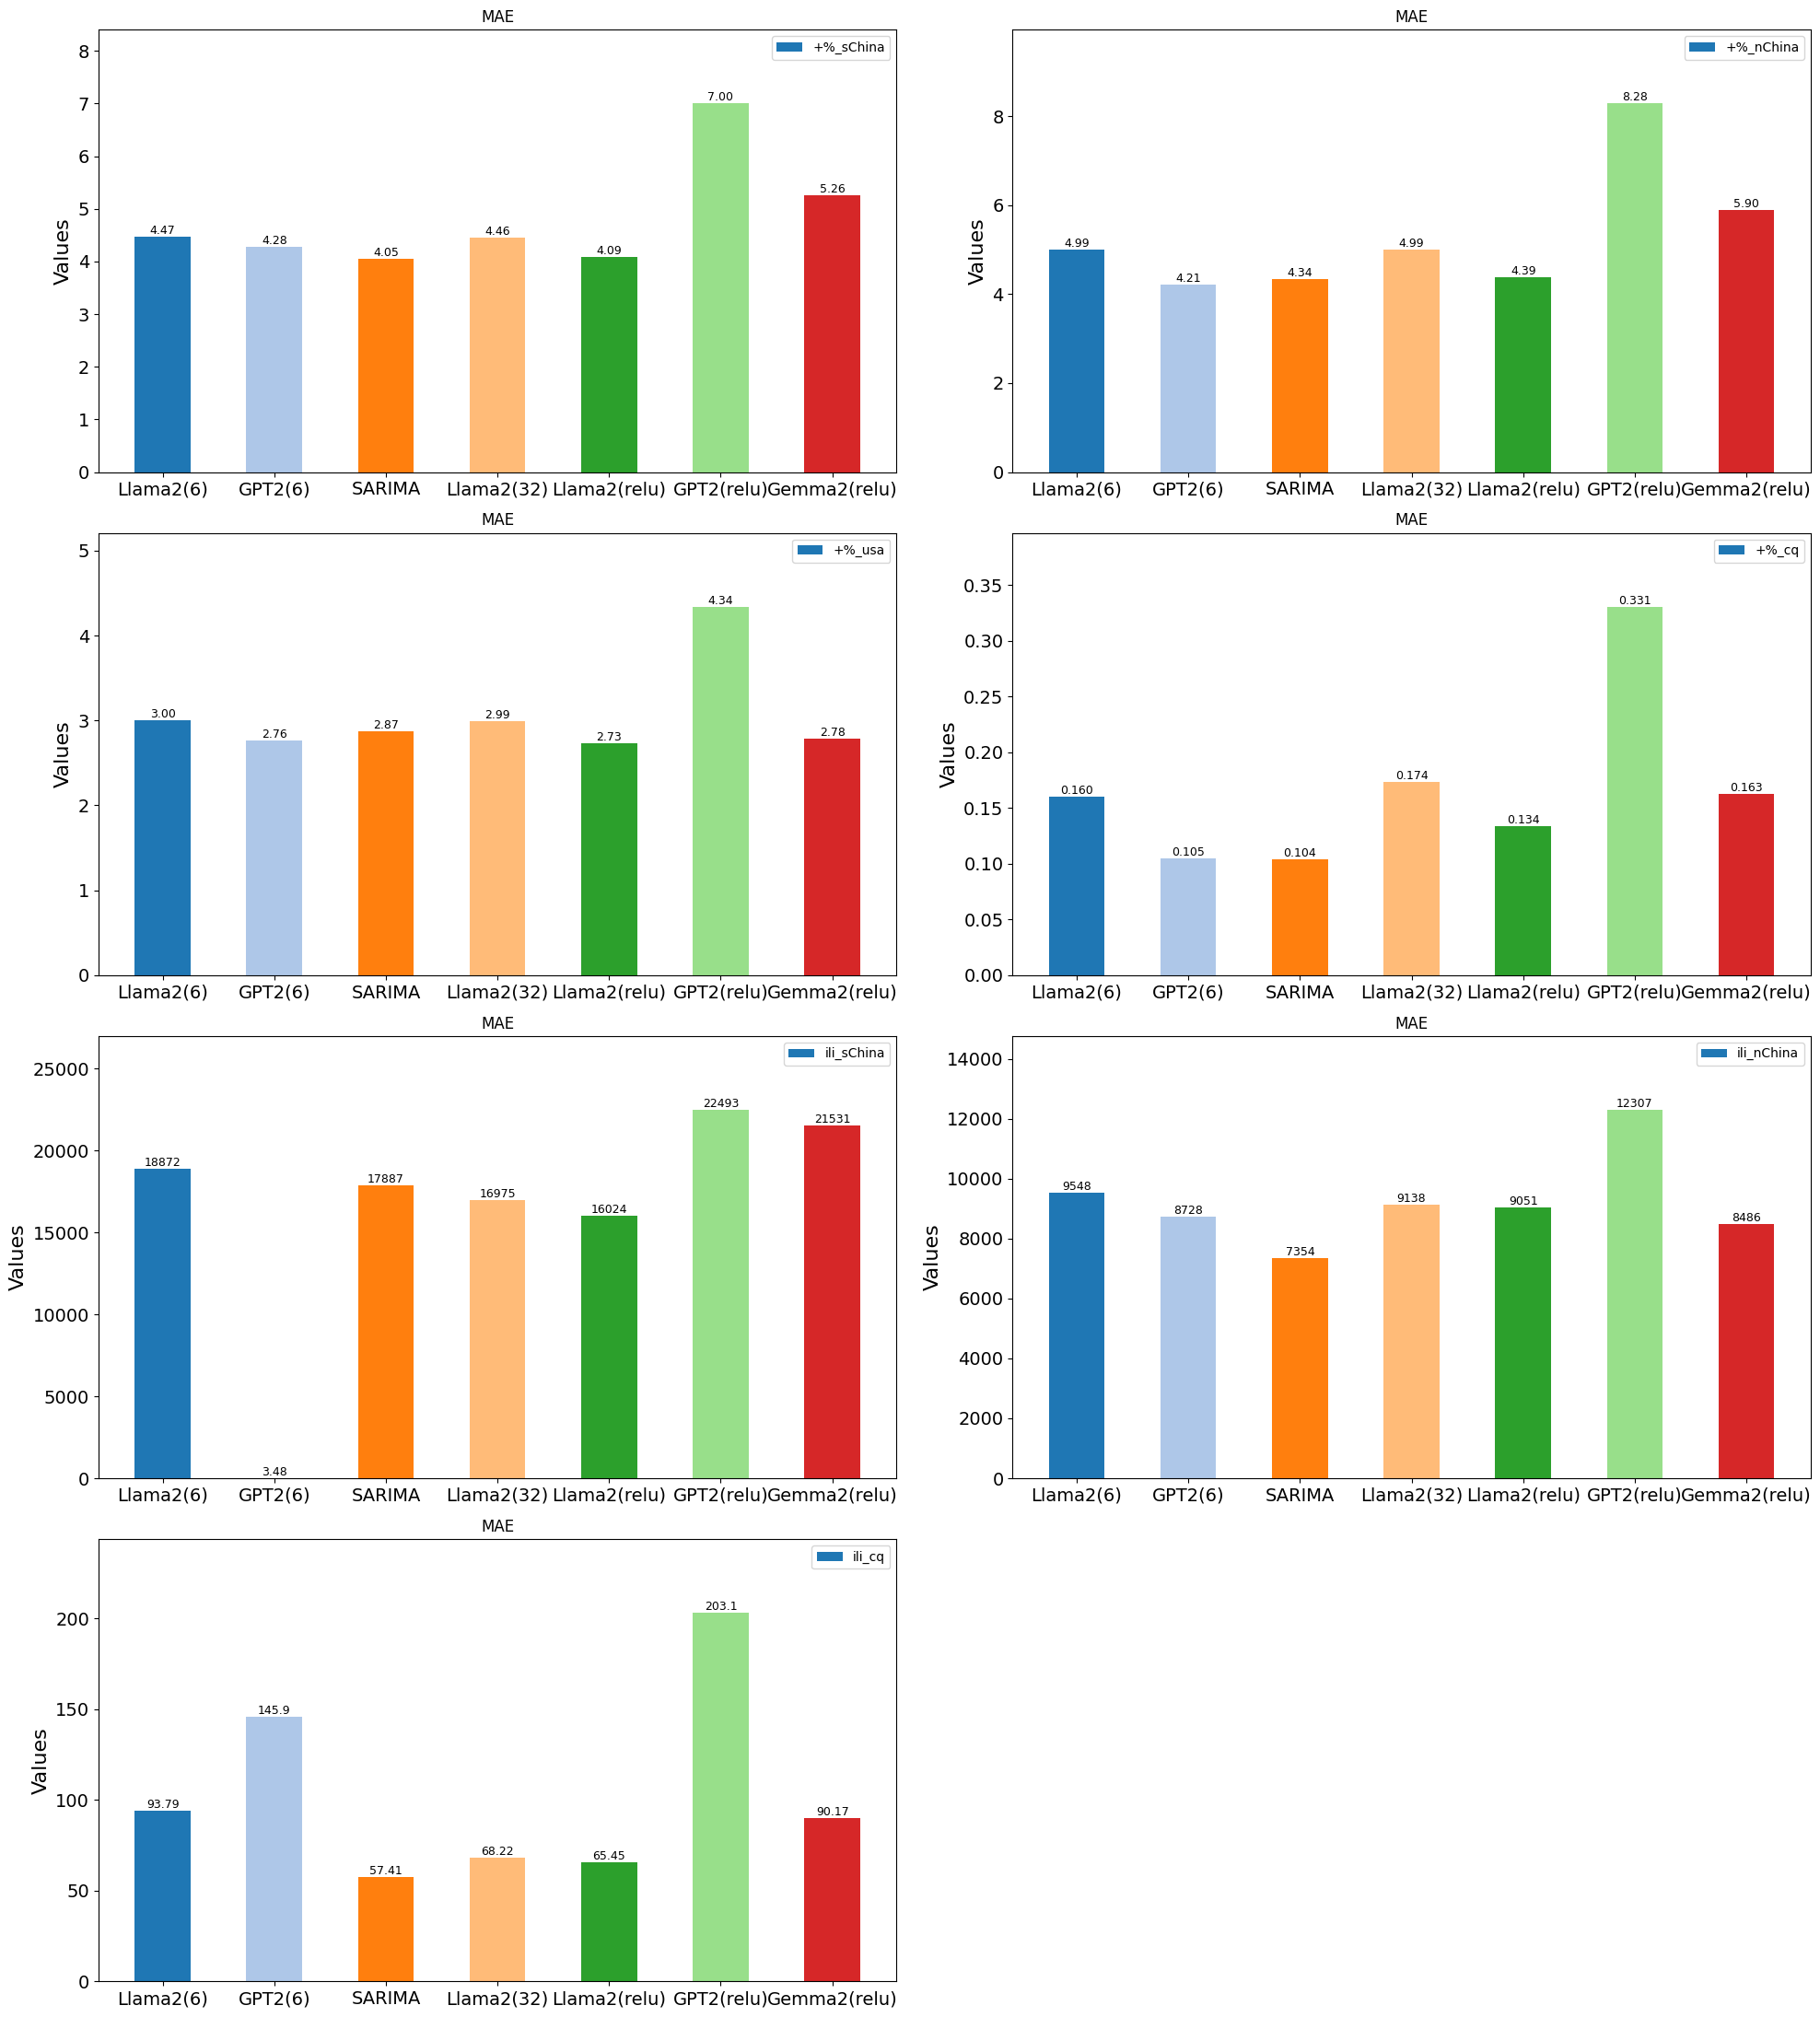

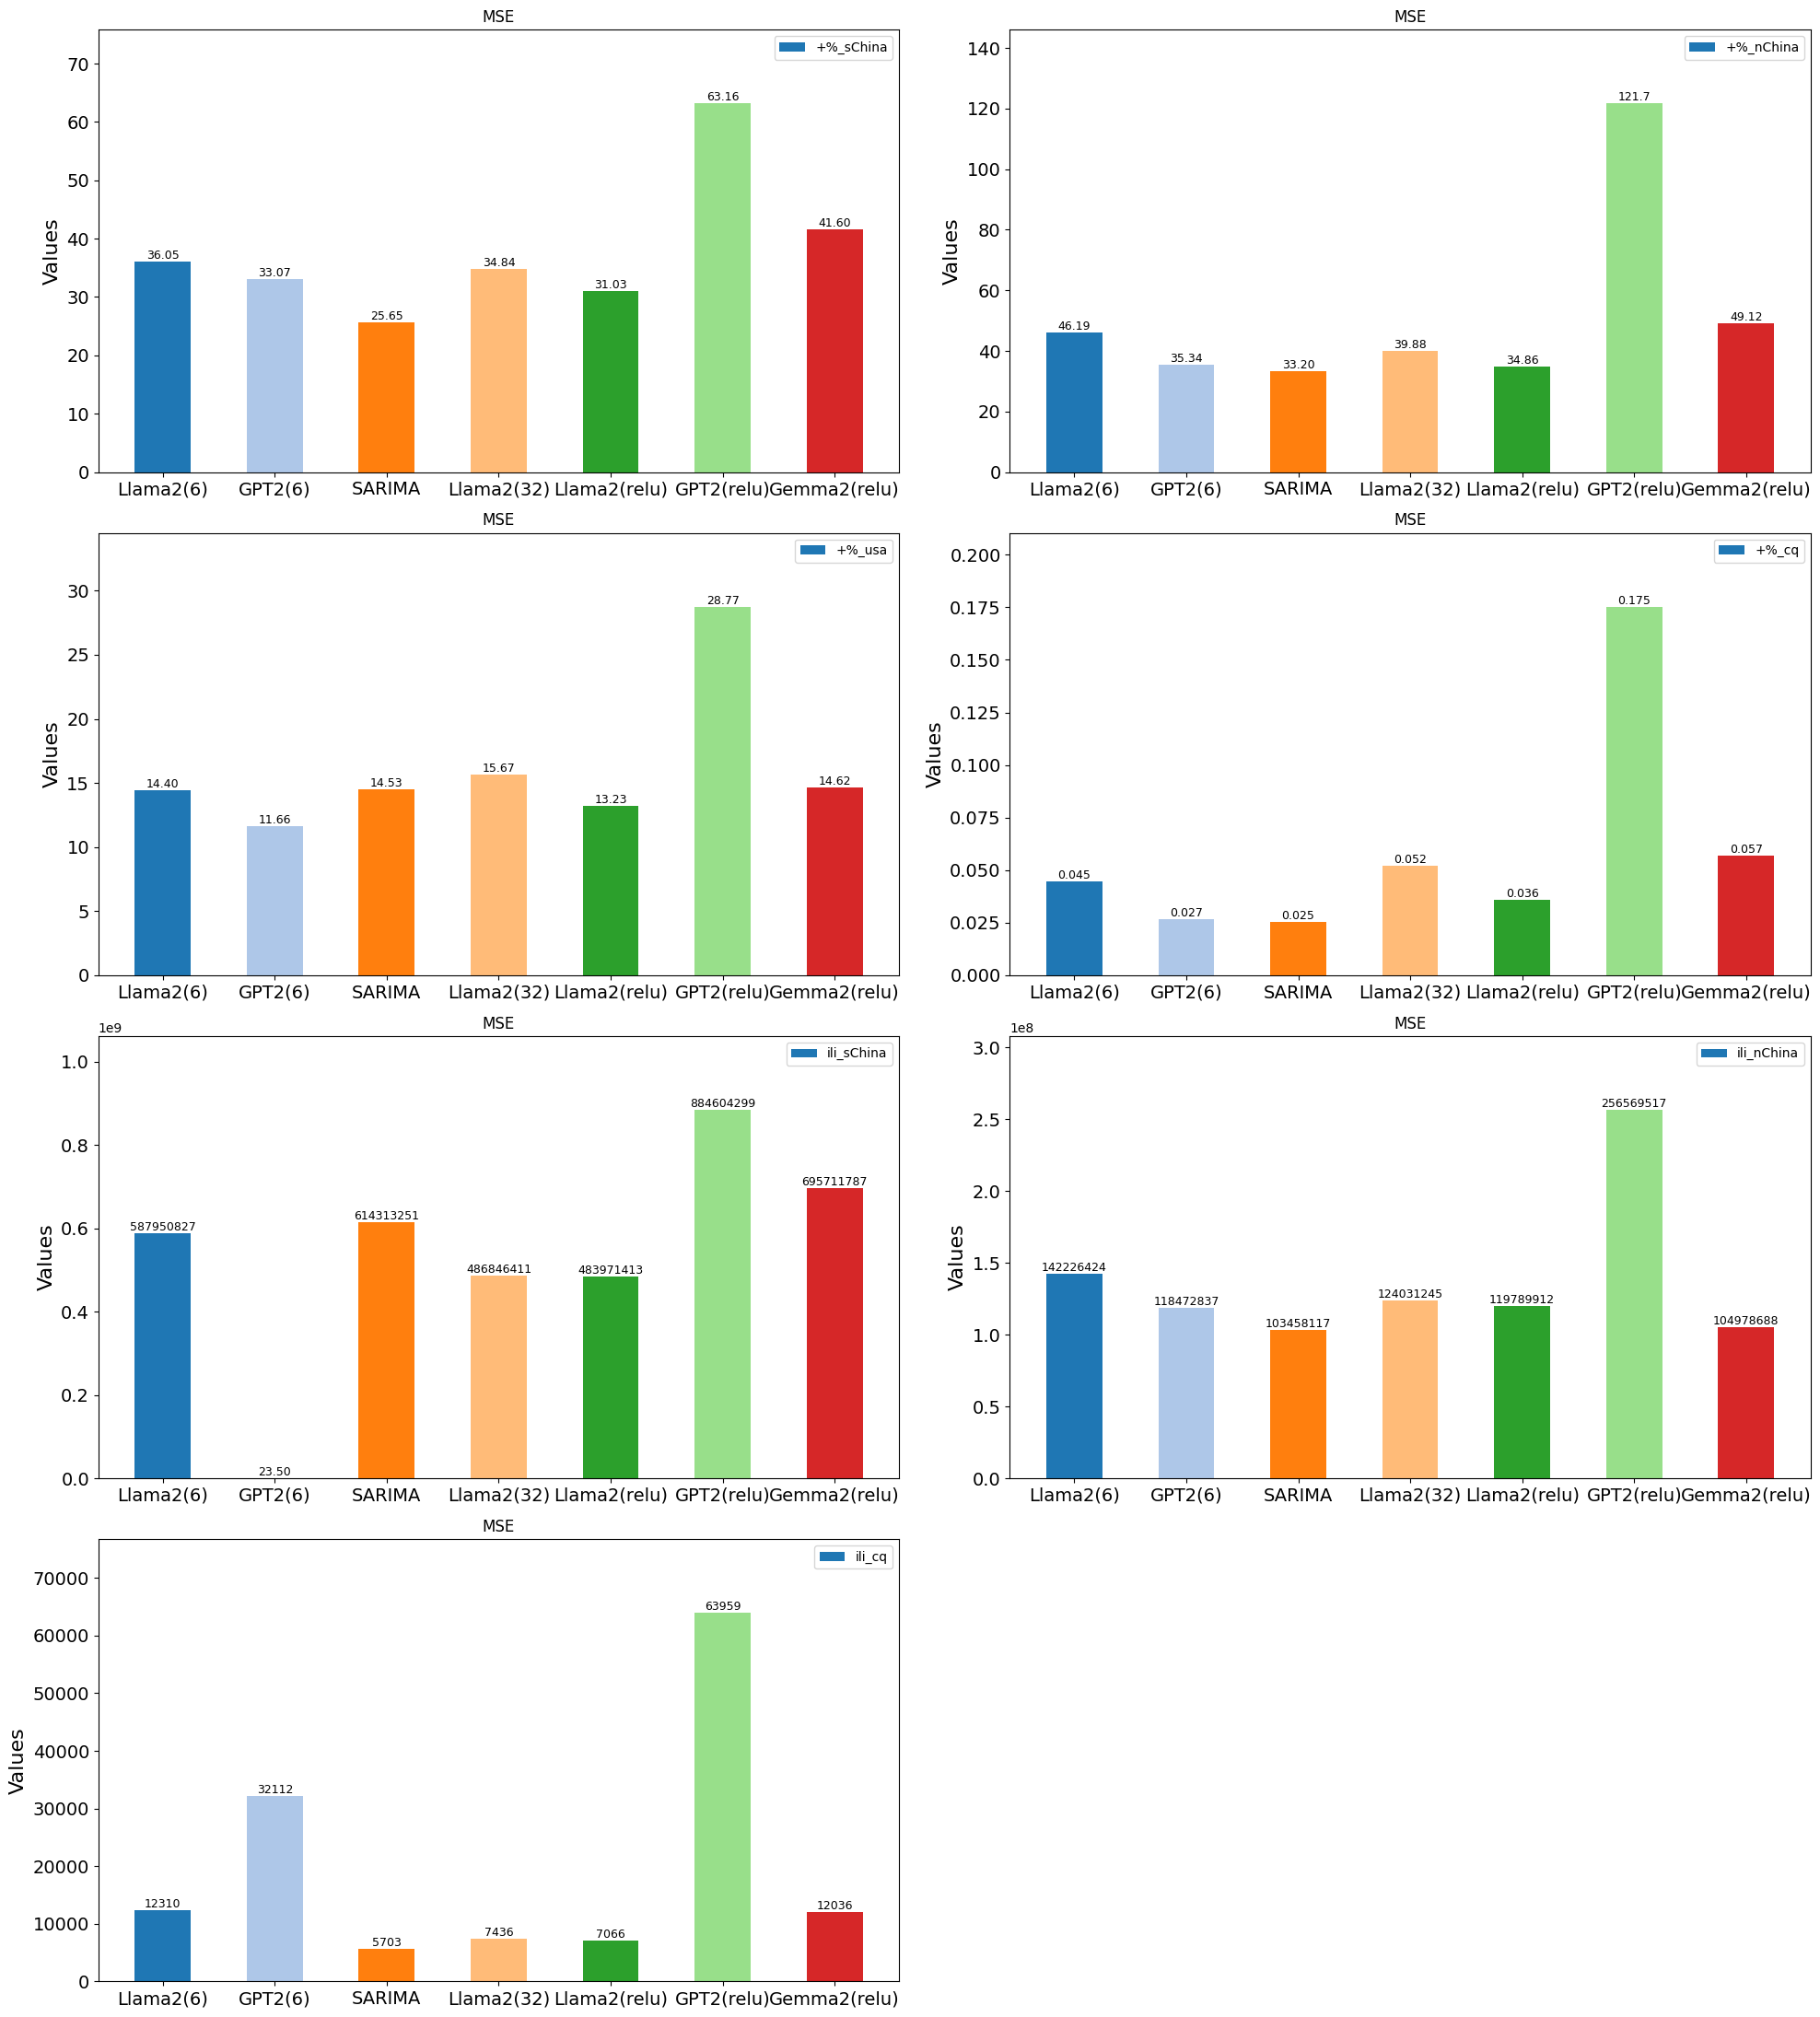

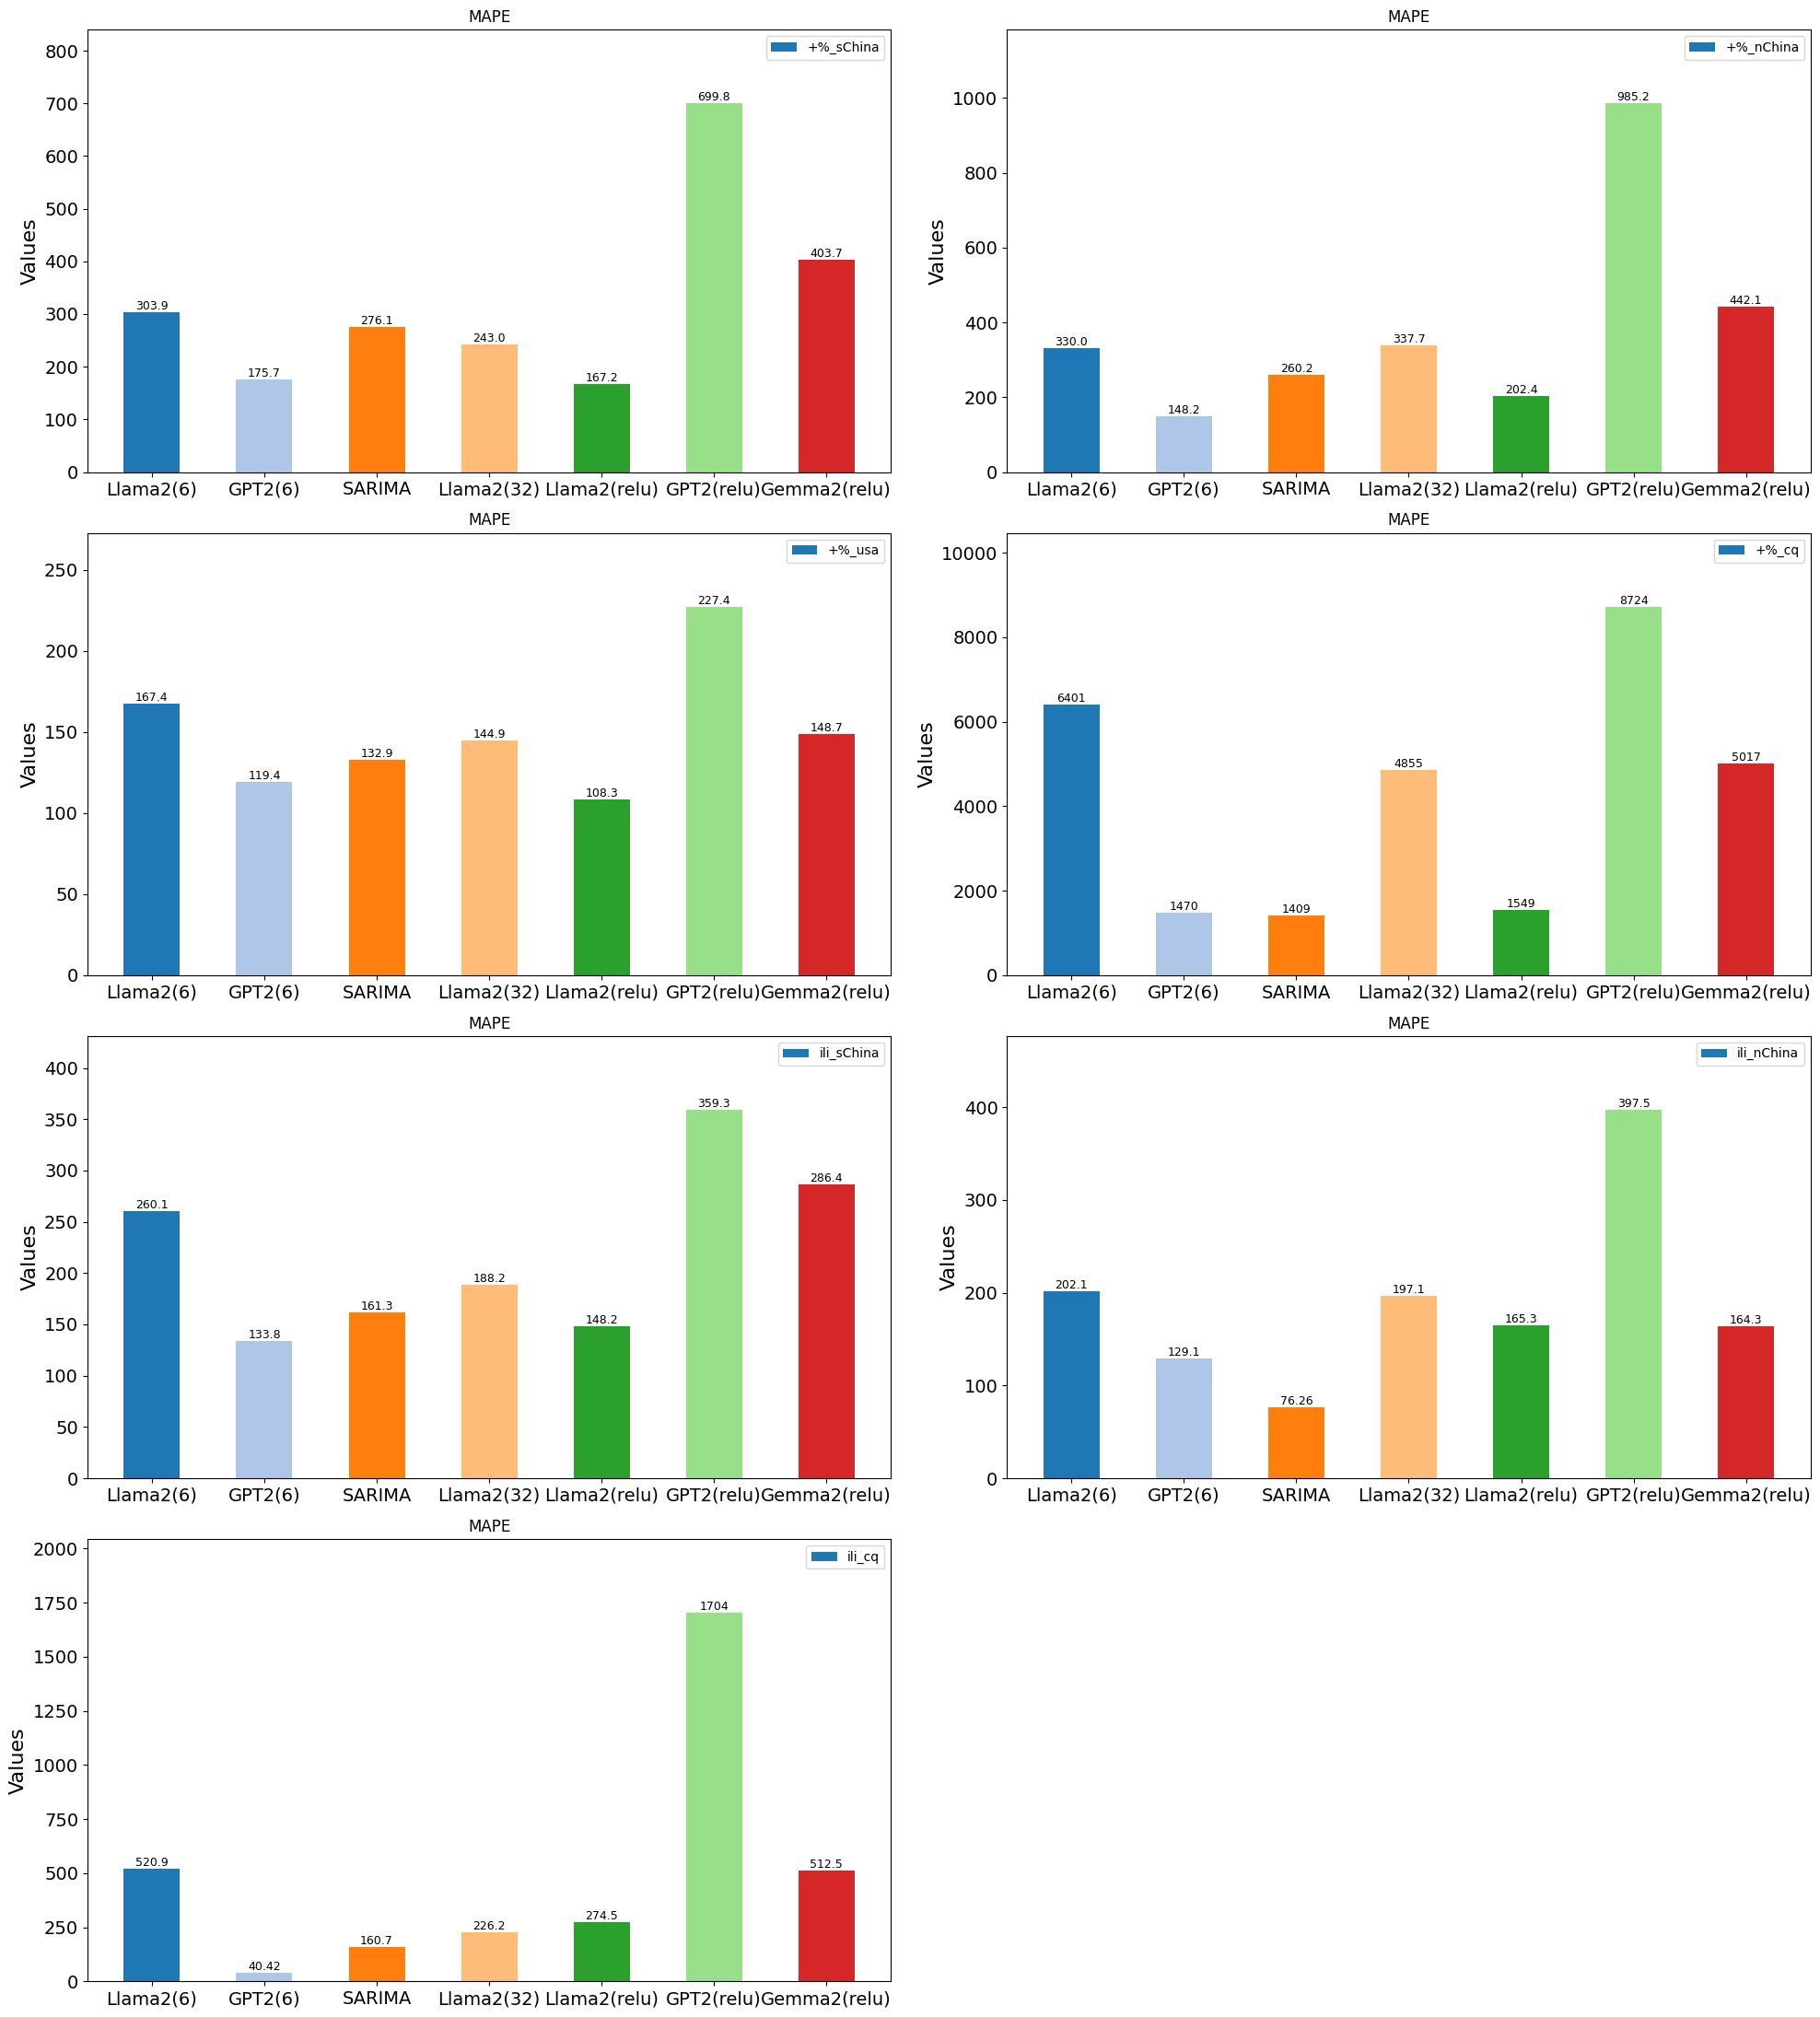

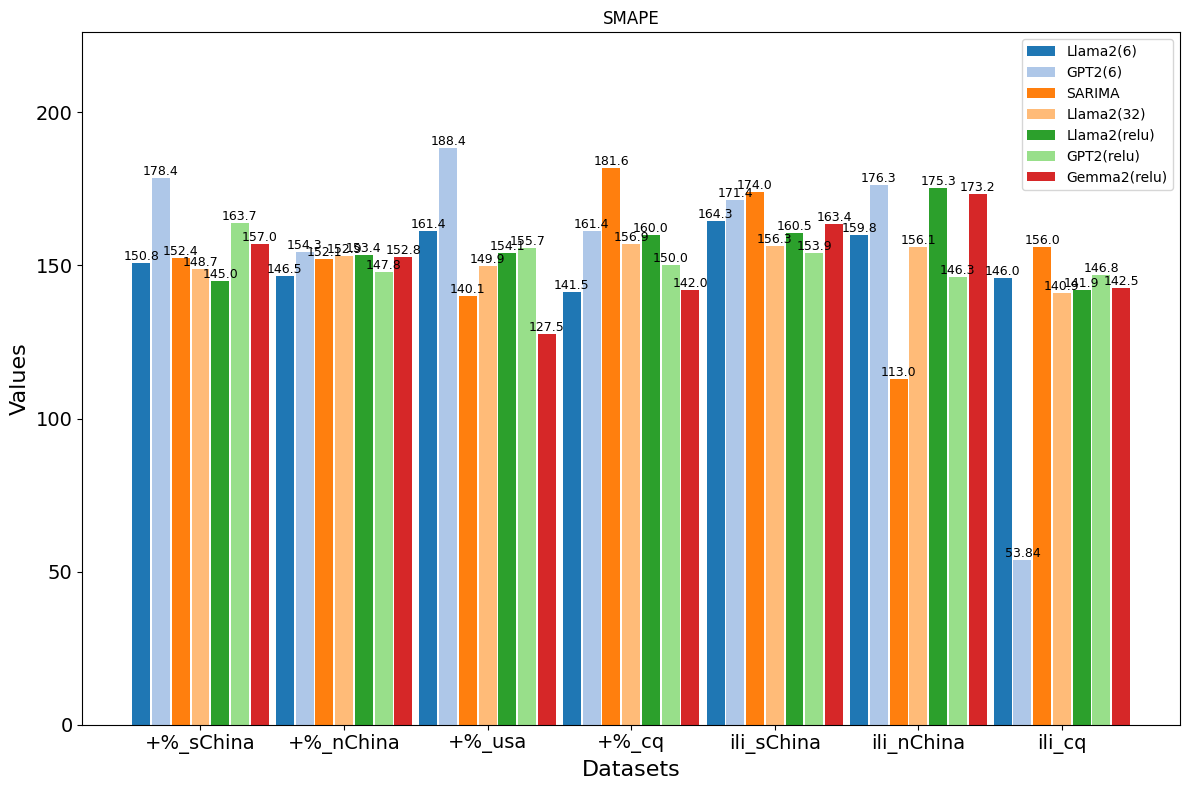

In [17]:
## diff
visual2(dt3, '/data_disk/lichx/NeurIPS2023-One-Fits-All/Long-term_Forecasting/Output/png/no_train/diff')

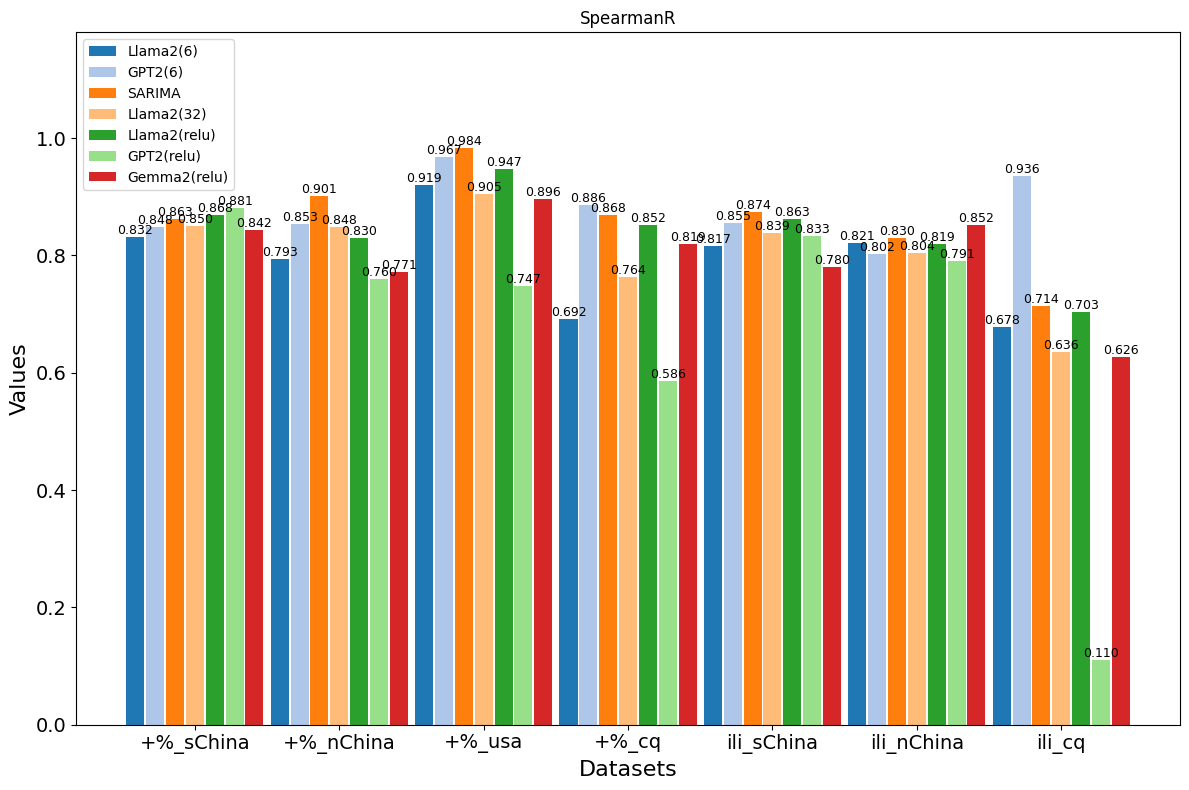

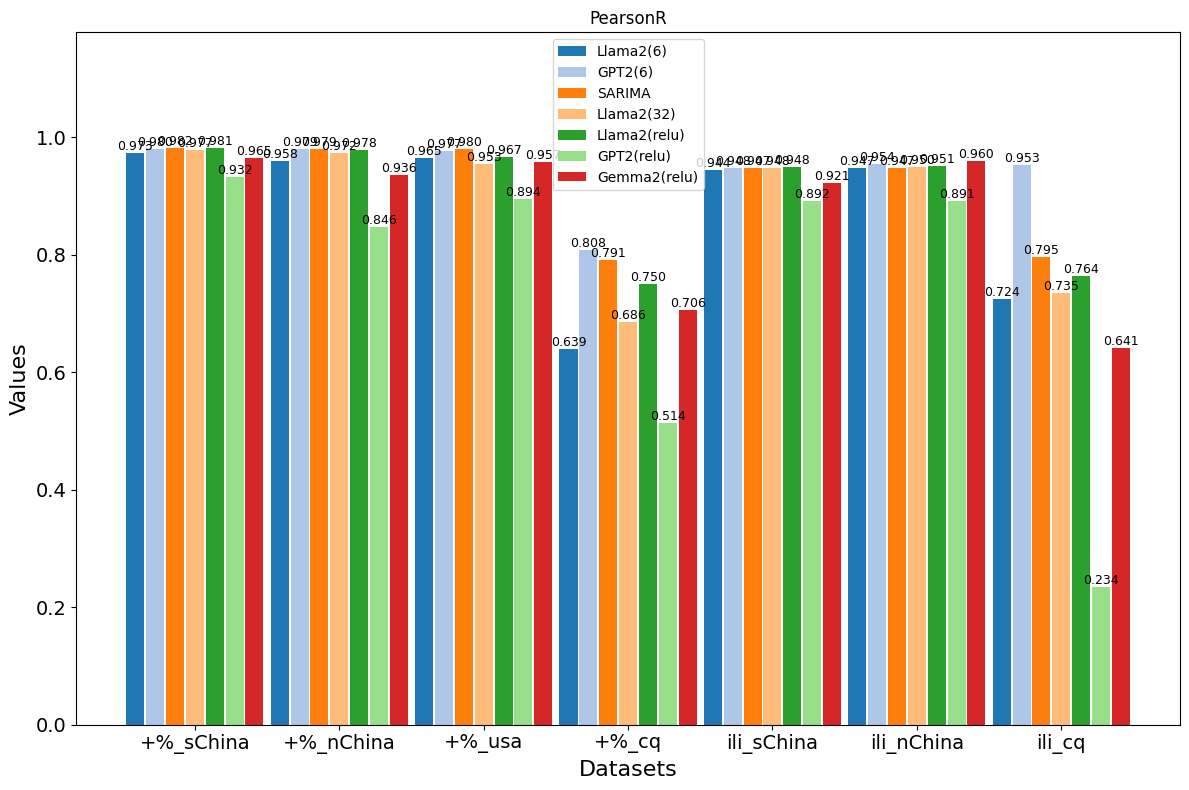

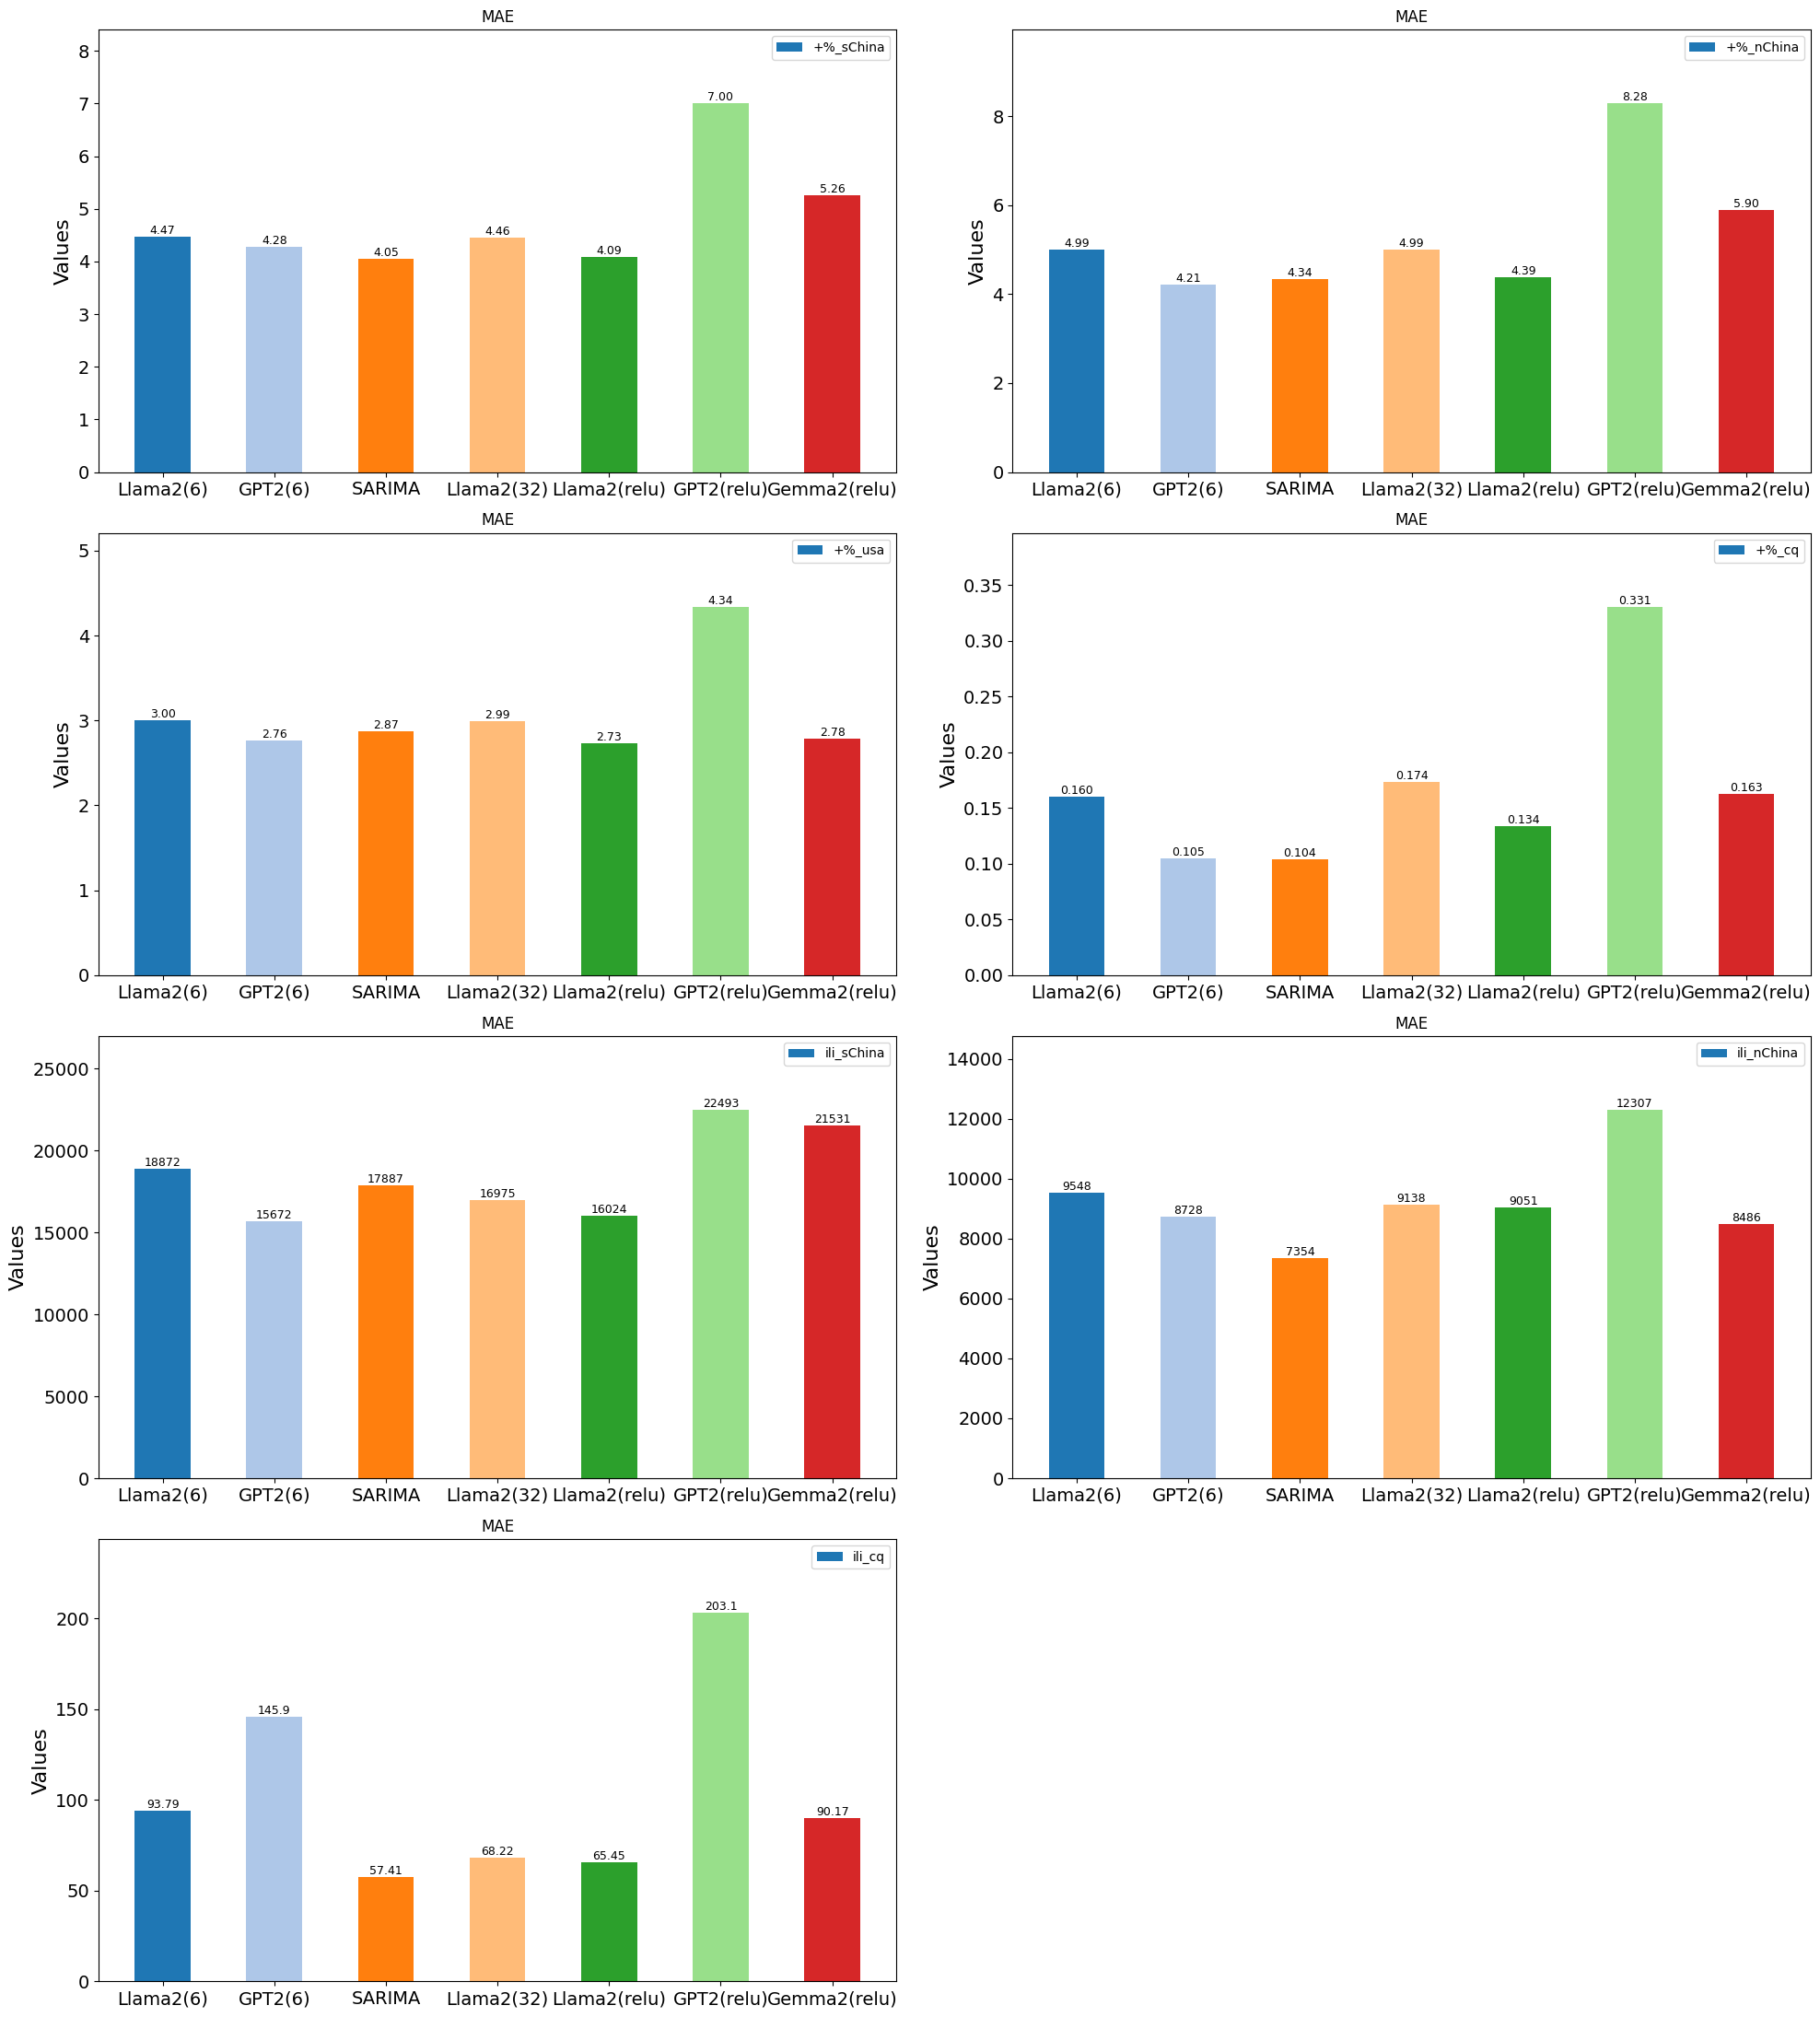

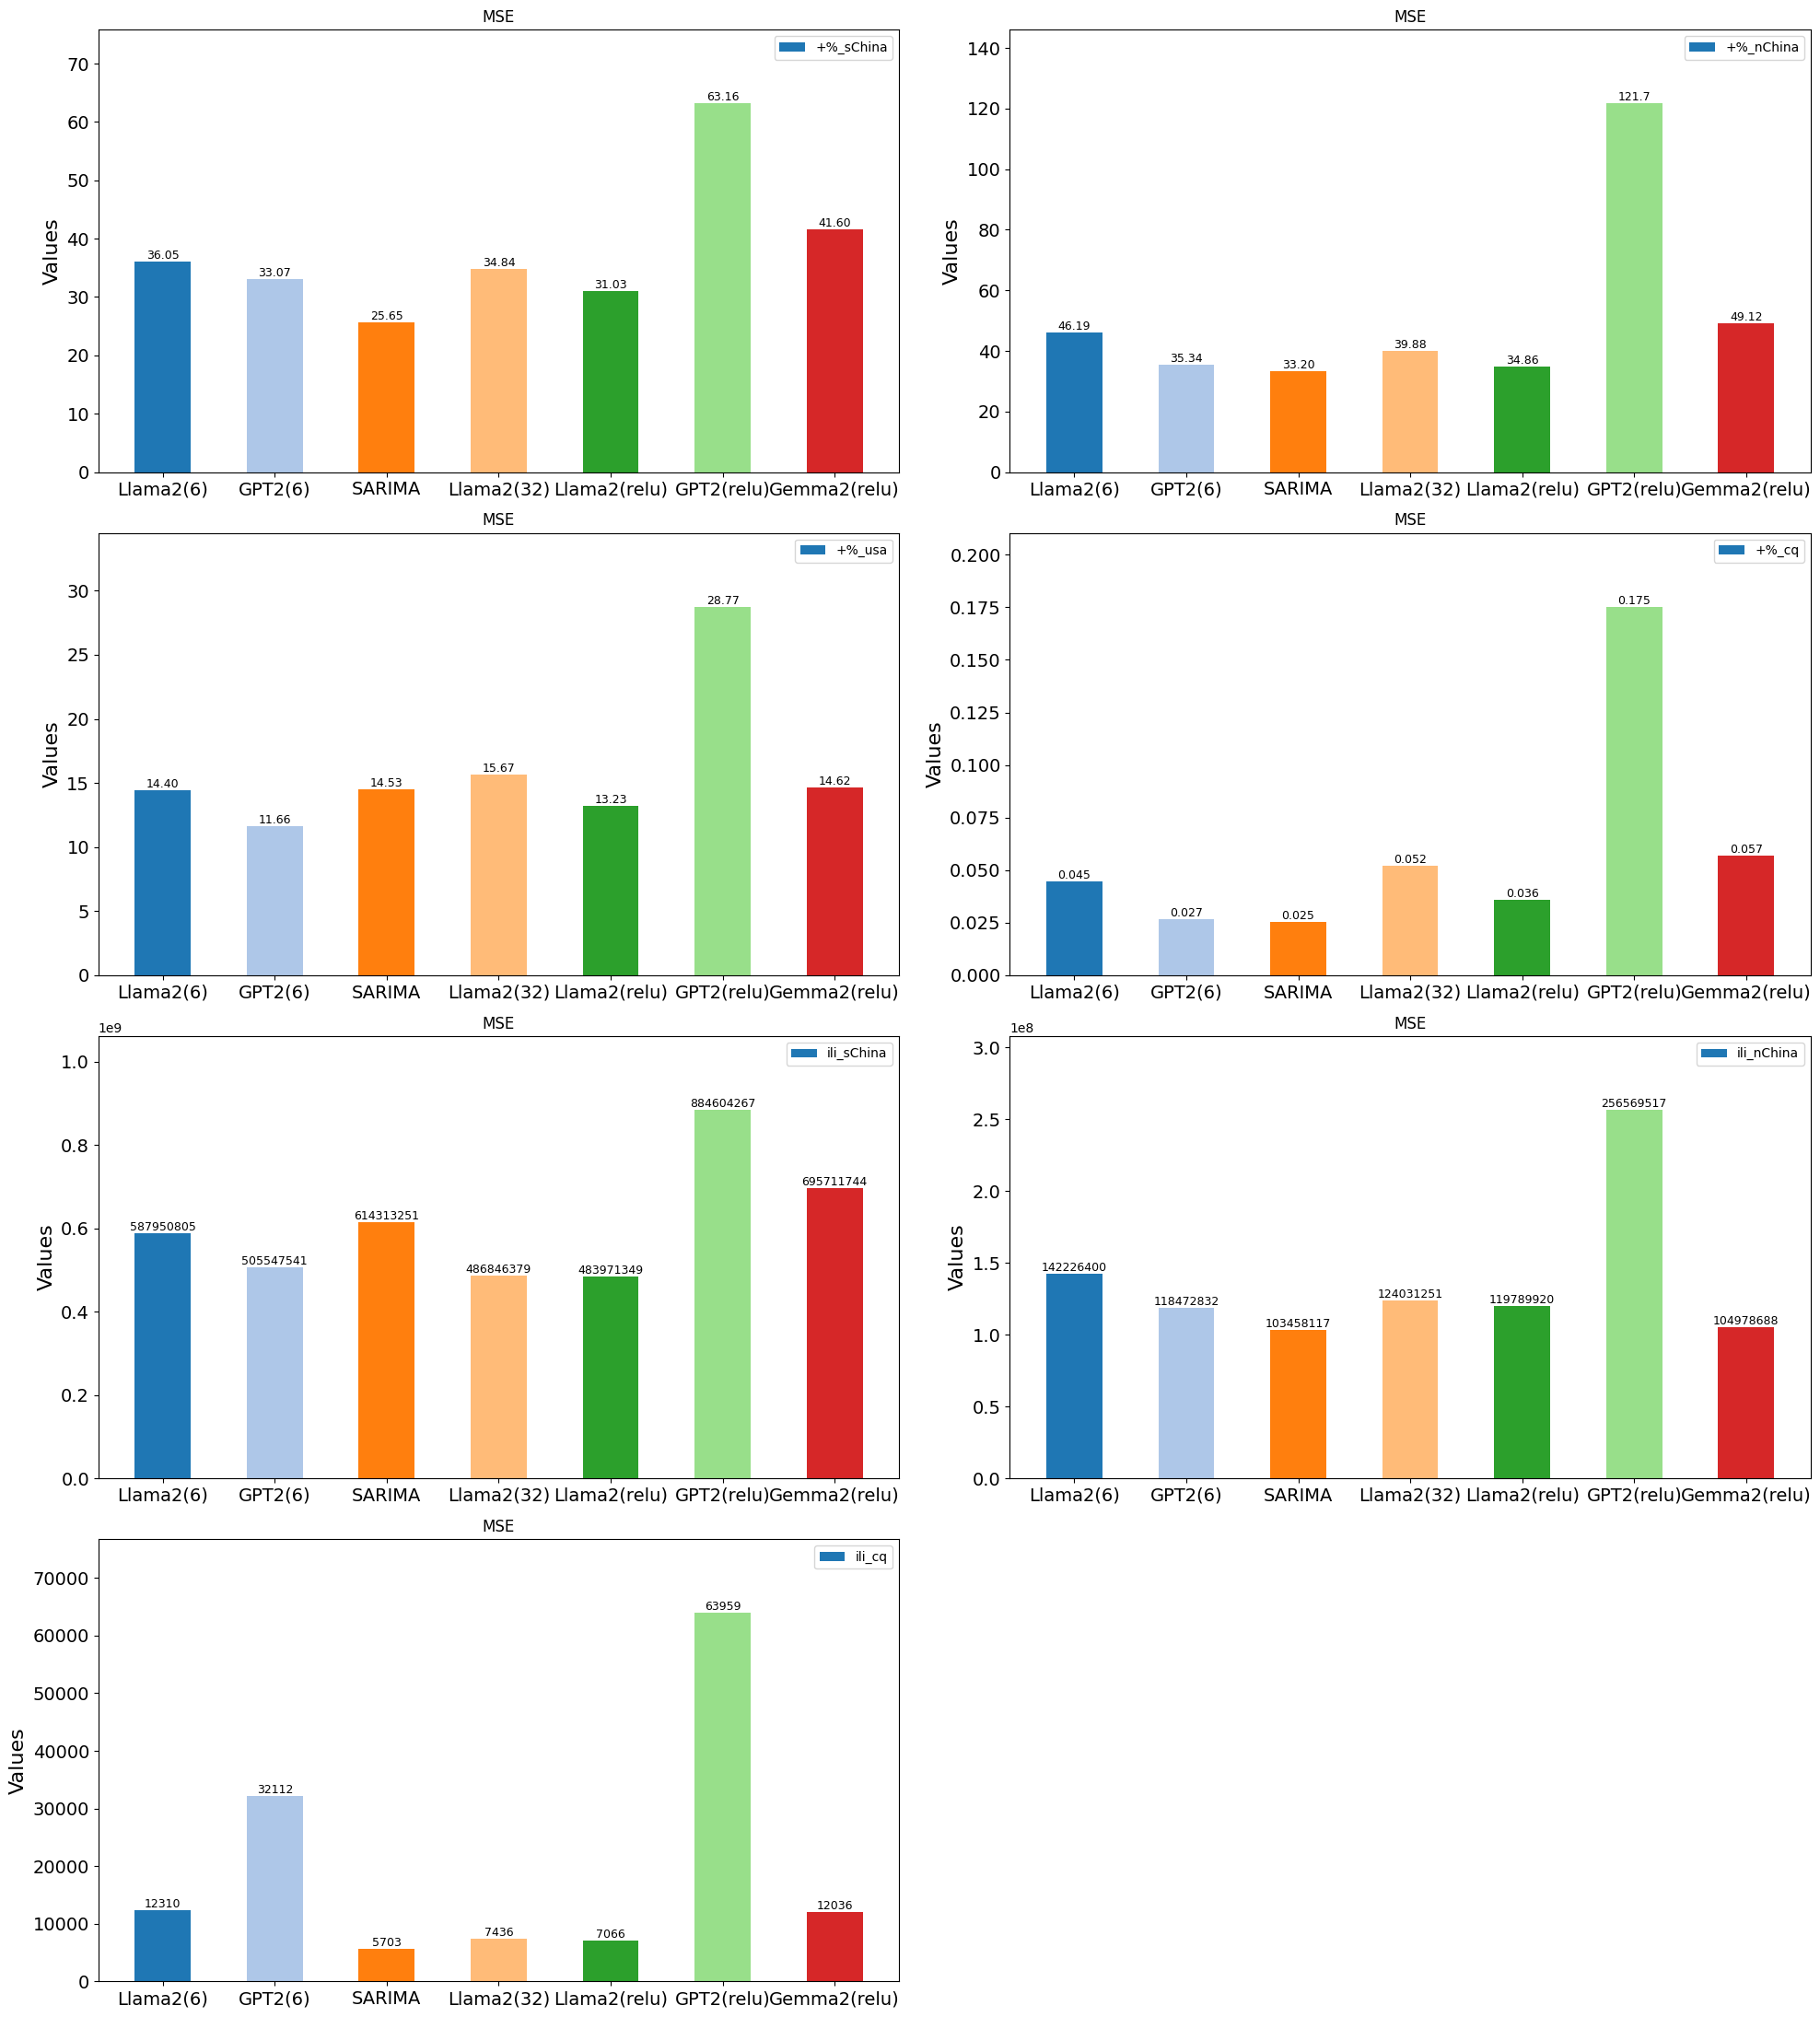

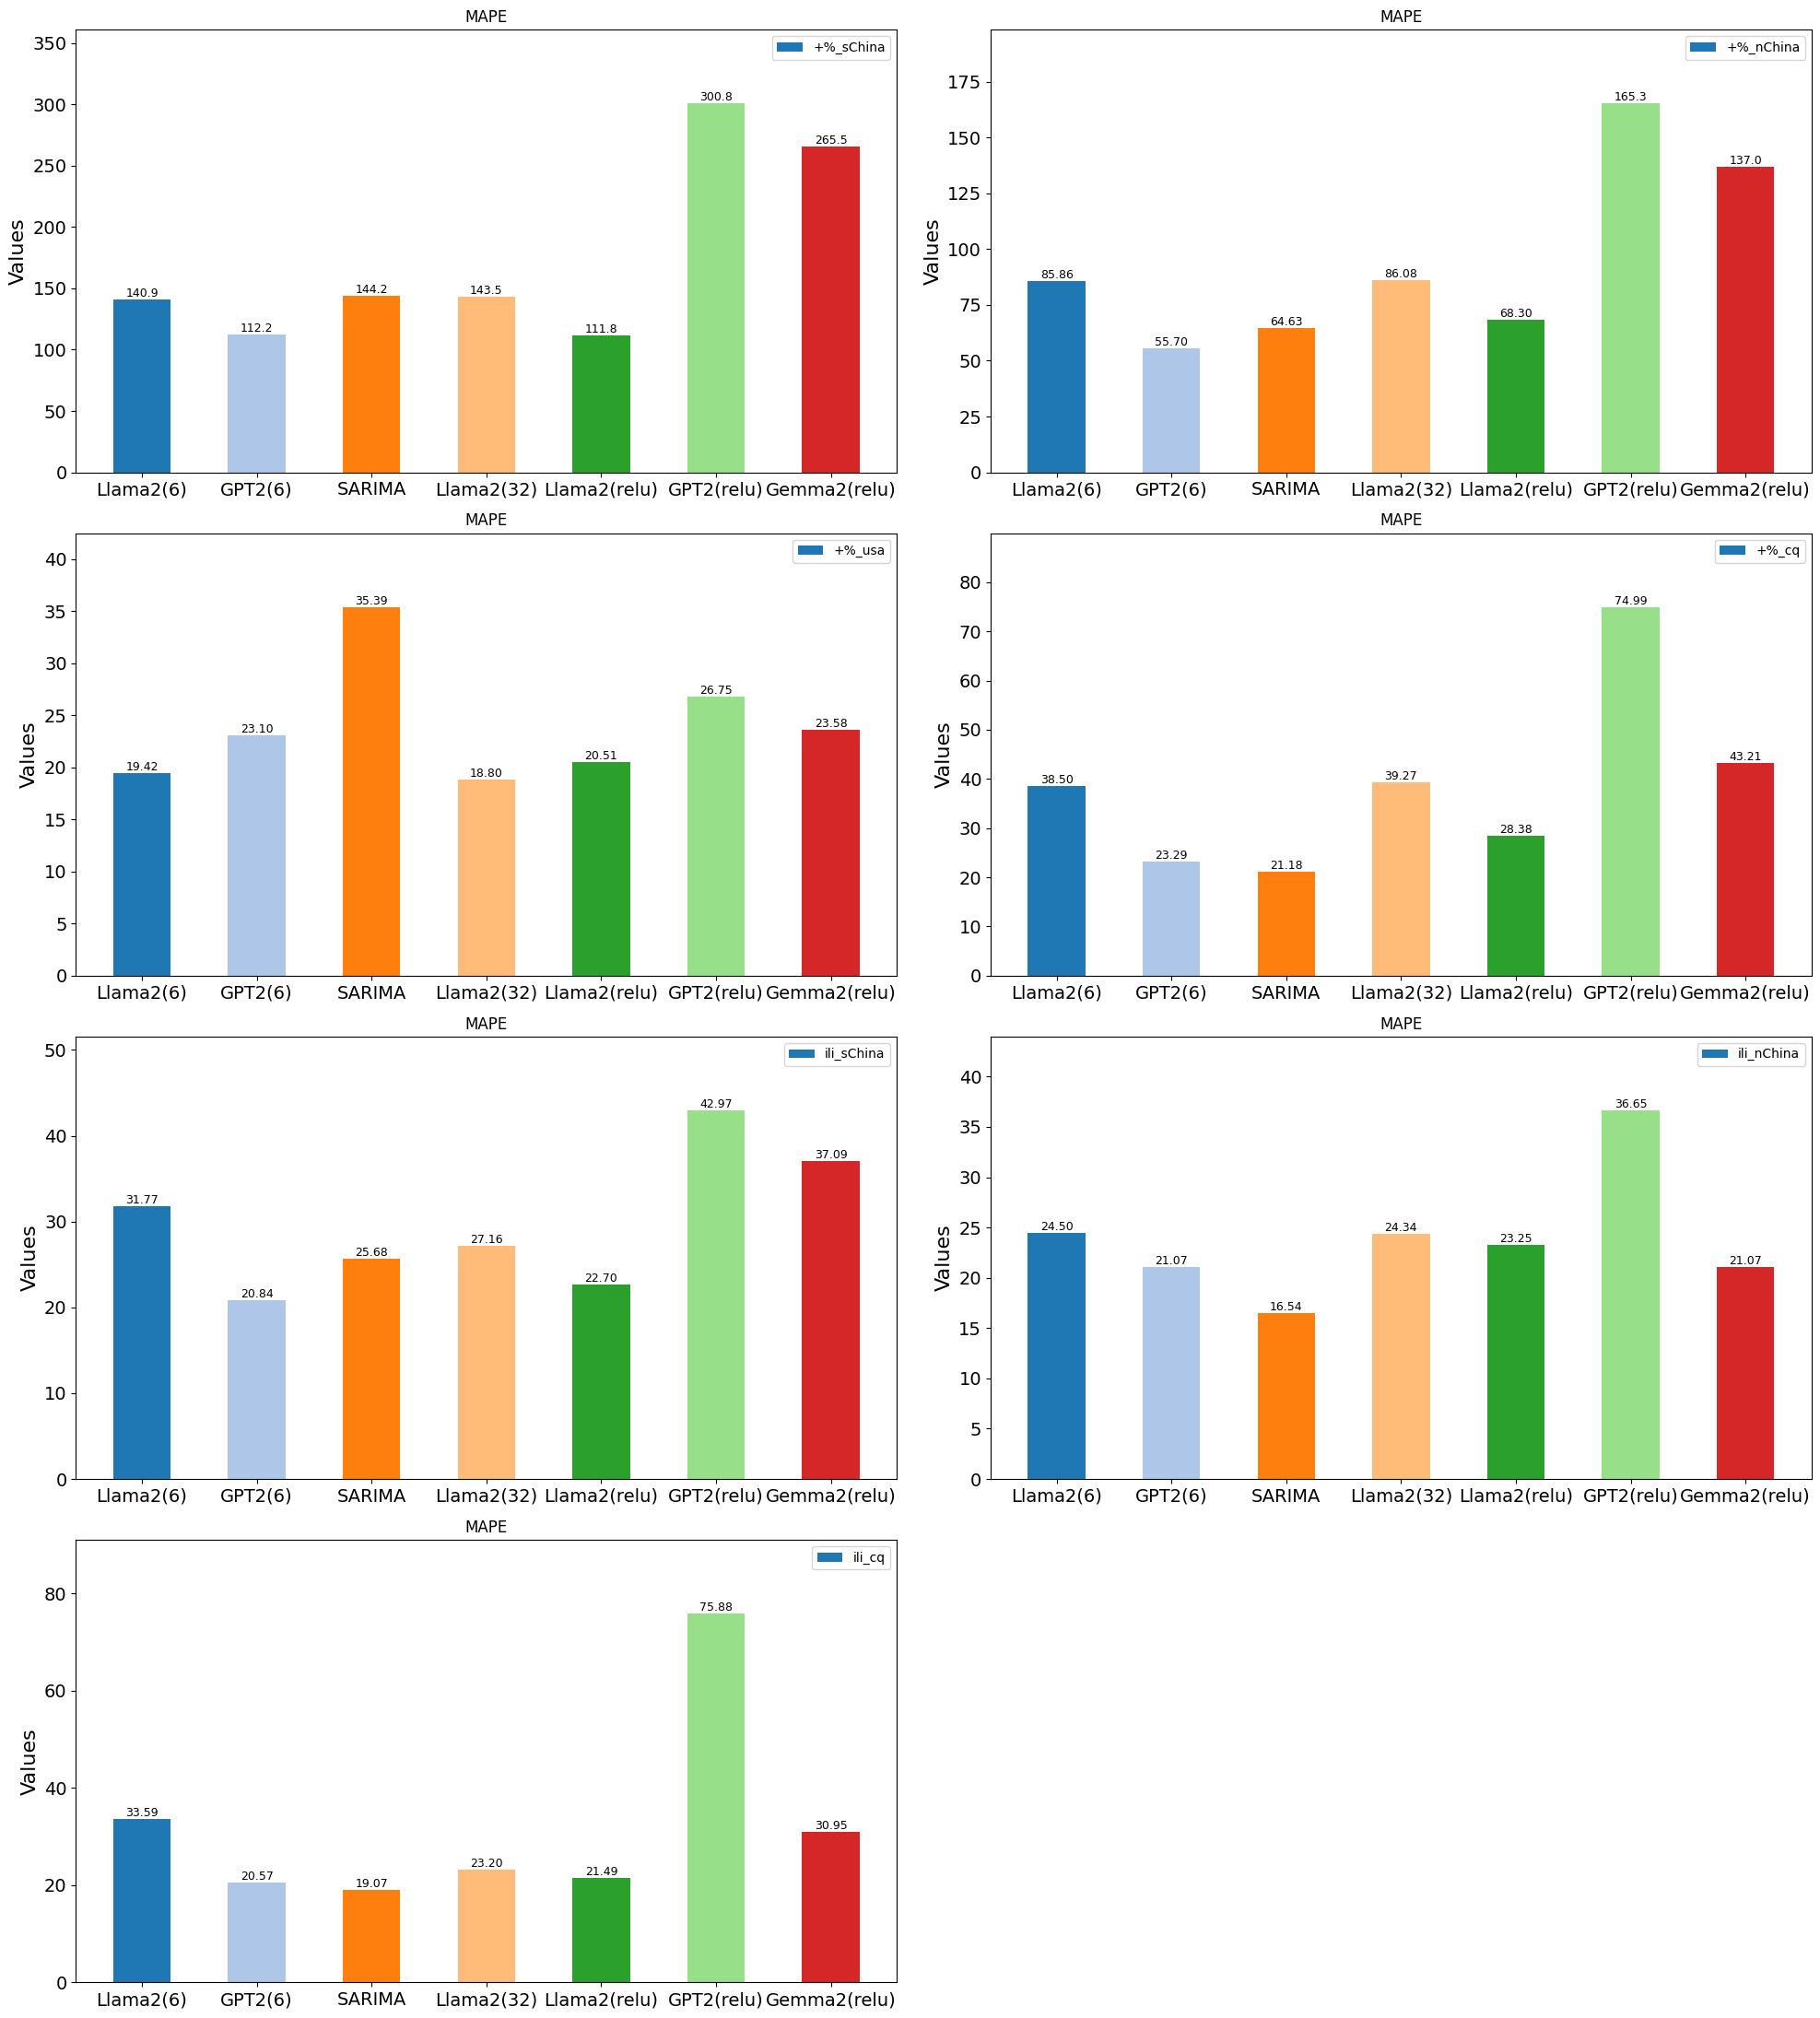

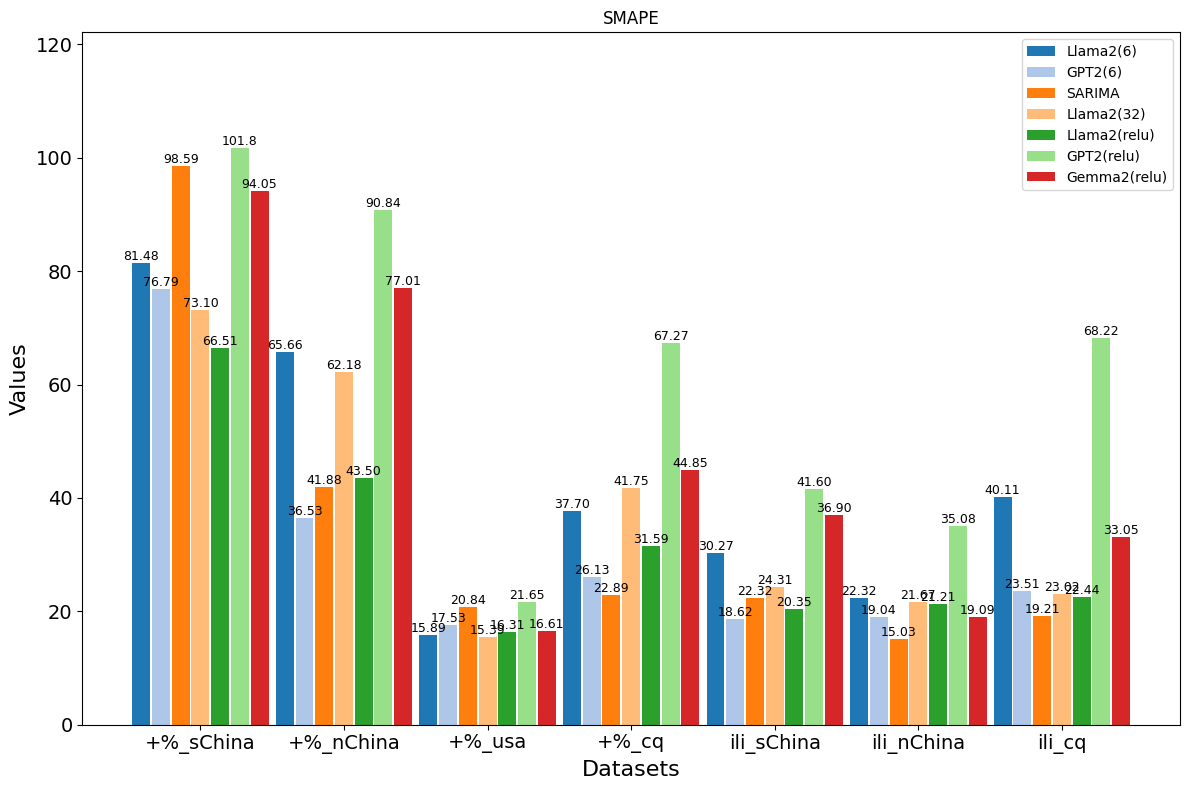

In [18]:
## inverse
visual2(dt4, '/data_disk/lichx/NeurIPS2023-One-Fits-All/Long-term_Forecasting/Output/png/no_train/inverse')

# loss

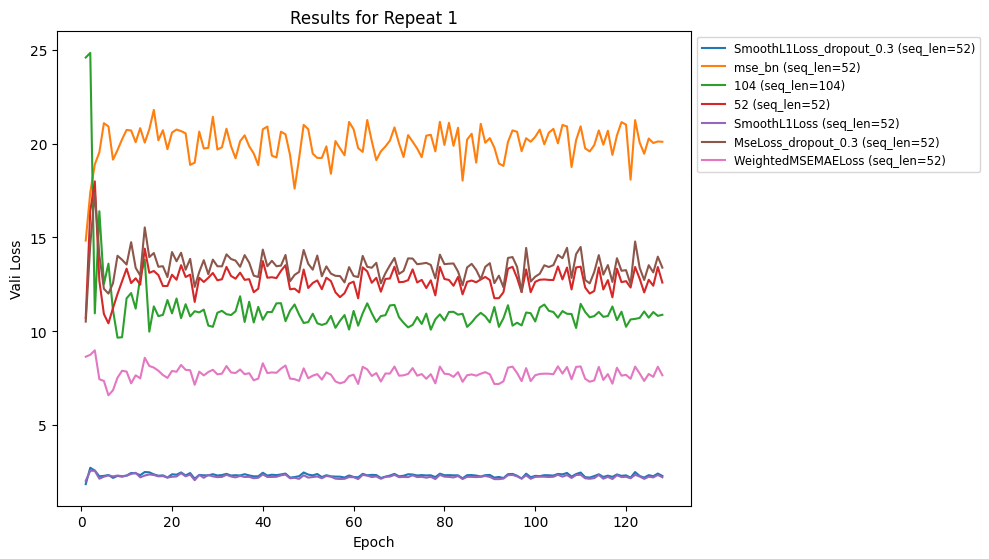

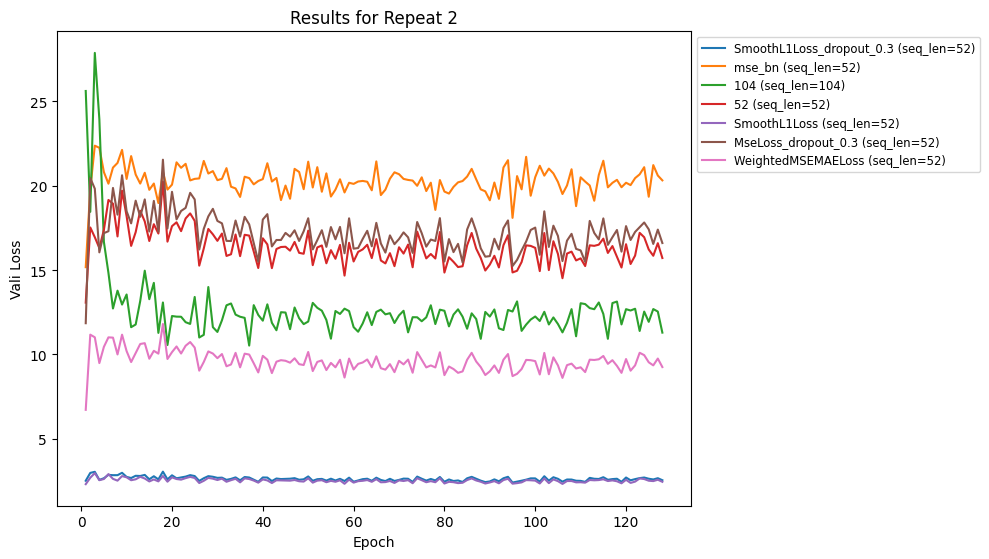

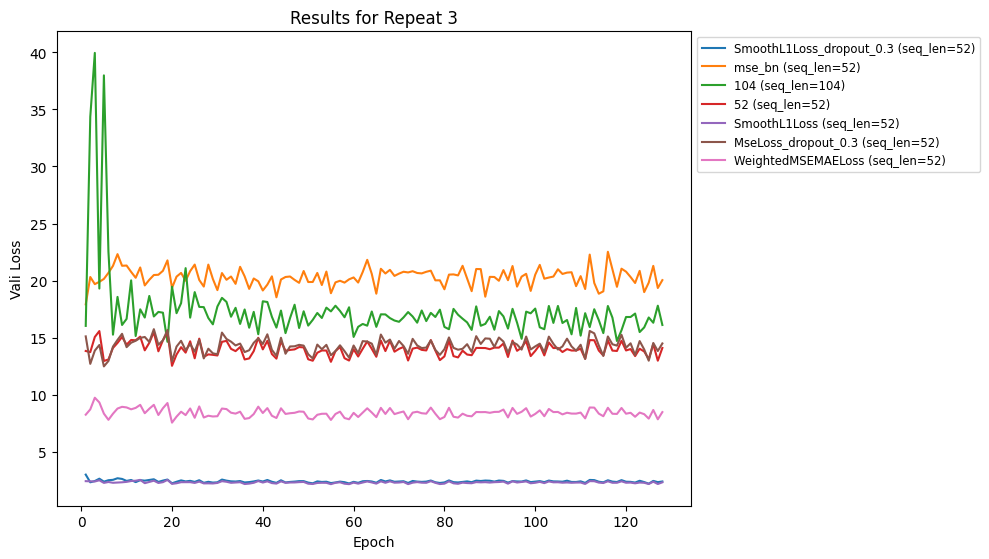

In [1]:
import os
import re
import matplotlib.pyplot as plt

# 定义要搜索的目录路径
log_dir = '/data_disk/lichx/NeurIPS2023-One-Fits-All/Long-term_Forecasting/Output/NorthChinaFlu'

# 定义正则表达式来匹配 seq_len 和 if_inverse
seq_len_re = re.compile(r'seq_len:\s*(\d+)')
if_inverse_re = re.compile(r'if_inverse:\s*(\d)')
vali_loss_re = re.compile(r'Vali Loss:\s*([\d.]+)')

# 存储数据
results = {}

# 遍历所有 .log 文件
for log_file in os.listdir(log_dir):
    # 仅处理以 'Llama2_relu' 开头并以 '.log' 结尾的文件
    if log_file.endswith('.log') and log_file.startswith('Llama2_relu'):
        file_path = os.path.join(log_dir, log_file)
        with open(file_path, 'r') as f:
            content = f.read()
            
            # 获取所有的 seq_len 和 if_inverse 匹配项
            seq_lens = seq_len_re.findall(content)
            if_inverses = if_inverse_re.findall(content)
            
            # 提取所有 Vali Loss
            vali_losses = vali_loss_re.findall(content)
            
            # 确保日志文件中有足够的 epoch 记录
            if len(vali_losses) == 128 * 6:  # 每个文件应该有6组（3次 if_inverse=0 和 3次 if_inverse=1）的128个epoch的vali loss
                for i in range(3):
                    # 仅存储 if_inverse = 0 的结果
                    if if_inverses[2 * i] == '0':  # 保留if_inverse=0的记录
                        key = (log_file, seq_lens[2 * i], if_inverses[2 * i], i + 1)
                        results[key] = list(map(float, vali_losses[128 * 2 * i:128 * (2 * i + 1)]))

# 绘制图表，只保留 if_inverse = 0 的结果
for repeat in range(1, 4):
    plt.figure(figsize=(10, 6))
    
    for key, losses in results.items():
        log_file, seq_len, if_inverse, rep = key
        if rep == repeat and if_inverse == '0':  # 仅绘制if_inverse=0的结果
            plt.plot(range(1, len(losses) + 1),
                     losses,
                     label=f'{log_file.split("Llama2_relu_before_")[1].split(".log")[0]} (seq_len={seq_len})')
    
    plt.title(f'Results for Repeat {repeat}')
    plt.xlabel('Epoch')
    plt.ylabel('Vali Loss')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


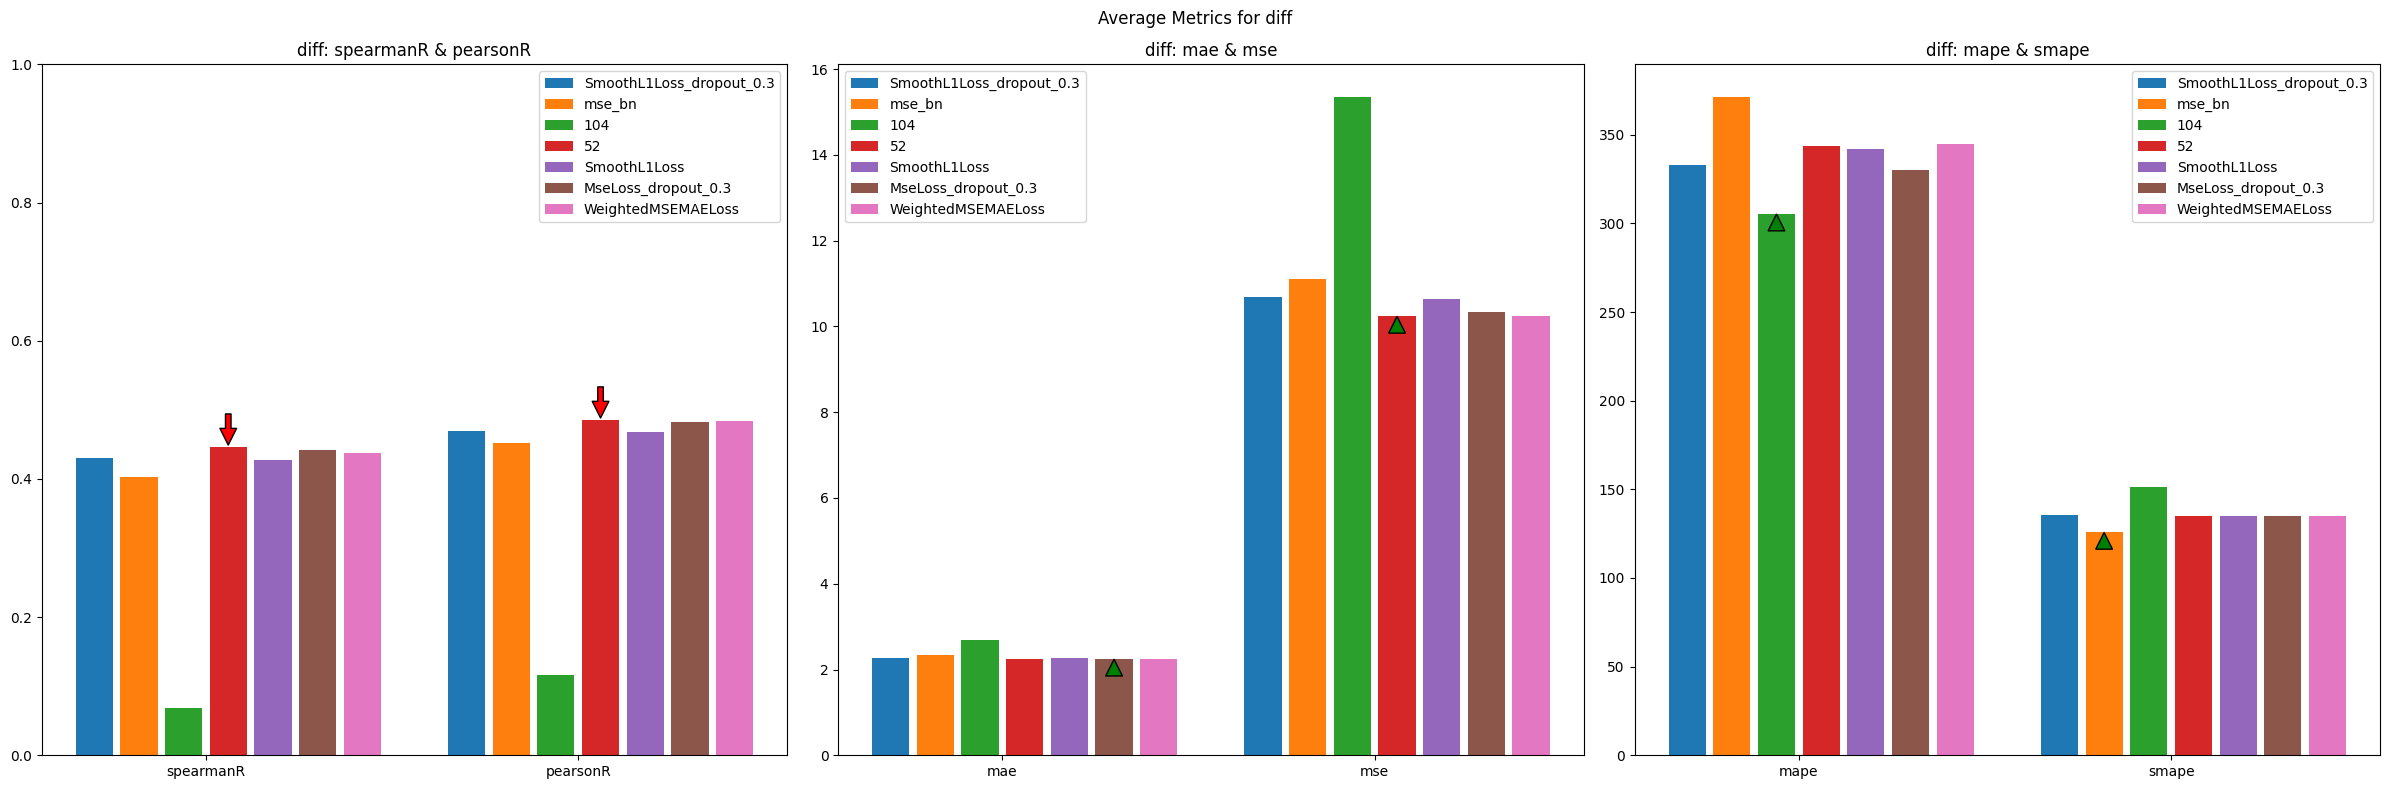

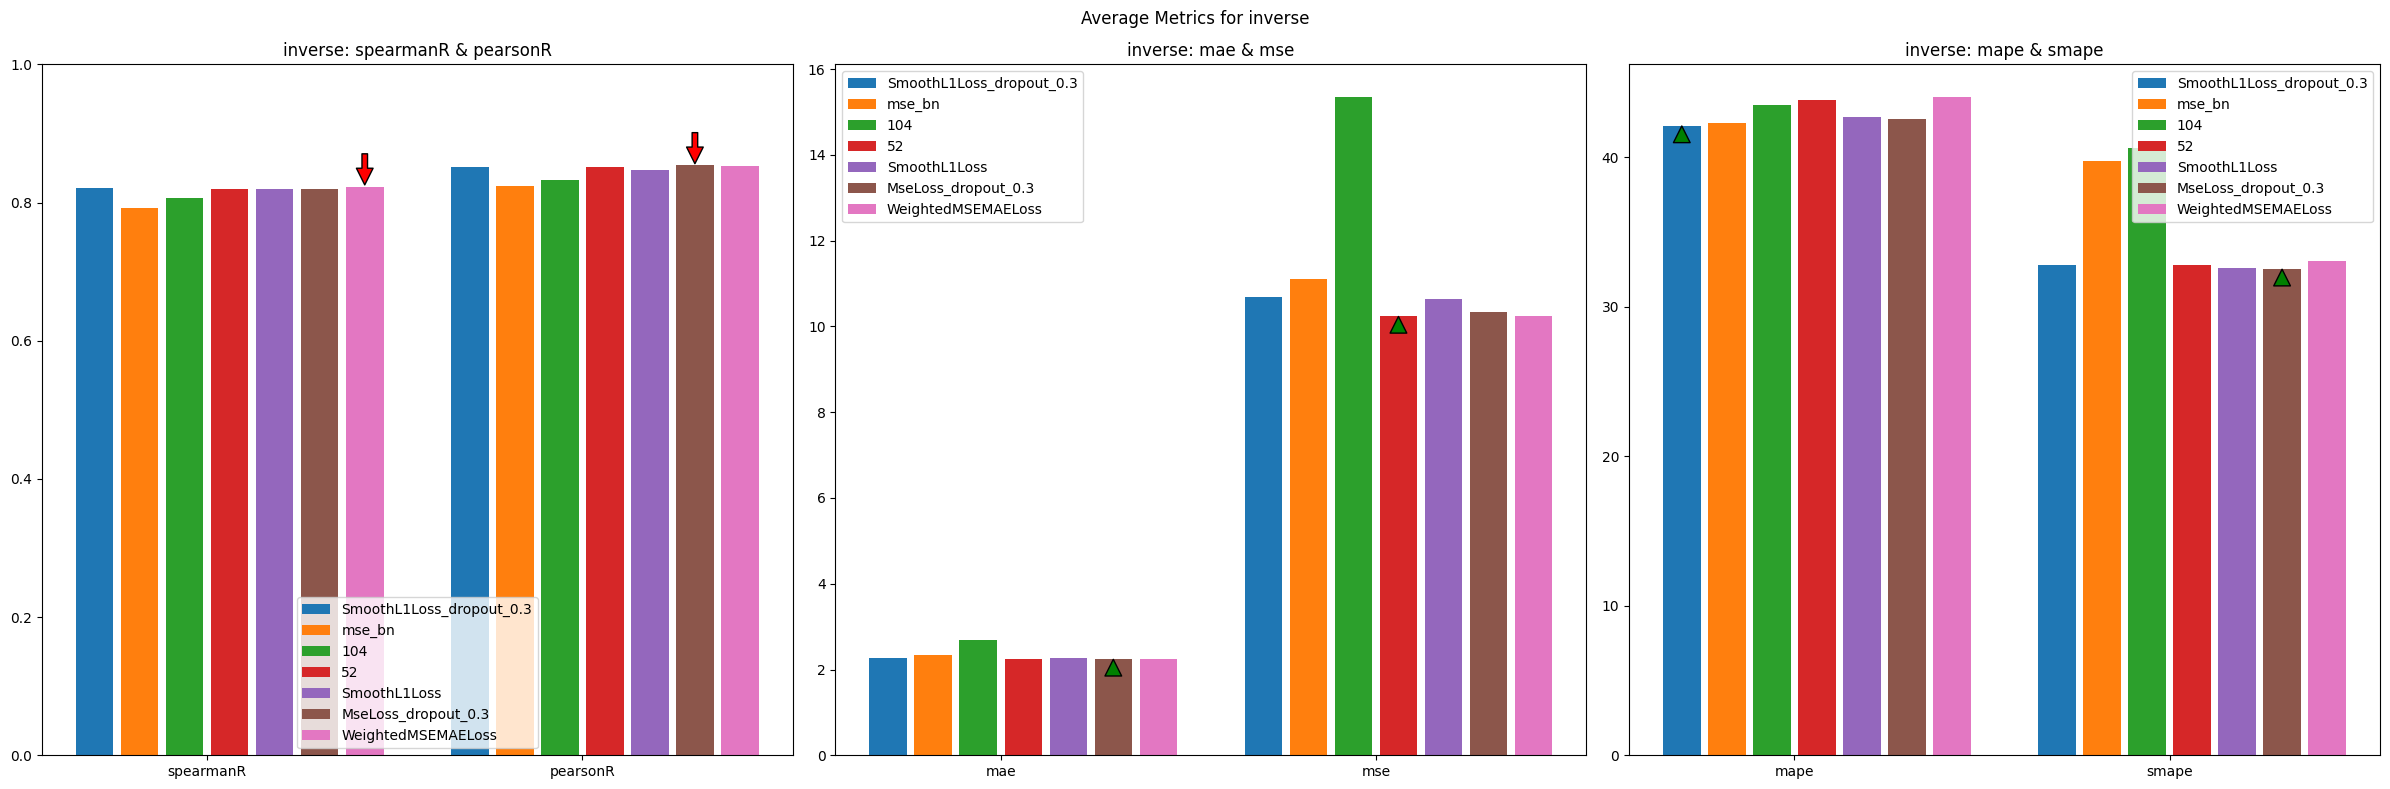

In [57]:
import os
import re
import matplotlib.pyplot as plt
import numpy as np

# 定义要搜索的目录路径
log_dir = '/data_disk/lichx/NeurIPS2023-One-Fits-All/Long-term_Forecasting/Output/NorthChinaFlu'

# 定义正则表达式来匹配 seq_len 和 if_inverse
seq_len_re = re.compile(r'seq_len:\s*(\d+)')
if_inverse_re = re.compile(r'if_inverse:\s*(\d)')
vali_loss_re = re.compile(r'Vali Loss:\s*([\d.]+)')

# 匹配每个实验的六个指标
metrics_re = re.compile(r'spearmanR:([\d.]+), pearsonR:([\d.]+)\s+mae:([\d.]+), mse:([\d.]+), mape:([\d.]+), smape:([\d.]+)')

# 存储数据
results = {}
metrics = {}

# 遍历所有 .log 文件
for log_file in os.listdir(log_dir):
    if log_file.endswith('.log') and log_file.startswith('Llama2_relu'):
        file_path = os.path.join(log_dir, log_file)
        with open(file_path, 'r') as f:
            content = f.read()
            
            # 获取所有的 seq_len 和 if_inverse 匹配项
            seq_lens = seq_len_re.findall(content)
            if_inverses = if_inverse_re.findall(content)
            
            # 提取所有 Vali Loss
            vali_losses = vali_loss_re.findall(content)
            
            # 提取所有指标
            all_metrics = metrics_re.findall(content)
            
            # 确保日志文件中有足够的 epoch 记录和指标
            if len(vali_losses) == 128 * 6 and len(all_metrics) == 6:
                # 将 all_metrics 分为 if_inverse = 0 和 if_inverse = 1 的结果
                metrics_0 = np.array(all_metrics[::2], dtype=float)  # if_inverse = 0 的指标
                metrics_1 = np.array(all_metrics[1::2], dtype=float)  # if_inverse = 1 的指标

                # 计算每个 if_inverse 的平均值
                avg_metrics_0 = metrics_0.mean(axis=0)
                avg_metrics_1 = metrics_1.mean(axis=0)

                # 存储结果
                metrics[log_file] = (avg_metrics_0, avg_metrics_1)

# 提取日志文件的名称列表
log_files = list(metrics.keys())

# 定义子图布局
def plot_metrics(ax, metric_names, metric_values, title, width=0.15, gap_between_files=0.03, gap_between_metrics=0.1, highlight_max_min=False):
    """
    ax: 子图
    metric_names: 指标名称列表
    metric_values: 指标值
    title: 图标题
    width: 每个柱子的宽度
    gap_between_files: 不同日志文件柱子之间的间隙
    gap_between_metrics: 不同指标之间的间隙
    highlight_max_min: 是否标记最大或最小值
    """
    # 生成 x 轴的位置，并添加不同指标之间的间隔
    x = np.arange(len(metric_names)) * (1 + gap_between_metrics)
    
    max_values = [float('-inf')] * len(metric_names)
    min_values = [float('inf')] * len(metric_names)
    max_indices = [0] * len(metric_names)
    min_indices = [0] * len(metric_names)
    
    for i, log_file in enumerate(log_files):
        # 调整 x 轴位置，确保不同日志文件的柱子不会重叠
        values = metric_values[log_file]
        ax.bar(x + i * (width + gap_between_files), values, width, label=log_file.split("Llama2_relu_before_")[1].split(".log")[0])
        
        if highlight_max_min:
            # 查找每个指标的最大值和最小值
            for j, value in enumerate(values):
                if value > max_values[j]:
                    max_values[j] = value
                    max_indices[j] = i  # 记录最大值对应的柱子的索引
                if value < min_values[j]:
                    min_values[j] = value
                    min_indices[j] = i  # 记录最小值对应的柱子的索引

    # 标记出最大值（spearmanR 和 pearsonR）或最小值（其他指标）
    if highlight_max_min:
        for j, metric_name in enumerate(metric_names):
            if "spearmanR" in metric_name or "pearsonR" in metric_name:
                # 在最大值柱子上方添加箭头
                ax.annotate('', xy=(x[j] + max_indices[j] * (width + gap_between_files), max_values[j]),
                            xytext=(x[j] + max_indices[j] * (width + gap_between_files), max_values[j] + 0.05),
                            arrowprops=dict(facecolor='red', shrink=0.05))
            else:
                # 在最小值柱子上方添加箭头
                ax.annotate('', xy=(x[j] + min_indices[j] * (width + gap_between_files), min_values[j]),
                            xytext=(x[j] + min_indices[j] * (width + gap_between_files), min_values[j] - 0.05),
                            arrowprops=dict(facecolor='green', shrink=0.05))
    
    ax.set_xticks(x + width * (len(log_files) - 1) / 2)
    ax.set_xticklabels(metric_names)
    ax.set_title(title)
    ax.legend()

# 调整图像大小，增大宽度
fig, axs = plt.subplots(1, 3, figsize=(24, 8))

# 子图1：spearmanR 和 pearsonR
metric_names = ['spearmanR', 'pearsonR']
metric_values_0 = {log_file: metrics[log_file][0][:2] for log_file in log_files}  # if_inverse = 0 的 spearmanR 和 pearsonR
plot_metrics(axs[0], metric_names, metric_values_0, 'diff: spearmanR & pearsonR', gap_between_metrics=0.5, highlight_max_min=True)
axs[0].set_ylim(0, 1)  # 设置y轴的范围为[0, 1]

# 子图2：mae 和 mse
metric_names = ['mae', 'mse']
metric_values_0 = {log_file: metrics[log_file][0][2:4] for log_file in log_files}  # if_inverse = 0 的 mae 和 mse
plot_metrics(axs[1], metric_names, metric_values_0, 'diff: mae & mse', gap_between_metrics=0.5, highlight_max_min=True)

# 子图3：mape 和 smape
metric_names = ['mape', 'smape']
metric_values_0 = {log_file: metrics[log_file][0][4:6] for log_file in log_files}  # if_inverse = 0 的 mape 和 smape
plot_metrics(axs[2], metric_names, metric_values_0, 'diff: mape & smape', gap_between_metrics=0.5, highlight_max_min=True)

plt.suptitle('Average Metrics for diff')
plt.tight_layout()
plt.show()

# 绘制 if_inverse = 1 的三张子图
fig, axs = plt.subplots(1, 3, figsize=(24, 8))

# 子图1：spearmanR 和 pearsonR
metric_names = ['spearmanR', 'pearsonR']
metric_values_1 = {log_file: metrics[log_file][1][:2] for log_file in log_files}  # if_inverse = 1 的 spearmanR 和 pearsonR
plot_metrics(axs[0], metric_names, metric_values_1, 'inverse: spearmanR & pearsonR', gap_between_metrics=0.5, highlight_max_min=True)
axs[0].set_ylim(0, 1)  # 设置y轴的范围为[0, 1]

# 子图2：mae 和 mse
metric_names = ['mae', 'mse']
metric_values_1 = {log_file: metrics[log_file][1][2:4] for log_file in log_files}  # if_inverse = 1 的 mae 和 mse
plot_metrics(axs[1], metric_names, metric_values_1, 'inverse: mae & mse', gap_between_metrics=0.5, highlight_max_min=True)

# 子图3：mape 和 smape
metric_names = ['mape', 'smape']
metric_values_1 = {log_file: metrics[log_file][1][4:6] for log_file in log_files}  # if_inverse = 1 的 mape 和 smape
plot_metrics(axs[2], metric_names, metric_values_1, 'inverse: mape & smape', gap_between_metrics=0.5, highlight_max_min=True)

plt.suptitle('Average Metrics for inverse')
plt.tight_layout()
plt.show()


## pca

In [2]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import os

# 设备设置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 数据加载路径
base_path = '/data_disk/lichx/GPT4/diff_with_space/embeddings_per_timesteps/'
dataset_names = ['ILI_NorthChina', 'ILI_SouthChina', 'USA', 'Weekly', 'NorthChina', 'SouthChina', 'positive_rate']

# 可视化降维方法
def visualize_embedding(embedded_values,
    method='PCA',
    n_components=2,
    output_path='/data_disk/lichx/GPT4/diff_with_space/output_visual/pca/',
    dataset='USA'
    ):
    # Step 1: Initialize the reducer based on the selected method
    if method == 'PCA':
        reducer = PCA(n_components=n_components)
    elif method == 't-SNE':
        reducer = TSNE(n_components=n_components, init='pca', learning_rate='auto')  # Explicitly set parameters
    elif method == 'UMAP':
        reducer = umap.UMAP(n_components=n_components, n_neighbors=15, min_dist=0.1)  # Example parameters
    else:
        raise ValueError("Unsupported method: Choose from 'PCA', 't-SNE', or 'UMAP'.")
    
    # Apply dimensionality reduction
    reduced_data = reducer.fit_transform(embedded_values)

    # Plot the reduced data
    plt.figure(figsize=(8, 6))
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=np.arange(len(reduced_data)), cmap='viridis')
    plt.colorbar(label='Time Step')
    plt.title(f'{method} visualization of Embeddings')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')

    # Ensure the output directory exists
    os.makedirs(output_path, exist_ok=True)

    # Save the figure
    output_file = os.path.join(output_path, f'{dataset}_{method}_embedding.png')
    plt.savefig(output_file)
    plt.close()

    print(f"Figure saved to: {output_file}")

# 加载数据并可视化
for dataset in dataset_names:
    embedding_file_path = base_path + f'{dataset}_diff_embedded.csv'
    embedded_data = pd.read_csv(embedding_file_path, header=None)
    embedded_values = embedded_data.values

    # 打印嵌入数据的形状
    print(f"Shape of {dataset} embeddings: {embedded_values.shape}")

    # 可视化并保存图像
    visualize_embedding(embedded_values, method='PCA', n_components=2, dataset=dataset)
    visualize_embedding(embedded_values, method='t-SNE', n_components=2, dataset=dataset)
    visualize_embedding(embedded_values, method='UMAP', n_components=2, dataset=dataset)


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f85c40cf670>>
Traceback (most recent call last):
  File "/home/lichx/anaconda3/envs/llm4ts/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


Shape of ILI_NorthChina embeddings: (415, 1536)
Figure saved to: /data_disk/lichx/GPT4/diff_with_space/output_visual/pca/ILI_NorthChina_PCA_embedding.png


/home/lichx/anaconda3/envs/llm4ts/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


Figure saved to: /data_disk/lichx/GPT4/diff_with_space/output_visual/pca/ILI_NorthChina_t-SNE_embedding.png


In [1]:
from transformers.models.gpt2.modeling_gpt2 import GPT2Model
from transformers import AutoTokenizer, GPT2Tokenizer
import warnings
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

warnings.filterwarnings("ignore", category=FutureWarning)

In [35]:
def read_embedded_file(embedded_file):
    embeddings = []
    with open(embedded_file, 'r', encoding='utf-8') as f:
        for line in f:
            embedding = [float(x) for x in line.strip().split(',')]
            embeddings.append(embedding)
    return np.array(embeddings)

def load_real_data(dataset_name, real_base_path):
    real_file_path = os.path.join(real_base_path, f"{dataset_name}_diff.csv")
    # real_file_path = os.path.join(real_base_path, f"{dataset_name}.csv")
    if os.path.exists(real_file_path):
        real_data = pd.read_csv(real_file_path)
        return real_data.iloc[:, 1].values  # 获取CSV文件的第二列作为真实值
    else:
        print(f"File {real_file_path} not found!")
        return None

def create_sequences(embeddings, real_values, time_steps=52):
    sequences = []
    labels = []
    for i in range(len(embeddings) - time_steps):
        seq = embeddings[i:i+time_steps]  # 使用前 52 个时间步的嵌入数据
        label = real_values[i+time_steps]  # 用第 53 个时间步的真实值作为标签
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

def split_data_new(real_values, train_ratio=0.8, time_steps=52):
    num_train = int(len(real_values) * train_ratio)
    num_test = len(real_values) - num_train

    # 划分训练集
    train_sequences = real_values[:num_train]
    # train_sequences, train_labels = create_sequences(train_embeddings, train_real_values, time_steps)

    # 划分测试集
    test_sequences = real_values[num_train-time_steps:]
    # test_sequences, test_labels = create_sequences(test_embeddings, test_real_values, time_steps)

    return train_sequences, test_sequences

def visualize_embedding(embedded_values, method='PCA', n_components=2, output_path=None, num=3):
    # Step 1: Initialize the reducer based on the selected method
    if method == 'PCA':
        reducer = PCA(n_components=n_components)
        met = 'pca'
    elif method == 't-SNE':
        reducer = TSNE(n_components=n_components, init='pca', learning_rate='auto')  # Explicitly set parameters
        met = 'tsne'
    elif method == 'UMAP':
        reducer = umap.UMAP(n_components=n_components, n_neighbors=15, min_dist=0.1)  # Example parameters
        met = 'umap'
    else:
        raise ValueError("Unsupported method: Choose from 'PCA', 't-SNE', or 'UMAP'.")
    
    reduced_data = reducer.fit_transform(embedded_values)

    # 绘制结果
    plt.figure(figsize=(8, 6))
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=np.arange(len(reduced_data)), cmap='viridis')
    plt.colorbar(label='Time Step')
    plt.title(f'{method} visualization of Embeddings')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    
    output_path='/data_disk/lichx/GPT4/diff_with_space/output_visual/gpt2embedding_visual/'
    output_file = os.path.join(output_path, f'{met}_{num}.png')
    plt.savefig(output_file)

    # if output_path:
    #     plt.savefig(output_path)
    # else:
    #     plt.show()
    
    plt.close()
    

Processing dataset: USA
Shape of the embeddings: torch.Size([1, 415, 768])
Shape of the embeddings: (415, 768)


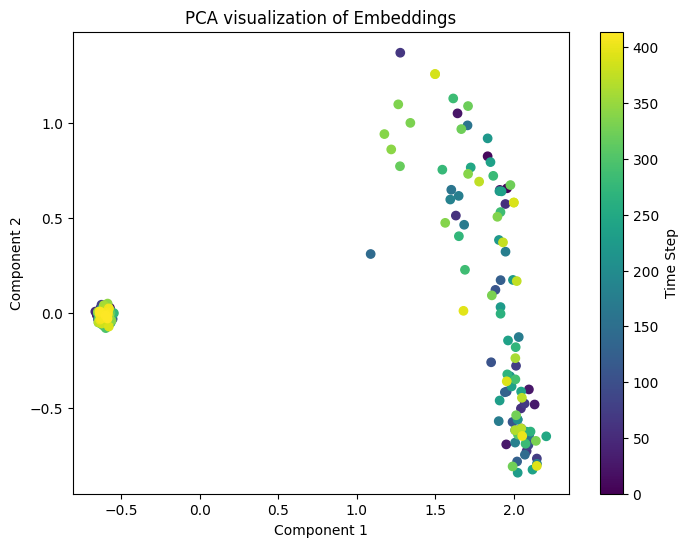

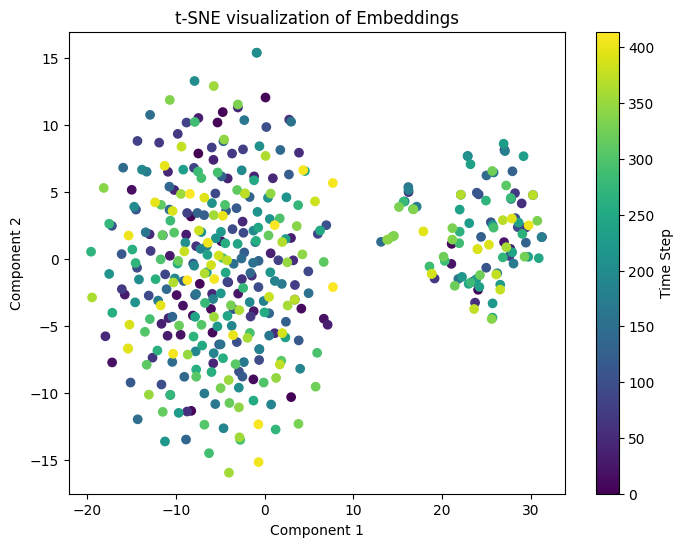

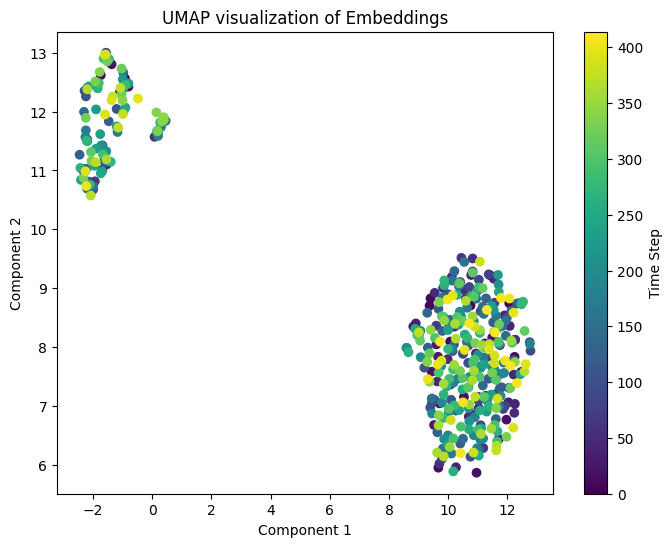

In [28]:
# dataset_names = ['ILI_NorthChina', 'ILI_SouthChina', 'USA', 'Weekly', 'NorthChina', 'SouthChina', 'positive_rate']
dataset_names = ['USA']
# 数据路径
real_base_path = '/data_disk/lichx/GPT4/diff_with_space/all_dataset/'

for dataset in dataset_names:
    print(f"Processing dataset: {dataset}")

    real_values = load_real_data(dataset, real_base_path)
    input_str = [str(v) for v in (real_values*1e3).astype(int)]
    # input_str = [str(round(v, 3)) for v in real_values]

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    path = '/data_disk/lichx/Model_from_HF/GPT2'

    gpt2 = GPT2Model.from_pretrained(path, output_attentions=True, output_hidden_states=True).to(device)
    tokenizer = GPT2Tokenizer.from_pretrained(path)
    tokenizer.pad_token = tokenizer.eos_token
    special_tokens = input_str
    tokenizer.add_special_tokens({'additional_special_tokens': special_tokens})
    gpt2.resize_token_embeddings(len(tokenizer))
    
    input_ids = tokenizer(input_str, return_tensors='pt', padding=True, truncation=True).to(device)['input_ids']

    # 获取嵌入
    with torch.no_grad():
        wte = gpt2.wte(input_ids)

    # 获取整个序列的嵌入
    embeddings = wte.squeeze(1).unsqueeze(0)  # shape: (1, sequence_length, embedding_dim)
    print(f"Shape of the embeddings: {embeddings.shape}")

    embeddings = embeddings.squeeze(0).cpu().numpy()  # 将 shape 转换为 (415, 768)
    print(f"Shape of the embeddings: {embeddings.shape}")

    # 可视化 PCA
    visualize_embedding(embeddings, method='PCA', n_components=2)

    # 可视化 t-SNE
    visualize_embedding(embeddings, method='t-SNE', n_components=2)

    # 可视化 UMAP
    visualize_embedding(embeddings, method='UMAP', n_components=2)

Processing dataset: USA
Shape of the embeddings: torch.Size([1, 415, 768])
Shape of the embeddings: (415, 768)


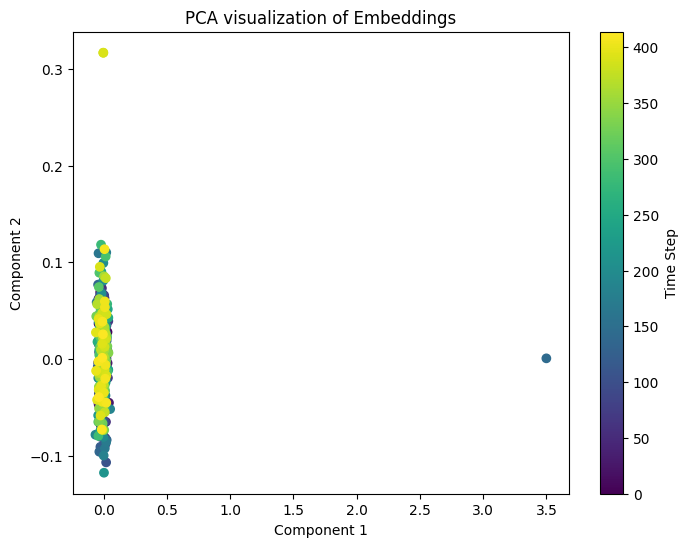

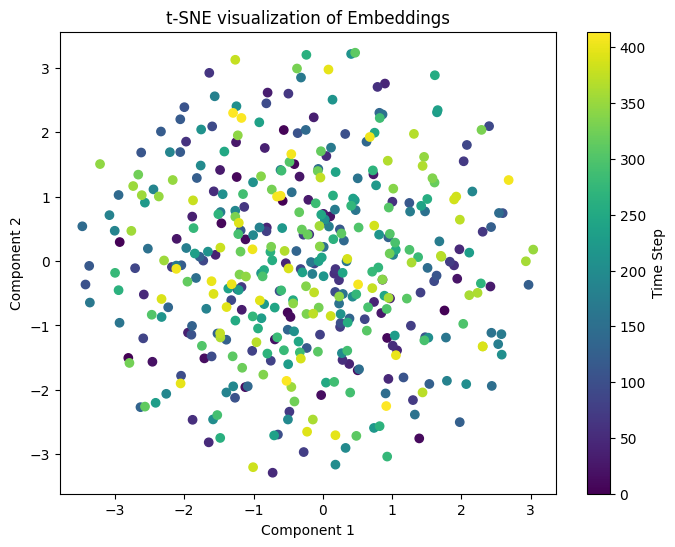

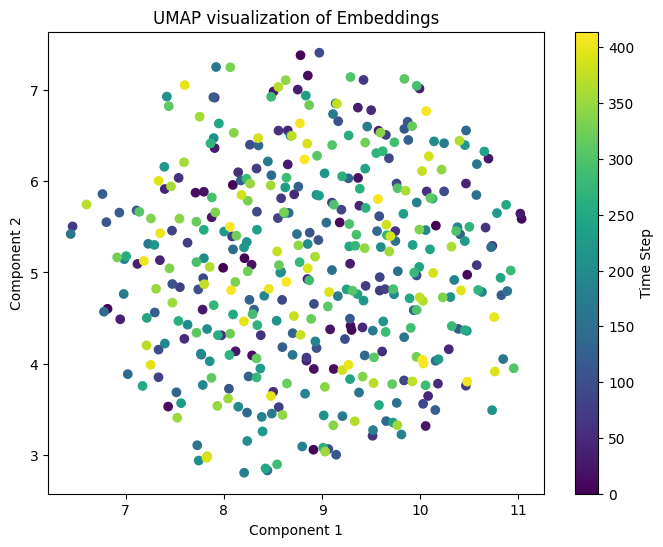

In [29]:
# dataset_names = ['ILI_NorthChina', 'ILI_SouthChina', 'USA', 'Weekly', 'NorthChina', 'SouthChina', 'positive_rate']
dataset_names = ['USA']
# 数据路径
real_base_path = '/data_disk/lichx/GPT4/diff_with_space/all_dataset/'

for dataset in dataset_names:
    print(f"Processing dataset: {dataset}")

    real_values = load_real_data(dataset, real_base_path)
    input_str = [str(v) for v in (real_values*1e5).astype(int)]
    # input_str = [str(round(v, 3)) for v in real_values]

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    path = '/data_disk/lichx/Model_from_HF/GPT2'

    gpt2 = GPT2Model.from_pretrained(path, output_attentions=True, output_hidden_states=True).to(device)
    tokenizer = GPT2Tokenizer.from_pretrained(path)
    tokenizer.pad_token = tokenizer.eos_token
    special_tokens = input_str
    tokenizer.add_special_tokens({'additional_special_tokens': special_tokens})
    gpt2.resize_token_embeddings(len(tokenizer))
    
    input_ids = tokenizer(input_str, return_tensors='pt', padding=True, truncation=True).to(device)['input_ids']

    # 获取嵌入
    with torch.no_grad():
        wte = gpt2.wte(input_ids)

    # 获取整个序列的嵌入
    embeddings = wte.squeeze(1).unsqueeze(0)  # shape: (1, sequence_length, embedding_dim)
    print(f"Shape of the embeddings: {embeddings.shape}")

    embeddings = embeddings.squeeze(0).cpu().numpy()  # 将 shape 转换为 (415, 768)
    print(f"Shape of the embeddings: {embeddings.shape}")

    # 可视化 PCA
    visualize_embedding(embeddings, method='PCA', n_components=2)

    # 可视化 t-SNE
    visualize_embedding(embeddings, method='t-SNE', n_components=2)

    # 可视化 UMAP
    visualize_embedding(embeddings, method='UMAP', n_components=2)

In [3]:
import pandas as pd
embedding_file_path = '/data_disk/lichx/GPT4/diff_with_space/embeddings_per_timesteps/USA_diff_embedded.csv'
embedded_data = pd.read_csv(embedding_file_path, header=None)
embedded_values = embedded_data.values
embedded_values.shape

(415, 1536)

In [36]:
# dataset_names = ['ILI_NorthChina', 'ILI_SouthChina', 'USA', 'Weekly', 'NorthChina', 'SouthChina', 'positive_rate']
dataset_names = ['USA']
# 数据路径
real_base_path = '/data_disk/lichx/GPT4/diff_with_space/all_dataset/'

for dataset in dataset_names:
    print(f"Processing dataset: {dataset}")

    real_values = load_real_data(dataset, real_base_path)
    input_str = [str(v) for v in (real_values*1e4).astype(int)]
    # input_str = [str(round(v, 3)) for v in real_values]

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    path = '/data_disk/lichx/Model_from_HF/GPT2'

    gpt2 = GPT2Model.from_pretrained(path, output_attentions=True, output_hidden_states=True).to(device)
    tokenizer = GPT2Tokenizer.from_pretrained(path)
    tokenizer.pad_token = tokenizer.eos_token
    special_tokens = input_str
    tokenizer.add_special_tokens({'additional_special_tokens': special_tokens})
    gpt2.resize_token_embeddings(len(tokenizer))
    
    input_ids = tokenizer(input_str, return_tensors='pt', padding=True, truncation=True).to(device)['input_ids']

    # 获取嵌入
    with torch.no_grad():
        wte = gpt2.wte(input_ids)

    # 获取整个序列的嵌入
    embeddings = wte.squeeze(1).unsqueeze(0)  # shape: (1, sequence_length, embedding_dim)
    print(f"Shape of the embeddings: {embeddings.shape}")

    embeddings = embeddings.squeeze(0).cpu().numpy()  # 将 shape 转换为 (415, 768)
    print(f"Shape of the embeddings: {embeddings.shape}")

    # 可视化 PCA
    visualize_embedding(embeddings, method='PCA', n_components=2, num=4)

    # 可视化 t-SNE
    visualize_embedding(embeddings, method='t-SNE', n_components=2, num=4)

    # 可视化 UMAP
    visualize_embedding(embeddings, method='UMAP', n_components=2, num=4)

Processing dataset: USA
Shape of the embeddings: torch.Size([1, 415, 768])
Shape of the embeddings: (415, 768)


In [4]:
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv("/data_disk/lichx/CN_CDC/USA_diff.csv")

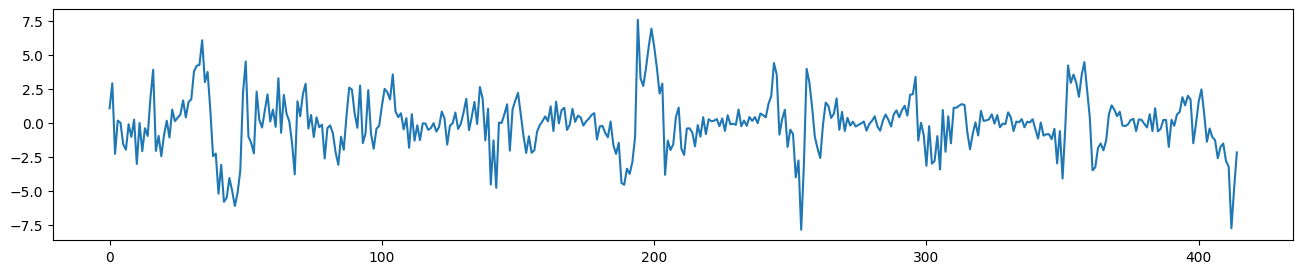

In [11]:
plt.figure(figsize=(16, 3))
plt.plot(df['positive_rate'])